## Prédiction du temps de livraison doorDash

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from dataprep.eda import create_report
import seaborn as sns
# import sweetviz as sv

Le but de ce projet est de prédire le temps de livraison (en secondes) attendue pour un commande passée à un restaurant via la plateforme DoorDash.

<span style="font-size:15px;">

dataset : Un subset de données sur les livraisons passsées sur DoorDash.  
Chaque ligne correspond à une commande et contient des informations sur :   
- Les dates et horaires auxquelles la commande est passée et arrive :
    * **created_at** : Timestamp de la validation de la commande par le client
    * **actual_delivery_time** : Timestamp de la livraison au client
- **marked_id** : l'ID de ville/région où la commande est passée  
- infos sur le magasin : 
    * **store_id** :identifiant d'un magasin, 
    * **store_primary_category** : catégorie de cuisine du restaurant)
    * **ordre_protocol** : mode de commande utilisé par le client  
- infos sur la commandes : 
    * **total_items** : nombre total d'items commandés
    * **subtotal** : valeur de la commande en cents 
    * **num_distinct_item** : nombre d'instincts de d'item dans la commande
    * **min_item_price**
    * **max_item_price** (valeur de l'item le moins/plus chère dans la commande)  
- infos sur l'état du marché : 
    * **total_onshift_dashers** : nombre de livreurs en service dans un rayon de 10 miles autour du magasin sollicité
    * **total_busy_dashers** : nombre de livreurs occupé par une commande
    * **total_outstanding_orders** : nombre de commandes dans un rayon de 10 miles autour de l'nedroit où la commande est passée 
- Prédictions d'autres modèles : 
    * **estimated_order_place_duration** : Temps estimé de recéption de la commande par le restaurant via l'app
    * **estimated_store_to_consumer_driving_duration** : Temps de trajet estimé entre le magasin et le client

</span>

### **Data exploration et preprocessing**

In [ ]:
df = pd.read_csv("Data/historical_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [3]:
df.head()
# market_id : city/region
# created_at et act_del_time : heure de la commande et heure d'arrivée de la livraison en secondes
# store_id : restaurant
# order_protocol : comment la commande a été passée via l'app
# tot_items, num_ distinct_items : nb de item et nb d'itme deiif dans la commande
# sub_total, min/max_item_price : total commande en cents, prix de l'itme coutant le moins/plus
# total_onshift_dashers, total_busy_dashers : AU moment où la commande est passée, nb de livreurs en shift, nb de livreur en train de faire une livraison dans un rayon de 10 miles du restaurant
# tot_outstanding_orders : nb de commandes à 10 miles de la commande envoyée
# estimated_order_place_duration : temps estimé pour que le restau reçoive la commande via DD en sec
# esti_store_to_cust_driv_duration : temps de trajet estimé en le client et restaurant en sec


market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

correction du type des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [12]:
df["created_at"] = pd.to_datetime(df["created_at"])
df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])
df[["market_id","store_id","order_protocol"]] = df[["market_id","store_id","order_protocol"]].astype("object")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  object        
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  object        
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  object        
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

Rajout de la cible : le du temps de livraison (en secondes et en minutes) et du temps de préparation estimé (en secondes et minutes)

In [14]:
# temps de livraison en secondes
df["delivery_time"] = pd.to_timedelta(df["actual_delivery_time"] - df["created_at"]).dt.seconds
# temps de livraison minutes
df["delivery_time_min"] = (df["delivery_time"]/60).round(2)

# delivery_time - driv_duration ==> aproxm de temps de prepa   (possible de pondérer par la taille de la commande?)
# temps de livraison - (temps pour que le restau recoive la commande + temps de trajet)
df["estimated_prep_time"] = df["delivery_time"] - (df["estimated_store_to_consumer_driving_duration"] + df["estimated_order_place_duration"])
df["estimated_prep_time_min"] = (df["estimated_prep_time"]/60).round(2)


In [7]:
df.head()

market_id          created_at actual_delivery_time store_id  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:27:16     1845   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:56:29     5477   
2       3.0 2015-01-22 20:39:28  2015-01-22 21:09:09     5477   
3       3.0 2015-02-03 21:21:45  2015-02-03 22:13:00     5477   
4       3.0 2015-02-15 02:40:36  2015-02-15 03:20:26     5477   

  store_primary_category order_protocol  total_items  subtotal  \
0               american            1.0            4      3441   
1                mexican            2.0            1      1900   
2                    NaN            1.0            1      1900   
3                    NaN            1.0            6      6900   
4                    NaN            1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  delivery_time  \
0                                         861.0         3779.0   
1                                         690.0         4024.0   
2                                         690.0         1781.0   
3                                         289.0         3075.0   
4                                         650.0         2390.0   

   delivery_time_min  estimated_prep_time  estimated_prep_time_min  
0              62.98               2472.0                    41.20  
1              67.07               2888.0                    48.13  
2              29.68                645.0                    10.75  
3              51.25               2340.0                    39.00  
4              39.83               1294.0                    21.57

In [23]:
# check les valeurs negatives et si cohérence change en positives
# prix d'item les plus cheres check le type de store et pour les plus excessif /10
# check les valeurs de 0
# subtotal doit etre sup au max item et min item

# where busy > total on shift
# calcul nb de daher dispo ?  densité de commande pour le nombre de livreurs dispo ou tot ?

# check date pour les commandes mettant plus de 1hr à arrivé

# nonmbre de commande reçues par un restau dans les 10 minutes autour de la commande actuelle
# nb de commande en cours de traitement par le restau (10 min window)

#### **gestion des NA et valeurs aberrantes**

In [15]:
# resume de colonnes de train : type de données, nombre et % de NA, nombres de modalités
colonne = []
type = []
nb_na = []
prc_na = []
n_mod = []
ex_var = []

for col in df.columns :
    type.append(df[col].dtype)
    nb_na.append(df[col].isna().sum())
    prc_na.append(df[col].isna().sum()/len(df))
    n_mod.append( df[col].nunique())
    ex_var.append(df[col].unique()[0:3])

dico = {"col" : df.columns.tolist(),
            "type" : type,
            "NA" : nb_na,
            "%NA" : prc_na,
            "n_modalités" :n_mod,
            "exemple de var" : ex_var
    }

resume_df = pd.DataFrame(dico)
resume_df

col            type     NA  \
0                                      market_id          object    987   
1                                     created_at  datetime64[ns]      0   
2                           actual_delivery_time  datetime64[ns]      7   
3                                       store_id          object      0   
4                         store_primary_category          object   4760   
5                                 order_protocol          object    995   
6                                    total_items           int64      0   
7                                       subtotal           int64      0   
8                             num_distinct_items           int64      0   
9                                 min_item_price           int64      0   
10                                max_item_price           int64      0   
11                         total_onshift_dashers         float64  16262   
12                            total_busy_dashers         float64  16262   
13                      total_outstanding_orders         float64  16262   
14                estimated_order_place_duration           int64      0   
15  estimated_store_to_consumer_driving_duration         float64    526   
16                                 delivery_time         float64      7   
17                             delivery_time_min         float64      7   
18                           estimated_prep_time         float64    533   
19                       estimated_prep_time_min         float64    533   

         %NA  n_modalités                                     exemple de var  
0   0.004999            6                                    [1.0, 2.0, 3.0]  
1   0.000000       180985  [2015-02-06 22:24:17, 2015-02-10 21:49:25, 201...  
2   0.000035       178110  [2015-02-06 23:27:16, 2015-02-10 22:56:29, 201...  
3   0.000000         6743                                 [1845, 5477, 2841]  
4   0.024110           74                           [american, mexican, nan]  
5   0.005040            7                                    [1.0, 2.0, 3.0]  
6   0.000000           57                                          [4, 1, 6]  
7   0.000000         8368                                 [3441, 1900, 6900]  
8   0.000000           20                                          [4, 1, 5]  
9   0.000000         2312                                  [557, 1400, 1900]  
10  0.000000         2652                                 [1239, 1400, 1900]  
11  0.082369          172                                   [33.0, 1.0, 6.0]  
12  0.082369          159                                   [14.0, 2.0, 0.0]  
13  0.082369          281                                   [21.0, 2.0, 0.0]  
14  0.000000           98                                      [446, 251, 0]  
15  0.002664         1336                              [861.0, 690.0, 289.0]  
16  0.000035         7134                           [3779.0, 4024.0, 1781.0]  
17  0.000035         7134                              [62.98, 67.07, 29.68]  
18  0.002700         6896                            [2472.0, 2888.0, 645.0]  
19  0.002700         6896                               [41.2, 48.13, 10.75]

Store_primary_category a beaucoup de modalités. Ce sera à gérer dans le preprocessing

In [16]:
df.isna().sum()/len(df)
# laisse market_id et store car pas utile a priori pour les pred
# order protocol remplace par le plus courant

market_id                                       0.004999
created_at                                      0.000000
actual_delivery_time                            0.000035
store_id                                        0.000000
store_primary_category                          0.024110
order_protocol                                  0.005040
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           0.082369
total_busy_dashers                              0.082369
total_outstanding_orders                        0.082369
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.002664
delivery_time                                   0.000035
delivery_time_min              

In [17]:
# supprmie les lignes où il y a des NA pour certaines colonnes
df = df.dropna(subset=["total_onshift_dashers","actual_delivery_time","estimated_store_to_consumer_driving_duration"])
# order protocole : remplace les NA par le mode
df.loc[df["order_protocol"].isna(),"order_protocol"] = df["order_protocol"].mode()[0]

df.isna().sum()


market_id                                        918
created_at                                         0
actual_delivery_time                               0
store_id                                           0
store_primary_category                          4205
order_protocol                                     0
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                              0
total_busy_dashers                                 0
total_outstanding_orders                           0
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration       0
delivery_time                                      0
delivery_time_min                                  0
estimated_prep_time                           

In [20]:
df.describe(include='number')

total_items       subtotal  num_distinct_items  min_item_price  \
count  180677.000000  180677.000000       180677.000000   180677.000000   
mean        3.208870    2699.123253            2.678133      684.871467   
std         2.673251    1828.945581            1.627414      521.267676   
min         1.000000       0.000000            1.000000      -86.000000   
25%         2.000000    1418.000000            2.000000      299.000000   
50%         3.000000    2225.000000            2.000000      595.000000   
75%         4.000000    3414.000000            3.000000      942.000000   
max       411.000000   26800.000000           20.000000    14700.000000   

       max_item_price  total_onshift_dashers  total_busy_dashers  \
count   180677.000000          180677.000000       180677.000000   
mean      1161.022316              44.820824           41.755315   
std        561.889973              34.540923           32.158649   
min          0.000000              -4.000000           -5.000000   
25%        799.000000              17.000000           15.000000   
50%       1095.000000              37.000000           34.000000   
75%       1395.000000              65.000000           62.000000   
max      14700.000000             171.000000          154.000000   

       total_outstanding_orders  estimated_order_place_duration  \
count             180677.000000                   180677.000000   
mean                  58.072190                      308.881507   
std                   52.682361                       90.346996   
min                   -6.000000                        0.000000   
25%                   17.000000                      251.000000   
50%                   41.000000                      251.000000   
75%                   85.000000                      446.000000   
max                  285.000000                     2715.000000   

       estimated_store_to_consumer_driving_duration  delivery_time  \
count                                 180677.000000  180677.000000   
mean                                     545.958168    2863.533720   
std                                      218.573721    1177.451496   
min                                        0.000000     101.000000   
25%                                      383.000000    2105.000000   
50%                                      544.000000    2662.000000   
75%                                      703.000000    3383.000000   
max                                     2088.000000   73282.000000   

       delivery_time_min  estimated_prep_time  estimated_prep_time_min  
count      180677.000000        180677.000000            180677.000000  
mean           47.725556          2008.694045                33.478240  
std            19.624196          1142.820996                19.047022  
min             1.680000          -670.000000               -11.170000  
25%            35.080000          1274.000000                21.230000  
50%            44.370000          1802.000000                30.030000  
75%            56.380000          2498.000000                41.630000  
max          1221.370000         72264.000000              1204.400000

Présence de valeurs négatives et de maximums qui sont probablement des outliers, valeurs abberantes

In [21]:
# partout ou il y valeur négatives modif en positives

for col in df.select_dtypes('number').columns : 
    df.loc[(df[col] < 0),col] = df.loc[(df[col] < 0),col].apply(lambda x : x*-1) # ou val abs tout simplement

In [22]:
df[(df.select_dtypes('number').values < 0)]

Empty DataFrame
Columns: [market_id, created_at, actual_delivery_time, store_id, store_primary_category, order_protocol, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, delivery_time, delivery_time_min, estimated_prep_time, estimated_prep_time_min]
Index: []

Il y a certaines lignes où le nombres de livreurs occupés est supérieur au nombre de livreurs en services, donc incohérence.
Dans ces cas là, choix d'inverser les valeurs de deux colonnes

In [23]:
# certaines lignes où le nb de dshr ocp > on shift 
df["total_onshift_dashers"]-df["total_busy_dashers"]

0         19.0
1         -1.0
2          1.0
3          0.0
4          0.0
          ... 
197423     0.0
197424     1.0
197425    -2.0
197426     0.0
197427     0.0
Length: 180677, dtype: float64

In [24]:
# certaines lignes où le nb de dshr ocp > on shift 
df[df["total_busy_dashers"] > df["total_onshift_dashers"]][["total_onshift_dashers","total_busy_dashers","total_outstanding_orders"]]

total_onshift_dashers  total_busy_dashers  total_outstanding_orders
1                         1.0                 2.0                       2.0
7                         7.0                 8.0                       7.0
14                        5.0                 6.0                       8.0
18                        4.0                 9.0                      12.0
20                       12.0                13.0                      11.0
...                       ...                 ...                       ...
197411                    5.0                 6.0                       7.0
197412                   10.0                11.0                      12.0
197418                   26.0                29.0                      34.0
197422                   23.0                24.0                      24.0
197425                   39.0                41.0                      40.0

[40320 rows x 3 columns]

In [25]:
# inverse les valeurs de tot et on_shift quand incohérence 
df.loc[df["total_busy_dashers"] > df["total_onshift_dashers"],"total_onshift_dashers"]
#
new_busy = df.loc[df["total_busy_dashers"] > df["total_onshift_dashers"],"total_onshift_dashers"]
new_onshift = df.loc[df["total_busy_dashers"] > df["total_onshift_dashers"],"total_busy_dashers"]

df.loc[new_busy.index, "total_busy_dashers"] = new_busy
df.loc[new_onshift.index, "total_onshift_dashers"] = new_onshift

In [26]:
df[df["total_busy_dashers"] > df["total_onshift_dashers"]]

Empty DataFrame
Columns: [market_id, created_at, actual_delivery_time, store_id, store_primary_category, order_protocol, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, delivery_time, delivery_time_min, estimated_prep_time, estimated_prep_time_min]
Index: []

Présence de plusieurs colonnes où il y a des outliers très importants

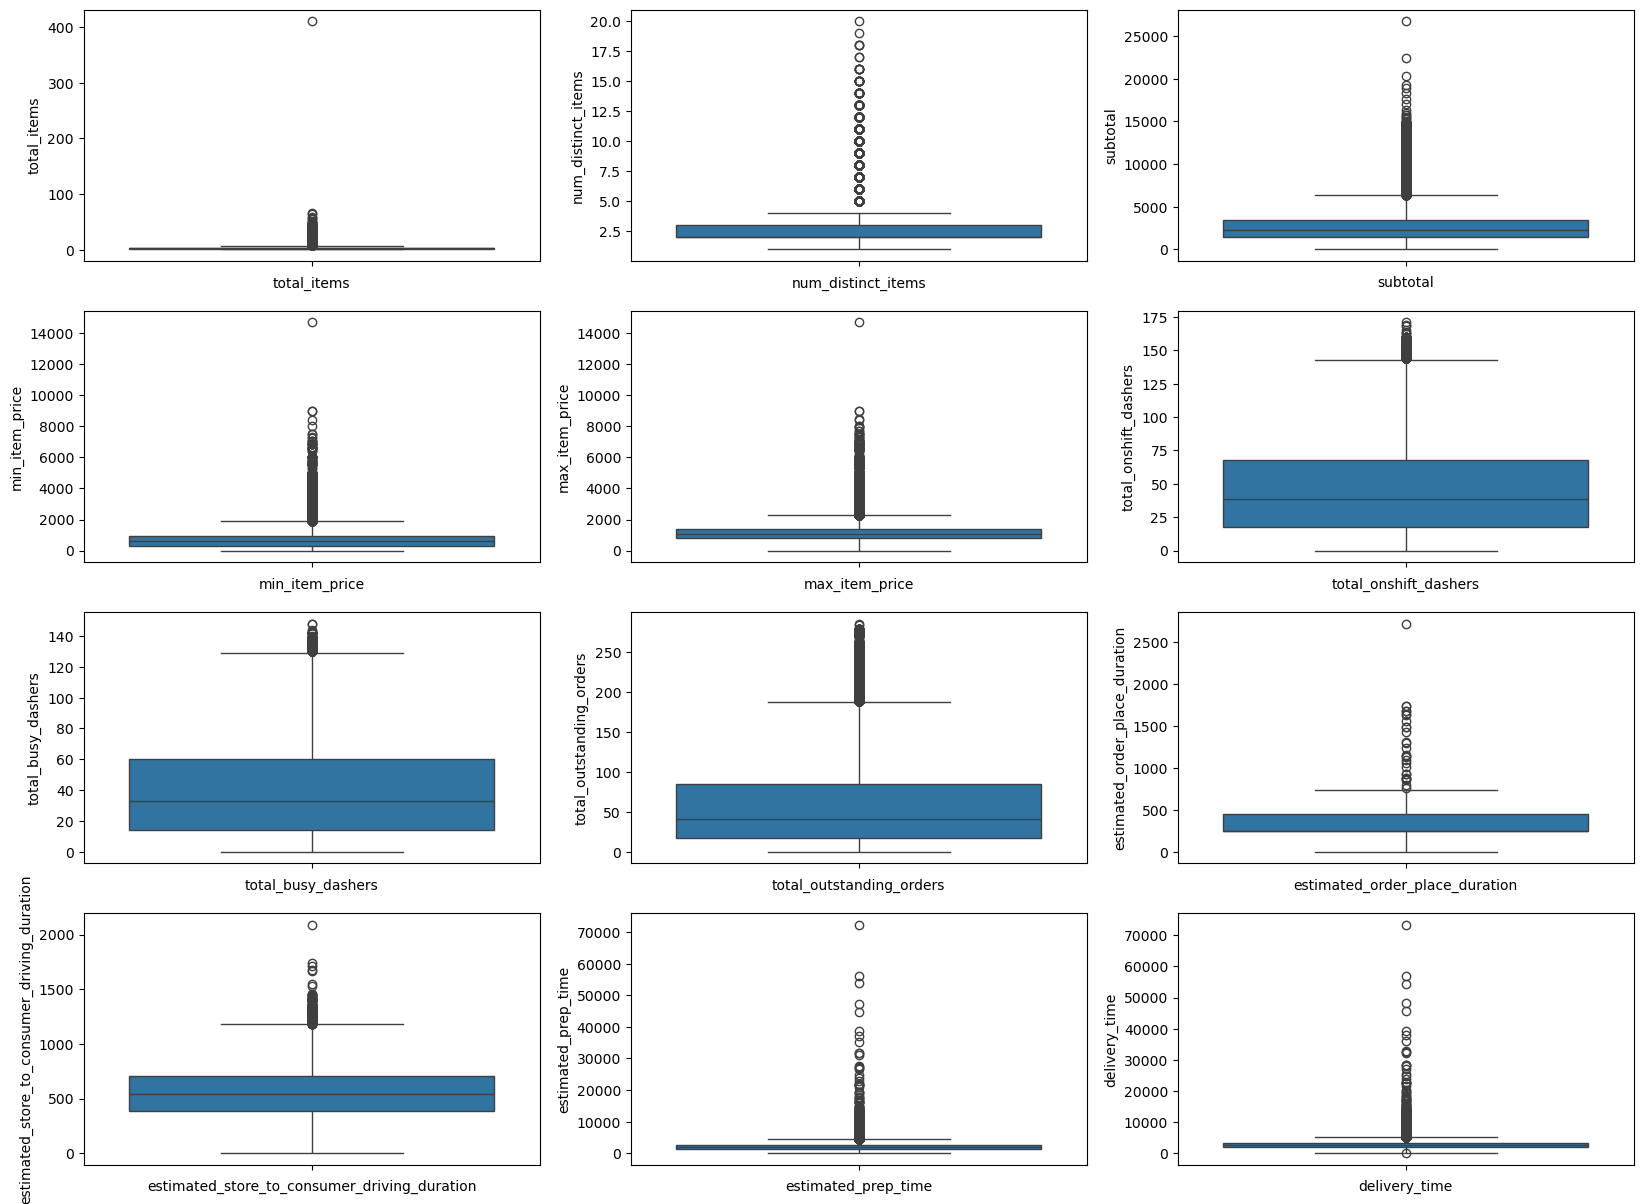

In [27]:
# boxplot des variables quantitatives avec outliers et de la cible (delivery_time)

var = ["total_items","num_distinct_items","subtotal","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","estimated_prep_time","delivery_time"]

i=1
plt.figure(figsize=(20,15))
# plt.title("Distribution des variables quantitatives")
for col in var :
    plt.subplot(4,3,i)
    sns.boxplot(df[col])
    plt.xlabel(col)
    i=i+1

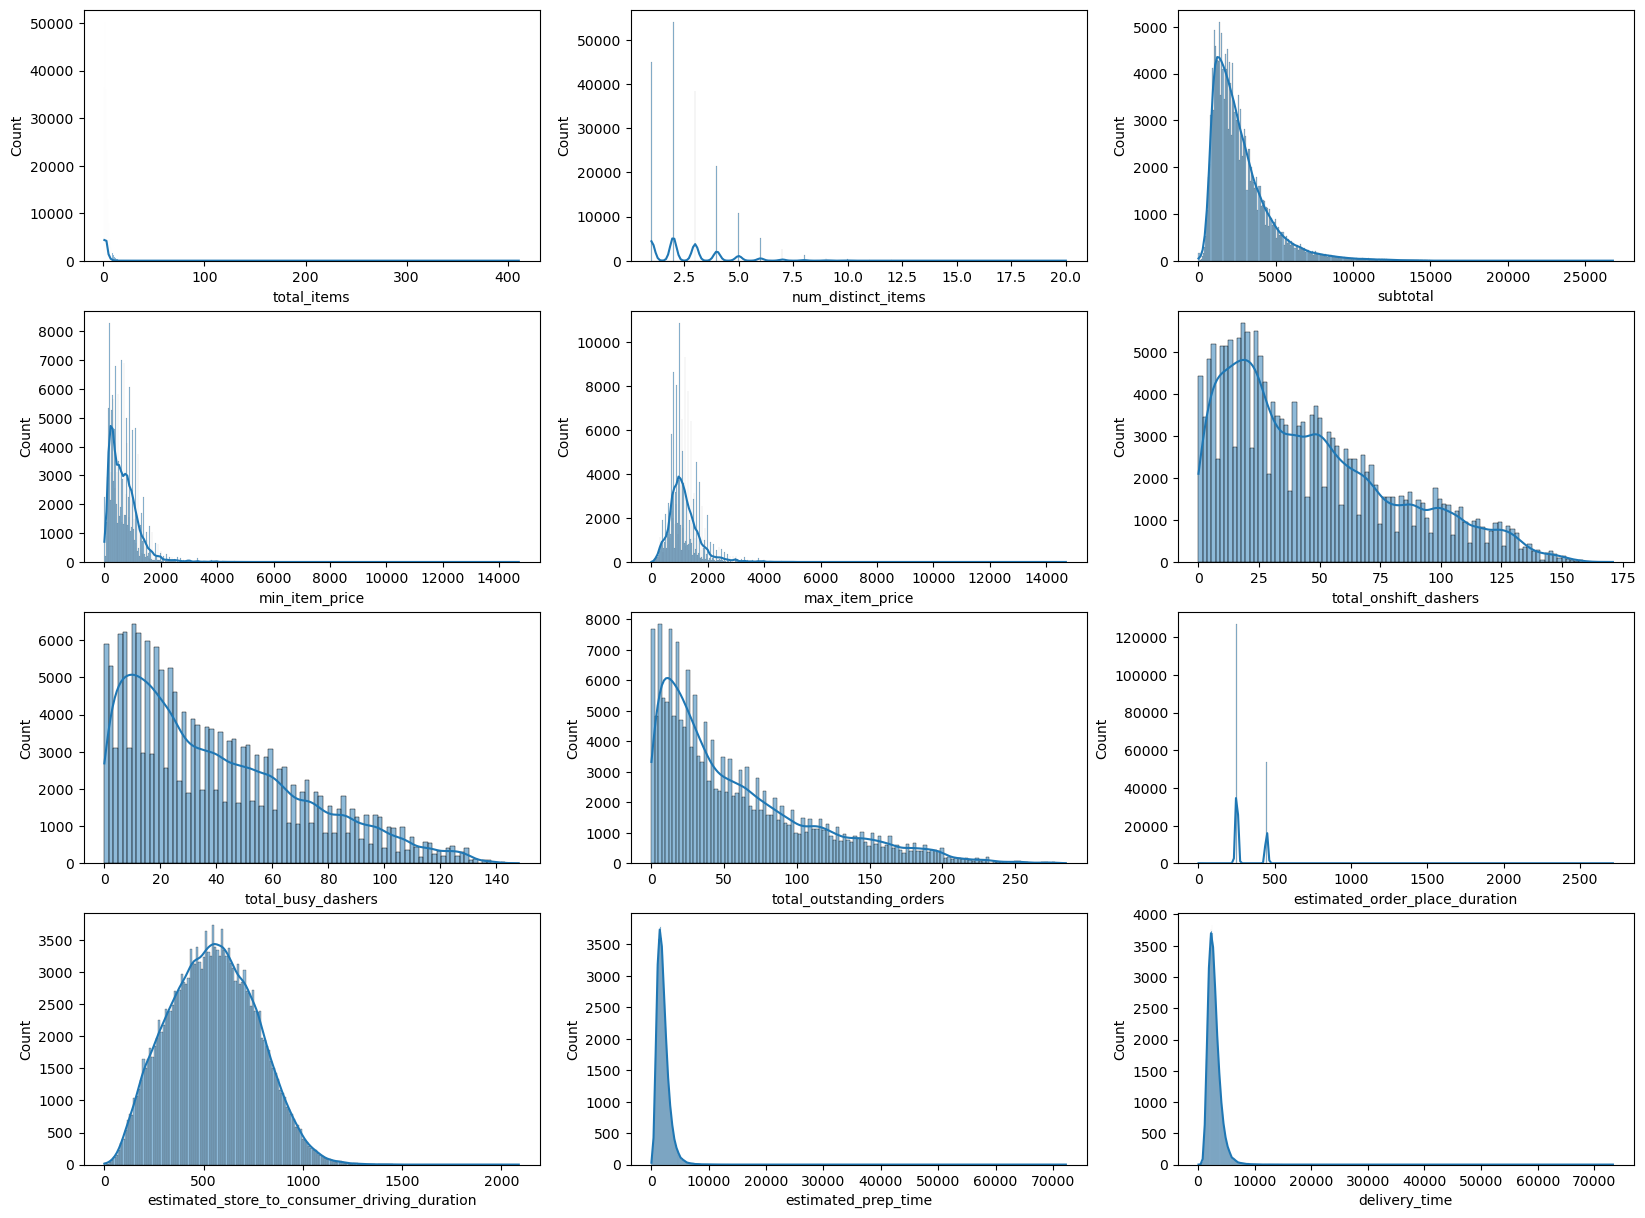

In [28]:
# distributions des variables quantitatives avec outliers et de la cible (delivery_time)

var = ["total_items","num_distinct_items","subtotal","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","estimated_prep_time","delivery_time"]

i=1
plt.figure(figsize=(20,15))
# plt.title("Distribution des variables quantitatives")
for col in var :
    plt.subplot(4,3,i)
    sns.histplot(df[col],kde=True)
    plt.xlabel(col)
    i=i+1

Pour les features numériques, on regarde quelles sont les limites supérieures et inférieures en fonction de 3 stratégies : IQR,MAD ou std à 95%

In [29]:
### calcul des outliers avec IQR,MAD et srd 95%

var = ["total_items","num_distinct_items","subtotal","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","estimated_prep_time","delivery_time","delivery_time_min"]

print("Limites supérieures et inférieures calculées par IQR","\n")
for col in var : 
    # outliers iqr
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    IQR=q3-q1
    
    # outliers mad
    MAD = np.median(abs(df[col]-np.median(df[col])))
    upper = np.median(df[col]) + 3.29*MAD
    lower = np.median(df[col]) - 3.29*MAD
    
    # outliers 95%
    hight = df[col].quantile(0.95)
    low = df[col].quantile(0.05)
    
    print(col)
    print("valeur min:",  min(df[col]),' valeur max:', max(df[col]))
    print("IQR inf",q1-1.5*IQR,';',"IQR sup",q3+1.5*IQR)
    print("MAD inf",lower,'-',"MAD sup",upper)
    print("95 inf",low,'-',"95 sup",hight,'\n')
   
# coupe estimated_order_place_duration (12 min max)


Limites supérieures et inférieures calculées par IQR 

total_items
valeur min: 1  valeur max: 411
IQR inf -1.0 ; IQR sup 7.0
MAD inf -0.29000000000000004 - MAD sup 6.29
95 inf 1.0 - 95 sup 7.0 

num_distinct_items
valeur min: 1  valeur max: 20
IQR inf 0.5 ; IQR sup 4.5
MAD inf -1.29 - MAD sup 5.29
95 inf 1.0 - 95 sup 6.0 

subtotal
valeur min: 0  valeur max: 26800
IQR inf -1576.0 ; IQR sup 6408.0
MAD inf -831.4099999999999 - MAD sup 5281.41
95 inf 805.0 - 95 sup 6255.0 

min_item_price
valeur min: 0  valeur max: 14700
IQR inf -665.5 ; IQR sup 1906.5
MAD inf -405.15999999999997 - MAD sup 1595.1599999999999
95 inf 125.0 - 95 sup 1589.0 

max_item_price
valeur min: 0  valeur max: 14700
IQR inf -95.0 ; IQR sup 2289.0
MAD inf 121.15999999999997 - MAD sup 2068.84
95 inf 440.0 - 95 sup 2100.0 

total_onshift_dashers
valeur min: 0.0  valeur max: 171.0
IQR inf -57.0 ; IQR sup 143.0
MAD inf -39.96000000000001 - MAD sup 117.96000000000001
95 inf 4.0 - 95 sup 117.0 

total_busy_dashers
valeur min:

In [489]:
# pour estimated_order_place_duration (temps pour que le restaurant reçoive la commande) l'IQR est à 12min et le MAD à 4 min
# parait plus cohérent que le temps pour que l'ordre de commande arrive au restaurant soit court ==> toute les valeurs au dessus de 4 sont mise à 4

In [30]:
df.estimated_order_place_duration.describe()

count    180677.000000
mean        308.881507
std          90.346996
min           0.000000
25%         251.000000
50%         251.000000
75%         446.000000
max        2715.000000
Name: estimated_order_place_duration, dtype: float64

Pour total_items (et donc num_distinct_items) gestion avec limites perso

In [32]:
# groupe par taille de la commande et regarde les stats du total et du temps de livraison pour voir 
# si il y a une cohérence dans la taille de la commande
df.groupby("total_items")[["subtotal","delivery_time_min"]].agg(["count","mean","min",'max']) 
# le prix de la commande augmente avec le nombre d'item jusqu'à environ une dizaine


subtotal                            delivery_time_min             \
               count          mean   min    max             count       mean   
total_items                                                                    
1              36544   1340.808642     0  14700             36544  44.583782   
2              50302   2012.433362     0  14160             50302  46.251085   
3              36159   2696.245776     0  14700             36159  47.891633   
4              23283   3311.752137     0  15960             23283  49.318350   
5              12998   3967.041776     0  14594             12998  50.336978   
6               7989   4430.588309     0  15435              7989  51.514285   
7               4645   4966.969860     0  14900              4645  52.543668   
8               2794   5594.483536     0  14072              2794  53.380920   
9               1714   5875.037923     0  14600              1714  54.174778   
10              1168   6360.859589   438  15089              1168  56.006113   
11               760   6552.700000     0  19250               760  55.629934   
12               604   6826.771523   298  14730               604  56.619702   
13               366   6614.188525     0  14955               366  57.414344   
14               298   6690.788591   558  17600               298  54.214295   
15               212   6787.349057     0  14795               212  55.798868   
16               171   5970.380117   556  18920               171  54.775263   
17               123   6750.691057   448  22500               123  56.084472   
18               100   6090.190000   618  15710               100  51.889800   
19                62   6050.854839   725  15505                62  56.769355   
20                59   5786.559322   716  20350                59  49.638305   
21                46   5919.108696   805  18370                46  56.523696   
22                35   5577.400000   907  12780                35  49.042000   
23                18   5437.277778   638  14427                18  50.651111   
24                35   4809.971429   766  17008                35  50.145429   
25                32   4282.593750   627  26800                32  45.026563   
26                30   4401.766667   855  14600                30  50.002333   
27                16   4097.000000   910  13690                16  55.780625   
28                17   3475.058824   832  15238                17  46.560588   
29                12   3566.583333  1349   9375                12  43.118333   
30                15   5119.800000   836  11625                15  49.156000   
31                 5   3753.000000  1664  10750                 5  39.802000   
32                 4   7479.500000  1712  13890                 4  56.935000   
33                 6   4746.500000  1737  10737                 6  55.526667   
34                 8   4141.125000  1066   9695                 8  44.420000   
35                 7   3132.714286  1235   6405                 7  44.924286   
36                 4   6654.750000  1464  12596                 4  70.387500   
37                 2   1338.000000  1073   1603                 2  48.045000   
38                 2  11722.000000  8602  14842                 2  77.025000   
39                 3   2568.000000  1126   4425                 3  61.790000   
40                 4   7484.000000  1661  12938                 4  62.622500   
41                 2   2417.000000  1764   3070                 2  33.235000   
42                 7   4221.142857  1273  11275                 7  46.451429   
44                 1   2946.000000  2946   2946                 1  57.270000   
45                 1   4653.000000  4653   4653                 1  64.400000   
47                 1    857.000000   857    857                 1  17.330000   
48                 4   2731.000000  1853   3786                 4  54.187500   
49                 1   6222.000000  6222   6222                 1  58.900000   
50          

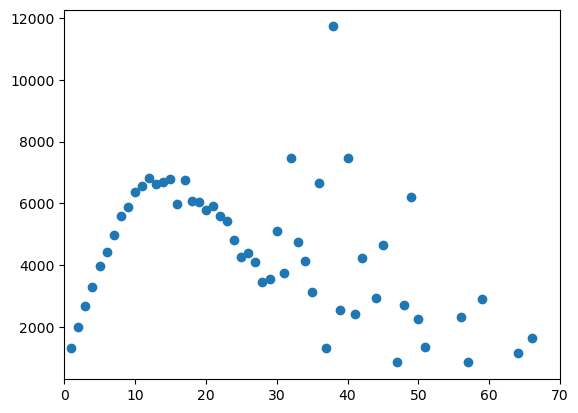

In [33]:
a = df.groupby("total_items")[["subtotal","delivery_time_min"]].agg(["count","mean","min",'max'])
plt.scatter(a.index,a["subtotal"]["mean"])
plt.xlim(0,70);

Le prix de la commande augmente avec le nombre d'item jusqu'à environ une dizaine d'article.      
Décide de ne conserver que les commandes avec 10 articles ou moins

In [ ]:
df = df.drop(df[df.total_items > 10].index)
df[df.total_items>10]

Pour le reste des variables, décide de gérer les outliers avec IQR

In [35]:
var = ["subtotal","min_item_price",
       "max_item_price","total_onshift_dashers","total_busy_dashers","total_outstanding_orders",
       "estimated_order_place_duration","estimated_store_to_consumer_driving_duration","delivery_time","delivery_time_min"]
# conserve les outliers dans dico pour chaque variables
dico_out = {}
for col in var : 
    
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    IQR=q3-q1
    
    dico_out[col] = [float(q1-1.5*IQR),float(q3+1.5*IQR)]


In [36]:
dico_out

{'subtotal': [-1570.0, 6350.0],
 'min_item_price': [-675.0, 1925.0],
 'max_item_price': [-92.5, 2287.5],
 'total_onshift_dashers': [-57.0, 143.0],
 'total_busy_dashers': [-55.0, 129.0],
 'total_outstanding_orders': [-85.0, 187.0],
 'estimated_order_place_duration': [-41.5, 738.5],
 'estimated_store_to_consumer_driving_duration': [-94.5, 1181.5],
 'delivery_time': [195.5, 5279.5],
 'delivery_time_min': [3.2450000000000045, 88.005]}

In [37]:
# retrait des lignes où la valeur de la colonne dépasse les outliers
df_new = df.copy()

for col in dico_out.keys() :
    outlier_inf = dico_out[col][0]
    outlier_sup = dico_out[col][1]
    df_new = df_new.drop(df_new[(df_new[col]>=outlier_sup) | (df_new[col]<=outlier_inf)].index)

In [38]:
print(df.shape)
print(df_new.shape)
print("nb de lignes supprimmées : ",df.shape[0]-df_new.shape[0])

(177596, 20)
(153458, 20)
nb de lignes supprimmées :  24138


In [39]:
df_new.describe(include = 'number')

total_items       subtotal  num_distinct_items  min_item_price  \
count  153458.000000  153458.000000       153458.000000   153458.000000   
mean        2.883903    2342.256995            2.501649      643.929336   
std         1.692018    1271.254574            1.345534      407.067165   
min         1.000000       0.000000            1.000000        0.000000   
25%         2.000000    1349.000000            1.000000      299.000000   
50%         2.000000    2060.000000            2.000000      595.000000   
75%         4.000000    3085.000000            3.000000      900.000000   
max        10.000000    6348.000000           10.000000     1924.000000   

       max_item_price  total_onshift_dashers  total_busy_dashers  \
count   153458.000000          153458.000000       153458.000000   
mean      1062.385982              43.608720           37.144952   
std        388.328263              32.530448           28.025887   
min          0.000000               0.000000            0.000000   
25%        795.000000              17.000000           14.000000   
50%       1025.000000              36.000000           31.000000   
75%       1299.000000              64.000000           56.000000   
max       2287.000000             142.000000          128.000000   

       total_outstanding_orders  estimated_order_place_duration  \
count             153458.000000                   153458.000000   
mean                  52.273997                      308.363689   
std                   45.363584                       89.238145   
min                    0.000000                        0.000000   
25%                   16.000000                      251.000000   
50%                   38.000000                      251.000000   
75%                   78.000000                      446.000000   
max                  186.000000                      732.000000   

       estimated_store_to_consumer_driving_duration  delivery_time  \
count                                 153458.000000  153458.000000   
mean                                     541.145095    2683.199788   
std                                      216.485307     868.967992   
min                                        0.000000     223.000000   
25%                                      379.000000    2044.000000   
50%                                      540.000000    2562.000000   
75%                                      698.000000    3210.000000   
max                                     1181.000000    5279.000000   

       delivery_time_min  estimated_prep_time  estimated_prep_time_min  
count      153458.000000        153458.000000            153458.000000  
mean           44.719993          1833.845287                30.564089  
std            14.482805           833.229979                13.887169  
min             3.720000             1.000000                 0.020000  
25%            34.070000          1216.000000                20.270000  
50%            42.700000          1705.000000                28.420000  
75%            53.500000          2330.000000                38.830000  
max            87.980000          4891.000000                81.520000

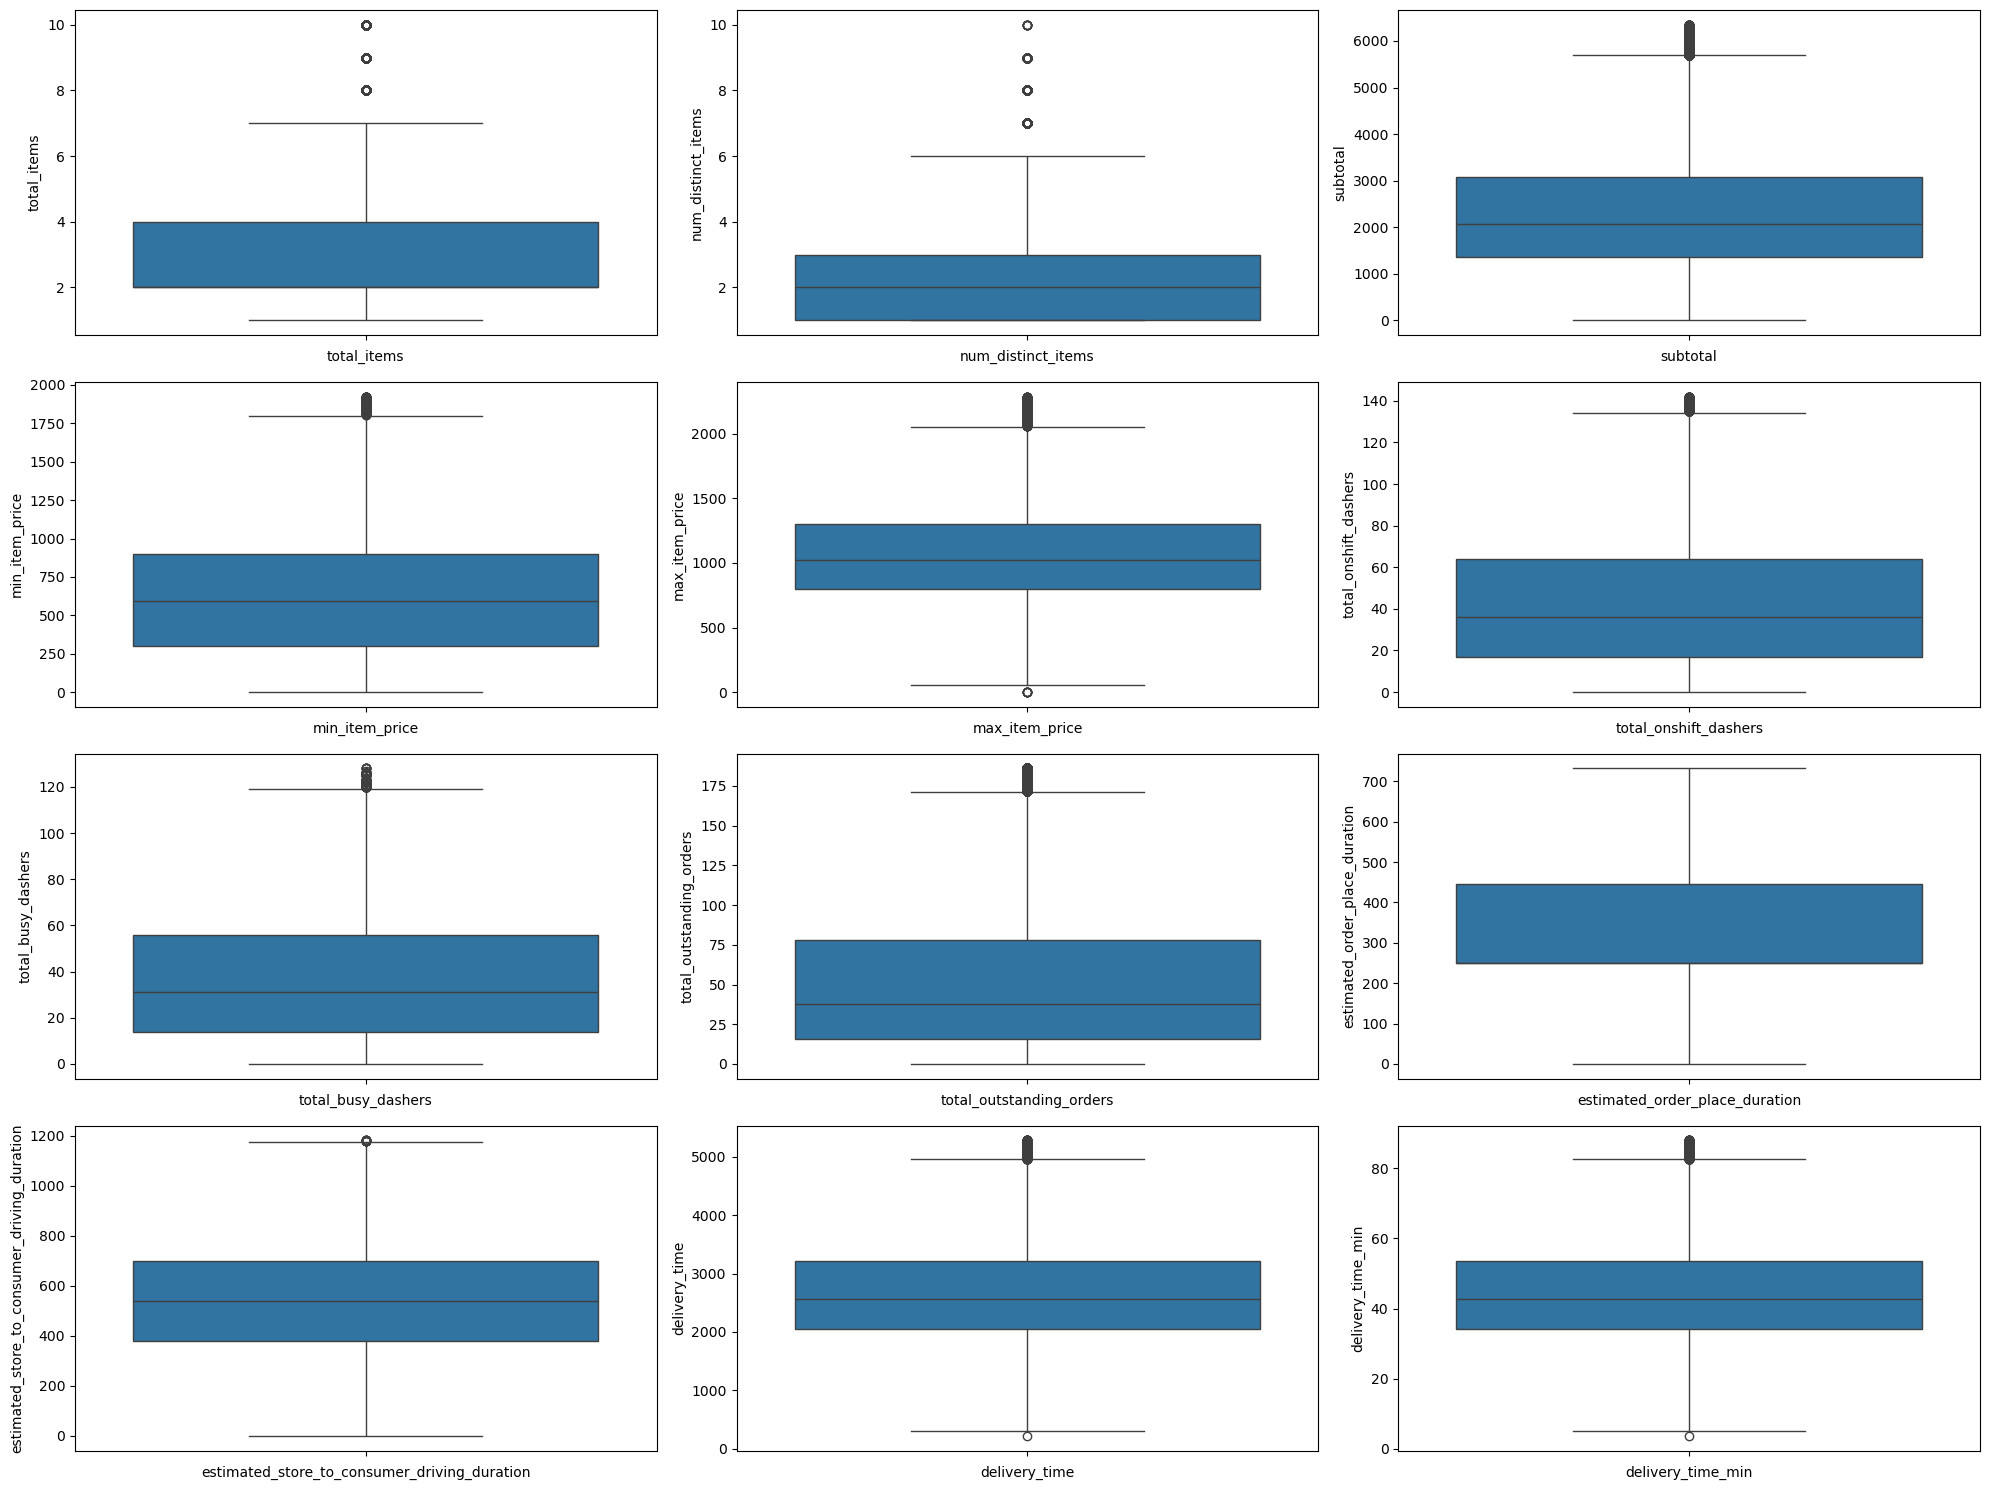

In [ ]:
# distributions des variables quantitatives avec outliers et de la cible (delivery_time)

var = ["total_items","num_distinct_items","subtotal","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","delivery_time","delivery_time_min"]

i=1
plt.figure(figsize=(20,15))
# plt.title("Distribution des variables quantitatives")
for col in var :
    plt.subplot(4,3,i)
    sns.boxplot(df_new[col])
    plt.xlabel(col)
    i=i+1

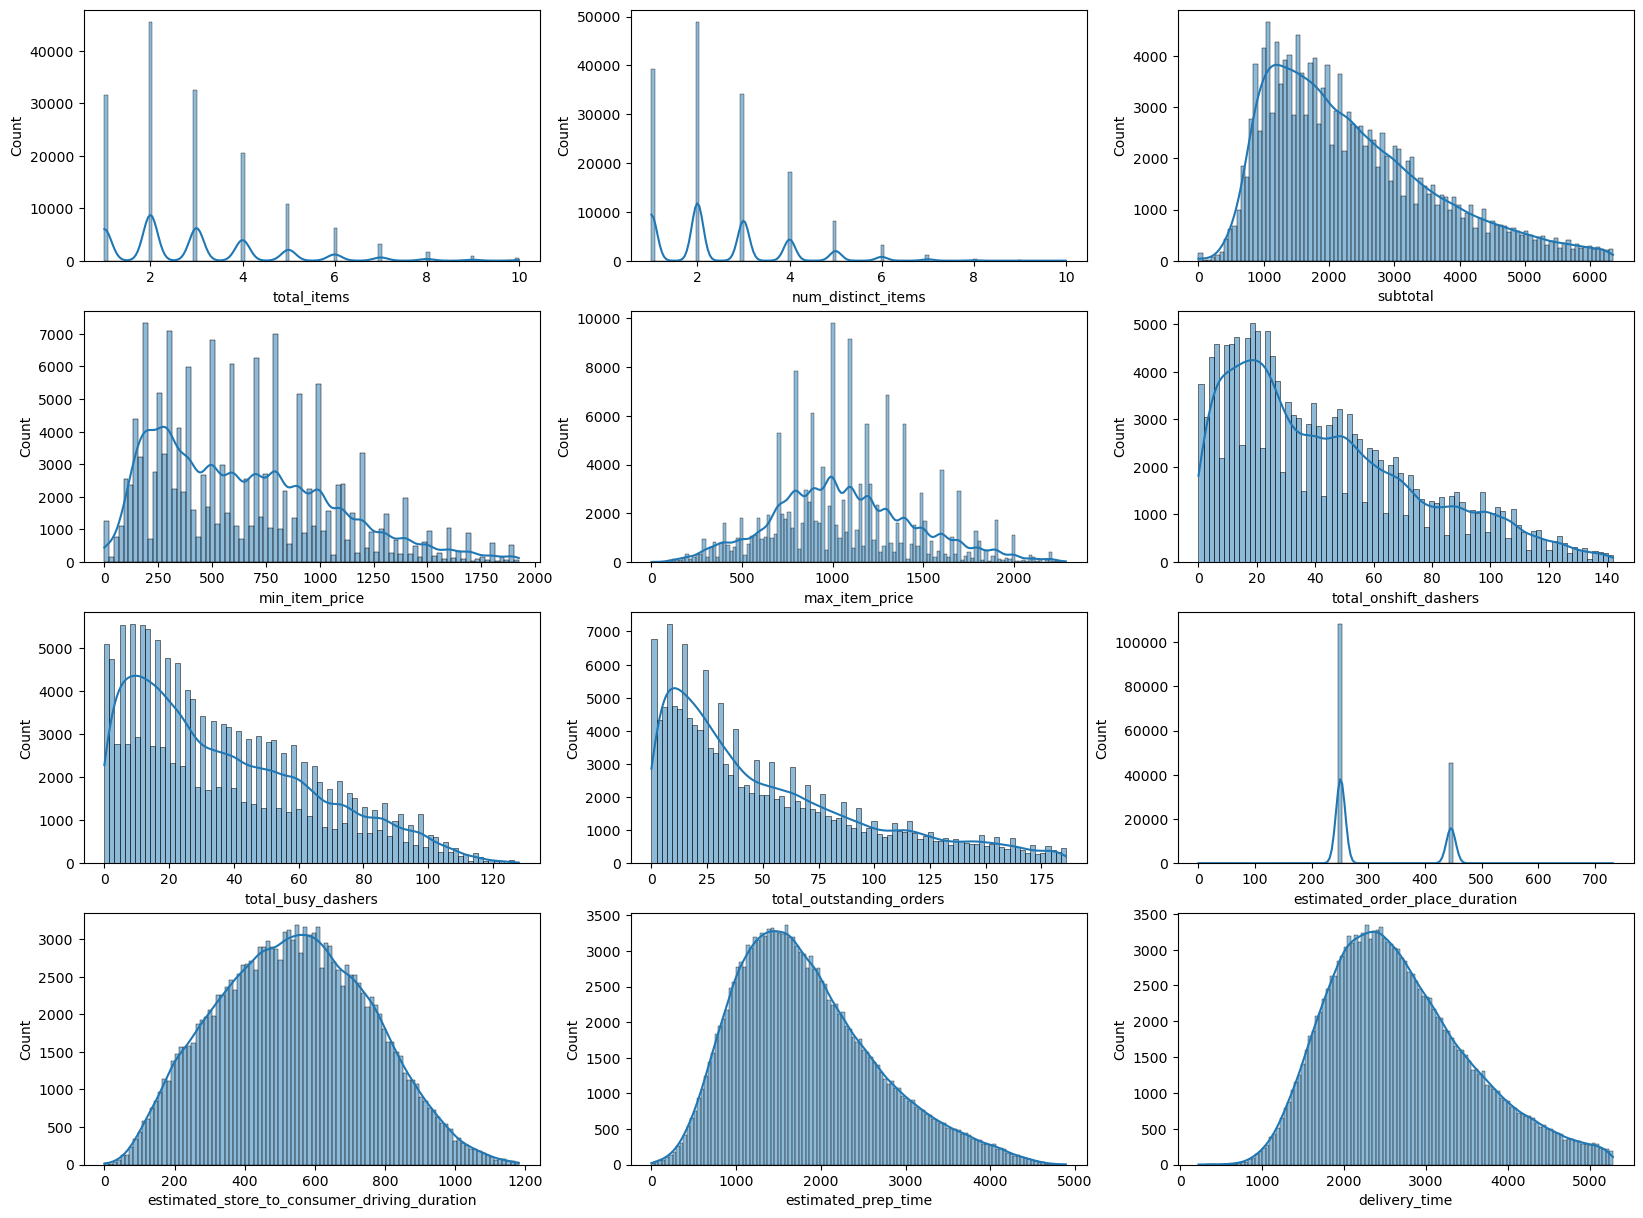

In [42]:
# distributions des variables quantitatives avec outliers et de la cible (delivery_time)

var = ["total_items","num_distinct_items","subtotal","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","estimated_prep_time","delivery_time"]

i=1
plt.figure(figsize=(20,15))
# plt.title("Distribution des variables quantitatives")
for col in var :
    plt.subplot(4,3,i)
    sns.histplot(df_new[col],kde=True)
    plt.xlabel(col)
    i=i+1

Les distributions des variables semblent maintenant plus correctes

### **Exploration des variables quantitatives**

<span style="font-size:15px;">
Exploration des distributions des variables quantitatives et leurs relations avec la cible 
</span>

##### **Etat du marché (commandes,livreurs)**

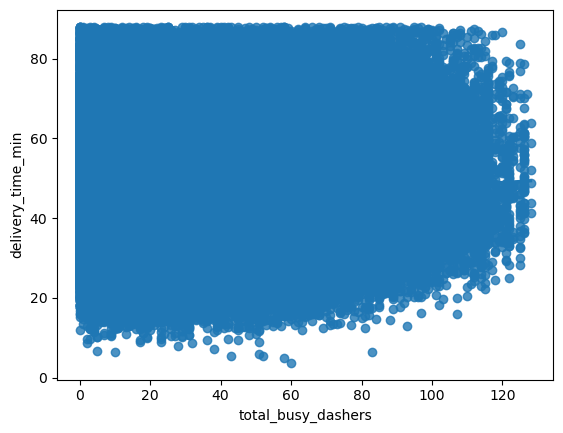

In [ ]:
sns.regplot(x=df_new["total_busy_dashers"],y=df_new["delivery_time_min"]);
# temps de livraison en fonction du nombre de livreurs occuppés 10 miles autour du client

# beaucoup de données donc difficiles à visualiser : binning

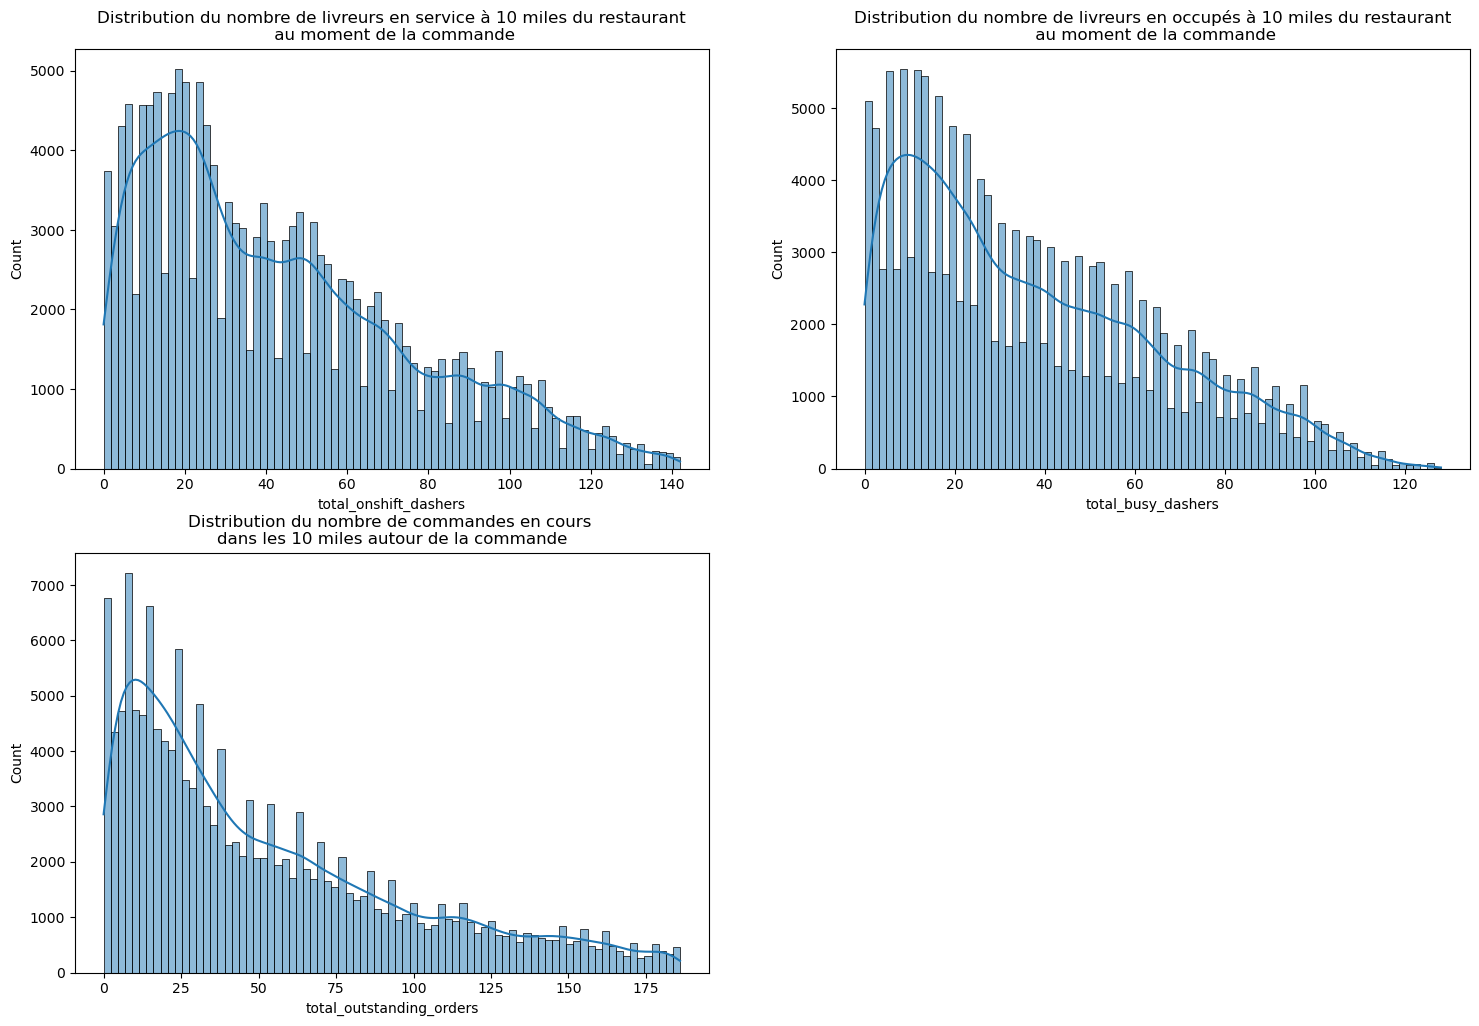

In [50]:
plt.figure(figsize=(18,12))
plt.subplot(221)
sns.histplot(x="total_onshift_dashers", kde=True,data = df_new)
plt.title("Distribution du nombre de livreurs en service à 10 miles du restaurant\n au moment de la commande")

plt.subplot(222)
sns.histplot(x="total_busy_dashers", kde=True,data = df_new)
plt.title("Distribution du nombre de livreurs en occupés à 10 miles du restaurant\n au moment de la commande")

plt.subplot(223)
sns.histplot(x="total_outstanding_orders", kde=True,data = df_new)
plt.title("Distribution du nombre de commandes en cours \ndans les 10 miles autour de la commande");



In [44]:
display(df_new.groupby(pd.cut(df_new.total_outstanding_orders,bins = 6),observed=True)["delivery_time"].describe())
# groupe le nombre de commandes par 30 environ

display(df_new.groupby(pd.cut(df_new.total_onshift_dashers,bins = 5),observed=True)["delivery_time"].describe())
# bin de environ 30 pour le nombre de dasher en service

display(df_new.groupby(pd.cut(df_new.total_busy_dashers,bins = 5),observed=True)["delivery_time"].describe())
# bin de environ 25 pour le nombre de dasher occupé


count         mean         std    min     25%  \
total_outstanding_orders                                                    
(-0.186, 31.0]            67478.0  2595.729290  879.668948  386.0  1947.0   
(31.0, 62.0]              35124.0  2555.955073  842.106034  223.0  1945.0   
(62.0, 93.0]              22470.0  2729.300579  837.209915  325.0  2119.0   
(93.0, 124.0]             13489.0  2898.283935  814.445399  386.0  2301.0   
(124.0, 155.0]             8950.0  3040.469944  795.308451  888.0  2450.0   
(155.0, 186.0]             5947.0  3227.500252  792.756975  773.0  2636.5   

                             50%      75%     max  
total_outstanding_orders                           
(-0.186, 31.0]            2452.0  3114.00  5279.0  
(31.0, 62.0]              2429.0  3037.00  5277.0  
(62.0, 93.0]              2616.0  3236.00  5279.0  
(93.0, 124.0]             2786.0  3396.00  5275.0  
(124.0, 155.0]            2949.0  3547.75  5279.0  
(155.0, 186.0]            3133.0  3753.00  5279.0

count         mean         std    min      25%  \
total_onshift_dashers                                                     
(-0.142, 28.4]         64184.0  2673.807475  898.199528  386.0  2006.00   
(28.4, 56.8]           42291.0  2589.424606  854.462735  321.0  1968.00   
(56.8, 85.2]           26166.0  2730.810441  857.457228  223.0  2102.25   
(85.2, 113.6]          15467.0  2823.504364  805.285553  386.0  2252.00   
(113.6, 142.0]          5350.0  2898.678505  744.265843  773.0  2364.00   

                          50%     75%     max  
total_onshift_dashers                          
(-0.142, 28.4]         2534.0  3223.0  5279.0  
(28.4, 56.8]           2458.0  3089.0  5279.0  
(56.8, 85.2]           2613.0  3257.0  5279.0  
(85.2, 113.6]          2740.0  3308.0  5279.0  
(113.6, 142.0]         2810.5  3375.0  5278.0

count         mean         std    min     25%     50%  \
total_busy_dashers                                                            
(-0.128, 25.6]      67015.0  2646.095367  893.370723  386.0  1983.0  2505.0   
(25.6, 51.2]        41627.0  2592.073102  849.870141  321.0  1974.0  2465.0   
(51.2, 76.8]        27290.0  2742.251704  847.109389  223.0  2124.0  2625.0   
(76.8, 102.4]       14733.0  2927.733184  796.155249  386.0  2353.0  2841.0   
(102.4, 128.0]       2793.0  3064.741497  753.408399  950.0  2505.0  2973.0   

                       75%     max  
total_busy_dashers                  
(-0.128, 25.6]      3185.0  5279.0  
(25.6, 51.2]        3088.0  5279.0  
(51.2, 76.8]        3264.0  5279.0  
(76.8, 102.4]       3413.0  5279.0  
(102.4, 128.0]      3559.0  5245.0

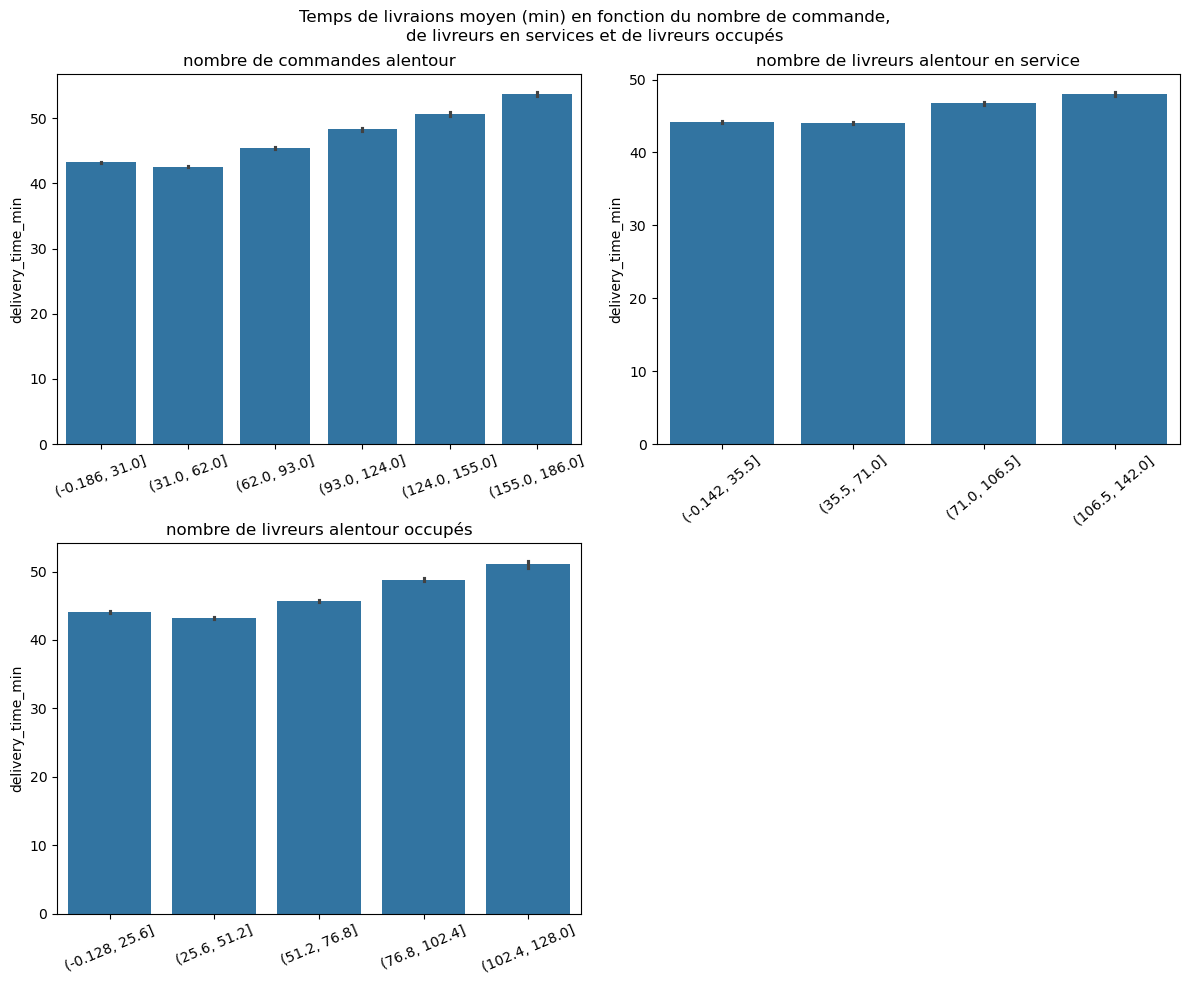

In [47]:
plt.figure(figsize=(12,10))
plt.suptitle("Temps de livraions moyen (min) en fonction du nombre de commande,\nde livreurs en services et de livreurs occupés")

plt.subplot(221)
sns.barplot(x =pd.cut(df_new.total_outstanding_orders,bins = 6), y=df_new.delivery_time_min)
plt.title("nombre de commandes alentour")
plt.xticks(rotation = 20)
plt.xlabel("")

plt.subplot(222)
sns.barplot(x =pd.cut(df_new.total_onshift_dashers,bins = 4), y=df_new.delivery_time_min)
plt.title("nombre de livreurs alentour en service")
plt.xticks(rotation = 40)
plt.xlabel("")


plt.subplot(223)
sns.barplot(x =pd.cut(df_new.total_busy_dashers,bins = 5), y=df_new.delivery_time_min)
plt.title("nombre de livreurs alentour occupés")
plt.xticks(rotation = 23)
plt.xlabel("")
plt.tight_layout();

<span style="font-size:15px">
En découpant le nombre de commandes et les infos sur le nombre de livreurs dispo : le temps de livraison augmente avec les trois variables
</span>



<span style="font-size:15px">
Deuxième découpe en faisant des groupes de tailles identiques
</span>


In [54]:
# avec des tailles de groupes égaux 
display(df_new.groupby(pd.qcut(df_new.total_outstanding_orders,q = 6),observed=True)["delivery_time"].describe())

display(df_new.groupby(pd.qcut(df_new.total_onshift_dashers,q = 6),observed=True)["delivery_time"].describe())

display(df_new.groupby(pd.qcut(df_new.total_busy_dashers,q = 6),observed=True)["delivery_time"].describe())


count         mean         std    min     25%  \
total_outstanding_orders                                                    
(-0.001, 11.0]            27786.0  2628.573634  897.939136  386.0  1957.0   
(11.0, 22.0]              23859.0  2572.857287  862.887308  542.0  1941.0   
(22.0, 38.0]              25953.0  2575.192964  868.806925  470.0  1943.0   
(38.0, 62.0]              25004.0  2546.498760  831.995079  223.0  1944.0   
(62.0, 99.0]              25437.0  2746.639777  839.289434  325.0  2133.0   
(99.0, 186.0]             25419.0  3027.743420  808.911707  386.0  2434.0   

                             50%     75%     max  
total_outstanding_orders                          
(-0.001, 11.0]            2479.0  3167.0  5279.0  
(11.0, 22.0]              2435.0  3074.0  5277.0  
(22.0, 38.0]              2434.0  3088.0  5278.0  
(38.0, 62.0]              2425.0  3010.0  5277.0  
(62.0, 99.0]              2632.0  3255.0  5279.0  
(99.0, 186.0]             2932.0  3542.0  5279.0

count         mean         std    min     25%  \
total_onshift_dashers                                                    
(-0.001, 12.0]         27006.0  2749.119936  922.899779  386.0  2052.0   
(12.0, 22.0]           24186.0  2634.042917  875.791881  406.0  1988.0   
(22.0, 36.0]           25838.0  2560.421550  858.390305  515.0  1934.0   
(36.0, 53.0]           25485.0  2602.630881  857.547404  429.0  1981.0   
(53.0, 78.0]           25669.0  2705.784916  858.203412  223.0  2074.0   
(78.0, 142.0]          25274.0  2843.624476  801.795458  386.0  2272.0   

                          50%      75%     max  
total_onshift_dashers                           
(-0.001, 12.0]         2608.0  3344.00  5279.0  
(12.0, 22.0]           2501.5  3154.00  5277.0  
(22.0, 36.0]           2426.5  3059.00  5279.0  
(36.0, 53.0]           2472.0  3104.00  5279.0  
(53.0, 78.0]           2586.0  3231.00  5279.0  
(78.0, 142.0]          2758.0  3334.75  5279.0

count         mean         std    min     25%     50%  \
total_busy_dashers                                                            
(-0.001, 9.0]       26443.0  2698.897894  916.812548  406.0  2010.0  2552.0   
(9.0, 19.0]         26952.0  2612.054653  872.657446  386.0  1973.0  2482.0   
(19.0, 31.0]        24550.0  2572.456578  867.782782  470.0  1942.0  2429.0   
(31.0, 47.0]        25195.0  2599.399484  845.631312  321.0  1984.0  2479.0   
(47.0, 67.0]        24980.0  2707.497118  855.808110  223.0  2080.0  2586.0   
(67.0, 128.0]       25338.0  2909.166548  804.524299  386.0  2328.0  2822.5   

                       75%     max  
total_busy_dashers                  
(-0.001, 9.0]       3274.0  5279.0  
(9.0, 19.0]         3128.0  5277.0  
(19.0, 31.0]        3076.0  5279.0  
(31.0, 47.0]        3093.0  5279.0  
(47.0, 67.0]        3226.0  5279.0  
(67.0, 128.0]       3409.0  5279.0

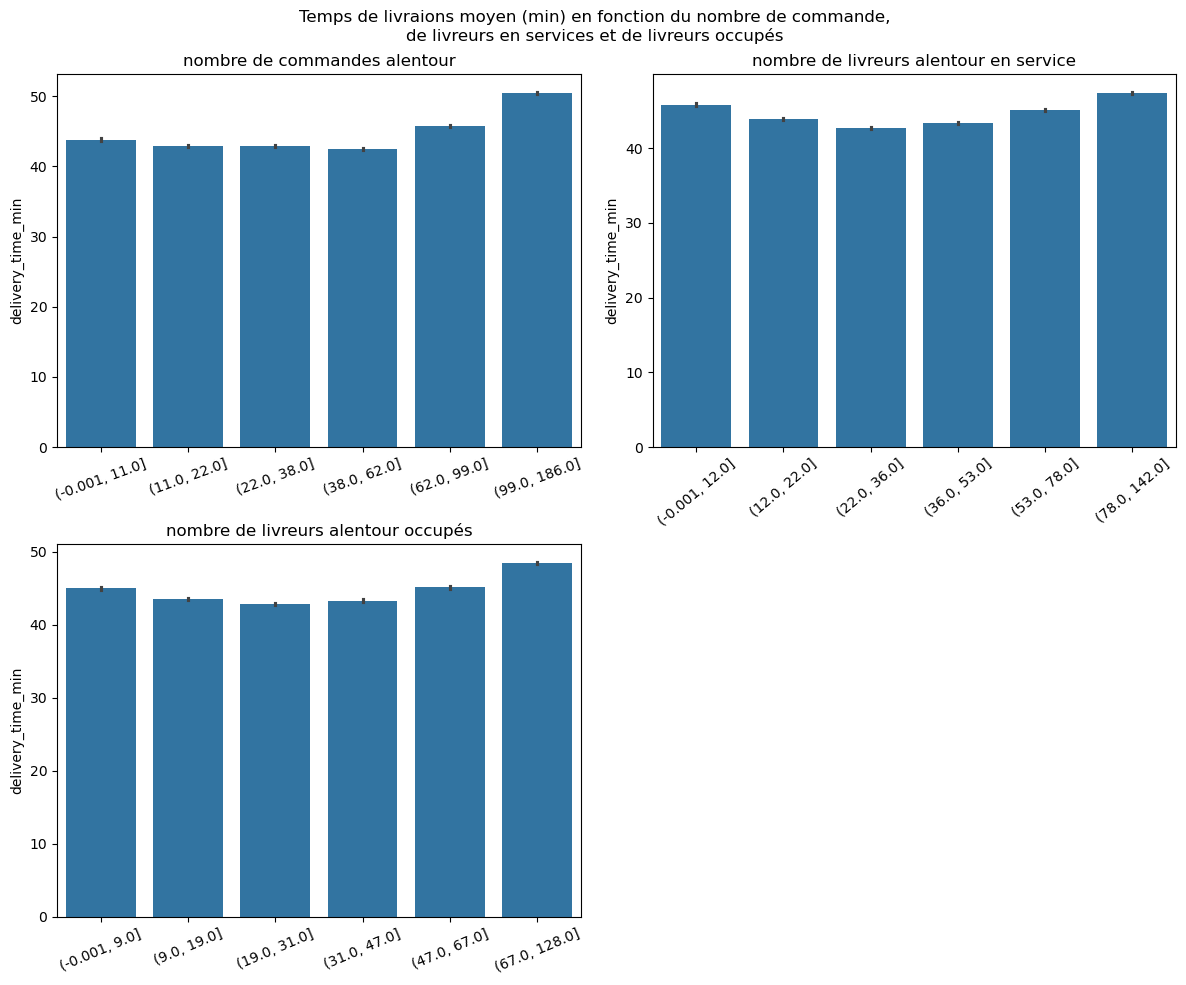

In [48]:
plt.figure(figsize=(12,10))
plt.suptitle("Temps de livraions moyen (min) en fonction du nombre de commande,\nde livreurs en services et de livreurs occupés")

plt.subplot(221)
sns.barplot(x =pd.qcut(df_new.total_outstanding_orders,q = 6), y=df_new.delivery_time_min)
plt.title("nombre de commandes alentour")
plt.xlabel("")
plt.xticks(rotation = 20)

plt.subplot(222)
sns.barplot(x =pd.qcut(df_new.total_onshift_dashers,q = 6), y=df_new.delivery_time_min)
plt.title("nombre de livreurs alentour en service")
plt.xlabel("")
plt.xticks(rotation = 40)

plt.subplot(223)
sns.barplot(x =pd.qcut(df_new.total_busy_dashers,q = 6), y=df_new.delivery_time_min)
plt.title("nombre de livreurs alentour occupés")
plt.xlabel("")
plt.xticks(rotation = 23)
plt.tight_layout();

<span style="font-size:15px">

En découpant les les variables en bins de taille égales.
- nombre de commandes alentours : moins de différences entre les groupes dans les temps de commandes. entre 0 et 62 commandes. Augmentation un peu plus significatives avec le reste 
- nombre de livreurs en service : concave (temps de livraison "haut", diminue puis remonte)
- nombre de livreur occupé : même observation

</span>

##### **Infos sur la commande**

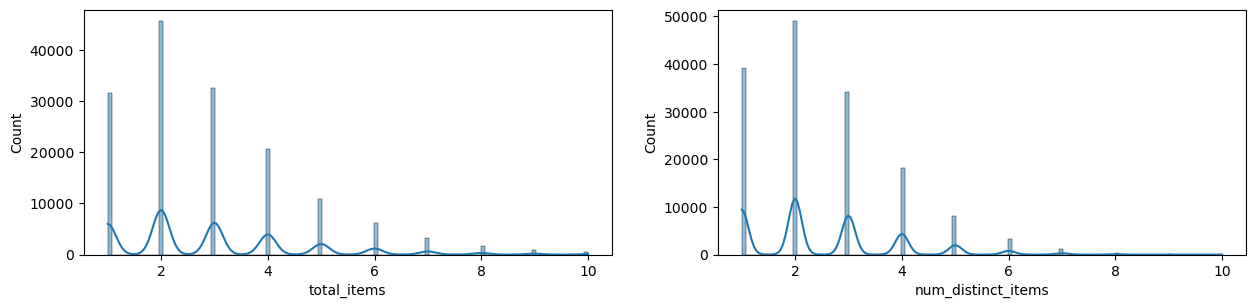

In [50]:
plt.figure(figsize=(15,7))
plt.subplot(221)
sns.histplot(x="total_items", kde=True,data = df_new)
plt.subplot(222)

sns.histplot(x="num_distinct_items", kde=True,data = df_new);


In [51]:
df_new.total_items.value_counts()

total_items
2     45581
3     32589
1     31493
4     20563
5     10813
6      6167
7      3179
8      1625
9       916
10      532
Name: count, dtype: int64

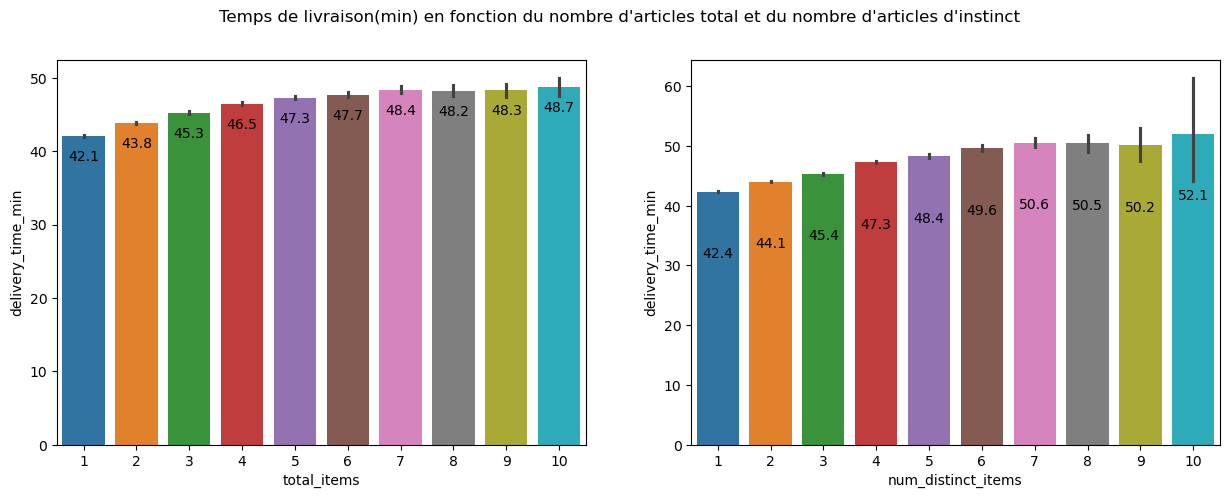

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

plt.suptitle("Temps de livraison(min) en fonction du nombre d'articles total et du nombre d'articles d'instinct")

br1 = sns.barplot(y = "delivery_time_min", x = "total_items", data = df_new, hue = "total_items" 
            ,palette=sns.color_palette(), legend = False,ax=ax1)
# ajout de temps moyen dans les barres
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",padding=-20)

br2 = sns.barplot(y = "delivery_time_min", x = "num_distinct_items", data = df_new, hue = "num_distinct_items" 
            ,palette=sns.color_palette(), legend = False,ax=ax2)
for container in br2.containers :
    br2.bar_label(container, fmt="%.1f",padding=-50)



<span style="font-size:15px">
Le temps de livraison augmente légérement en fonction de la taille de la commande. Le temps est d'autant plus important (et variables) si ce sont des articles différents  
(Mais forte disparité dans la distribution du nombre d'items)
</span>

<Axes: xlabel='total_items', ylabel='subtotal'>

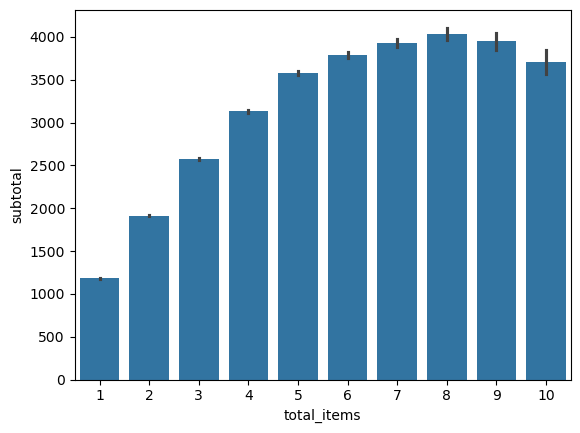

In [138]:
sns.barplot(y=df_new["subtotal"],x=df_new["total_items"]);

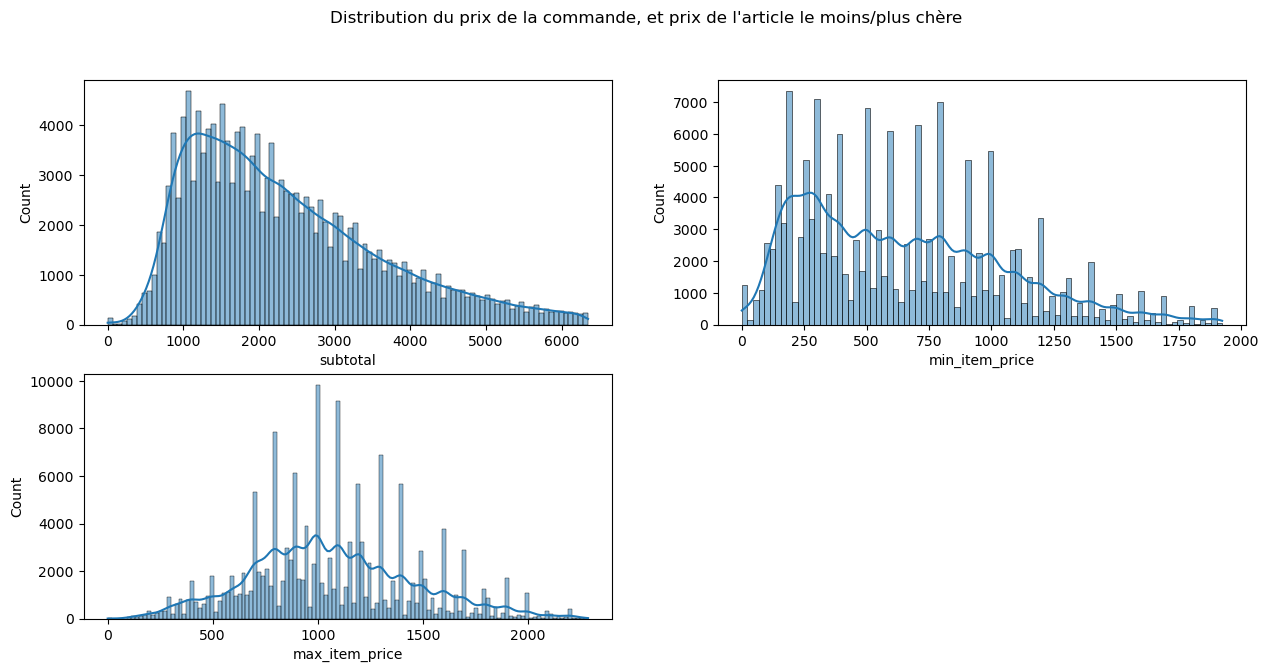

In [53]:
plt.figure(figsize=(15,7))
plt.subplot(221)
sns.histplot(x="subtotal", kde=True,data = df_new)
plt.subplot(222)

sns.histplot(x="min_item_price", kde=True,data = df_new)
plt.subplot(223)
sns.histplot(x="max_item_price", kde=True,data = df_new)

plt.suptitle("Distribution du prix de la commande, et prix de l'article le moins/plus chère");

##### **Durées d'étapes de commande**

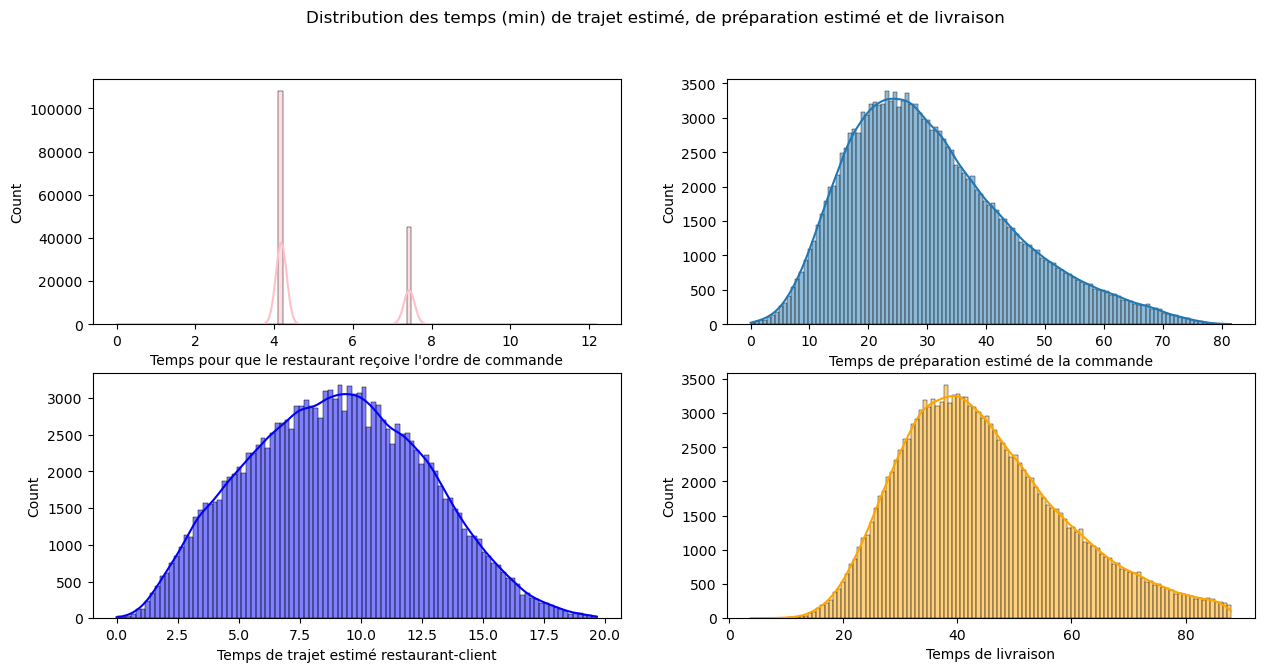

In [54]:
plt.figure(figsize=(15,7))
plt.suptitle("Distribution des temps (min) de trajet estimé, de préparation estimé et de livraison");

plt.subplot(221)
sns.histplot(x=df_new["estimated_order_place_duration"]/60, kde=True,data = df_new,color="pink")
plt.xlabel("Temps pour que le restaurant reçoive l'ordre de commande")

plt.subplot(222)
sns.histplot(x="estimated_prep_time_min", kde=True,data = df_new)
plt.xlabel("Temps de préparation estimé de la commande")

plt.subplot(223)
sns.histplot(x=df_new["estimated_store_to_consumer_driving_duration"]/60, kde=True,data = df_new,color="blue")
plt.xlabel("Temps de trajet estimé restaurant-client")


plt.subplot(224)
sns.histplot(x="delivery_time_min", kde=True,data = df_new,color="orange")
plt.xlabel("Temps de livraison")

plt.show()


<span style="font-size:15px">

En grande majorité, les restaurants mettent 4min pour recevoir l'ordre de commande.Suivit par environ 7min.     
Le temps de préparation est majoritairement entre 20-30 minutes.  
Le temps de trajet est majoritairement entre 6-11 minutes.  
Le temps de livraison total est majoritairement entre 30-50 minutes  
Le temps de préparation par le restaurant est l'étape qui prends le plus de temps dans le temps de livraison
</span>

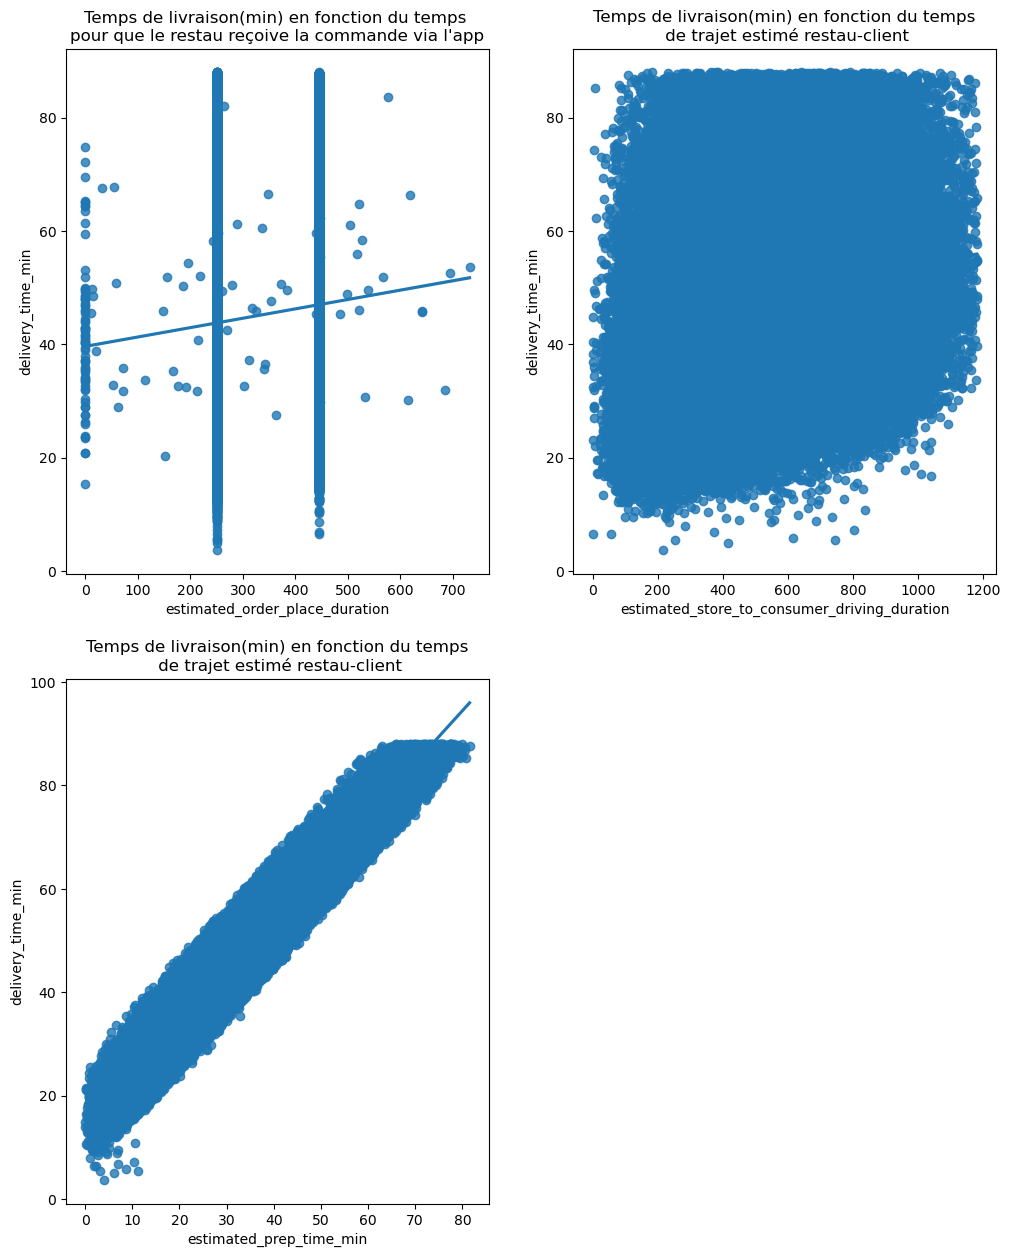

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.regplot(x=df_new["estimated_order_place_duration"],y=df_new["delivery_time_min"])
plt.title("Temps de livraison(min) en fonction du temps \npour que le restau reçoive la commande via l'app")

plt.subplot(222)
sns.regplot(x=df_new["estimated_store_to_consumer_driving_duration"],y=df_new["delivery_time_min"])
plt.title("Temps de livraison(min) en fonction du temps\n de trajet estimé restau-client");

plt.subplot(223)
sns.regplot(x=df_new["estimated_prep_time_min"],y=df_new["delivery_time_min"])
plt.title("Temps de livraison(min) en fonction du temps\n de trajet estimé restau-client");

<span style="font-size:15px">
Découpe des 3 variables pour avoir une meilleur visibilité

</span>

In [ ]:
display(df_new.groupby(pd.cut(df_new.estimated_order_place_duration,bins = 5),observed=True)["delivery_time"].describe())
# taille des bins tres différentes

# temps de préparation
# val max =80min donc vise bins de 10mins environ
# bin de environ 25 pour le nombre de dasher occupé
display(df_new.groupby(pd.cut(df_new.estimated_prep_time,bins = 8),observed=True)["delivery_time"].describe())

# temps de trajet
# val max =20 donc bins de 4-5 mins
# bin de environ 4 min pour le temps de trajet restau-client
display(df_new.groupby(pd.cut(df_new.estimated_store_to_consumer_driving_duration,bins = 5),observed=True)["delivery_time"].describe())


count         mean         std     min  \
estimated_order_place_duration                                              
(-0.732, 146.4]                     88.0  2550.000000  769.840378   918.0   
(146.4, 292.8]                  108119.0  2625.947771  851.955817   223.0   
(292.8, 439.2]                      13.0  2753.384615  702.534286  1655.0   
(439.2, 585.6]                   45231.0  2820.274856  893.810630   386.0   
(585.6, 732.0]                       7.0  2797.142857  759.597136  1806.0   

                                    25%     50%      75%     max  
estimated_order_place_duration                                    
(-0.732, 146.4]                 2023.25  2484.5  2910.25  4491.0  
(146.4, 292.8]                  2004.00  2507.0  3134.00  5279.0  
(292.8, 439.2]                  2194.00  2783.0  3039.00  3992.0  
(439.2, 585.6]                  2148.00  2705.0  3390.00  5279.0  
(585.6, 732.0]                  2331.00  2754.0  3190.50  3977.0

count         mean         std     min     25%     50%  \
estimated_prep_time                                                             
(-3.89, 612.25]       5324.0  1311.447784  261.376940   223.0  1129.0  1312.0   
(612.25, 1223.5]     33624.0  1807.961456  285.922814   325.0  1606.0  1809.0   
(1223.5, 1834.75]    47080.0  2367.927485  290.626934  1544.0  2163.0  2366.0   
(1834.75, 2446.0]    34132.0  2963.957137  293.027021  2123.0  2756.0  2958.0   
(2446.0, 3057.25]    18820.0  3581.122370  290.766463  2760.0  3375.0  3577.0   
(3057.25, 3668.5]     9464.0  4199.454565  291.057767  3371.0  3996.0  4197.0   
(3668.5, 4279.75]     4285.0  4779.364761  259.763677  4008.0  4591.0  4790.0   
(4279.75, 4891.0]      729.0  5099.696845  130.987112  4630.0  5026.0  5129.0   

                        75%     max  
estimated_prep_time                  
(-3.89, 612.25]      1492.0  2150.0  
(612.25, 1223.5]     2010.0  2787.0  
(1223.5, 1834.75]    2570.0  3355.0  
(1834.75, 2446.0]    3165.0  4052.0  
(2446.0, 3057.25]    3781.0  4640.0  
(3057.25, 3668.5]    4400.0  5155.0  
(3668.5, 4279.75]    4978.0  5279.0  
(4279.75, 4891.0]    5202.0  5279.0

count         mean  \
estimated_store_to_consumer_driving_duration                         
(-1.181, 236.2]                               13373.0  2286.496074   
(236.2, 472.4]                                46519.0  2498.870870   
(472.4, 708.6]                                57406.0  2738.626102   
(708.6, 944.8]                                31441.0  2950.287968   
(944.8, 1181.0]                                4719.0  3170.716889   

                                                     std     min     25%  \
estimated_store_to_consumer_driving_duration                               
(-1.181, 236.2]                               851.132497   223.0  1665.0   
(236.2, 472.4]                                852.606319   297.0  1872.0   
(472.4, 708.6]                                842.125846   352.0  2112.0   
(708.6, 944.8]                                824.330419   325.0  2337.0   
(944.8, 1181.0]                               807.074969  1003.0  2563.5   

                                                 50%     75%     max  
estimated_store_to_consumer_driving_duration                          
(-1.181, 236.2]                               2140.0  2756.0  5279.0  
(236.2, 472.4]                                2362.0  2989.0  5279.0  
(472.4, 708.6]                                2608.0  3248.0  5279.0  
(708.6, 944.8]                                2832.0  3474.0  5279.0  
(944.8, 1181.0]                               3074.0  3710.0  5277.0

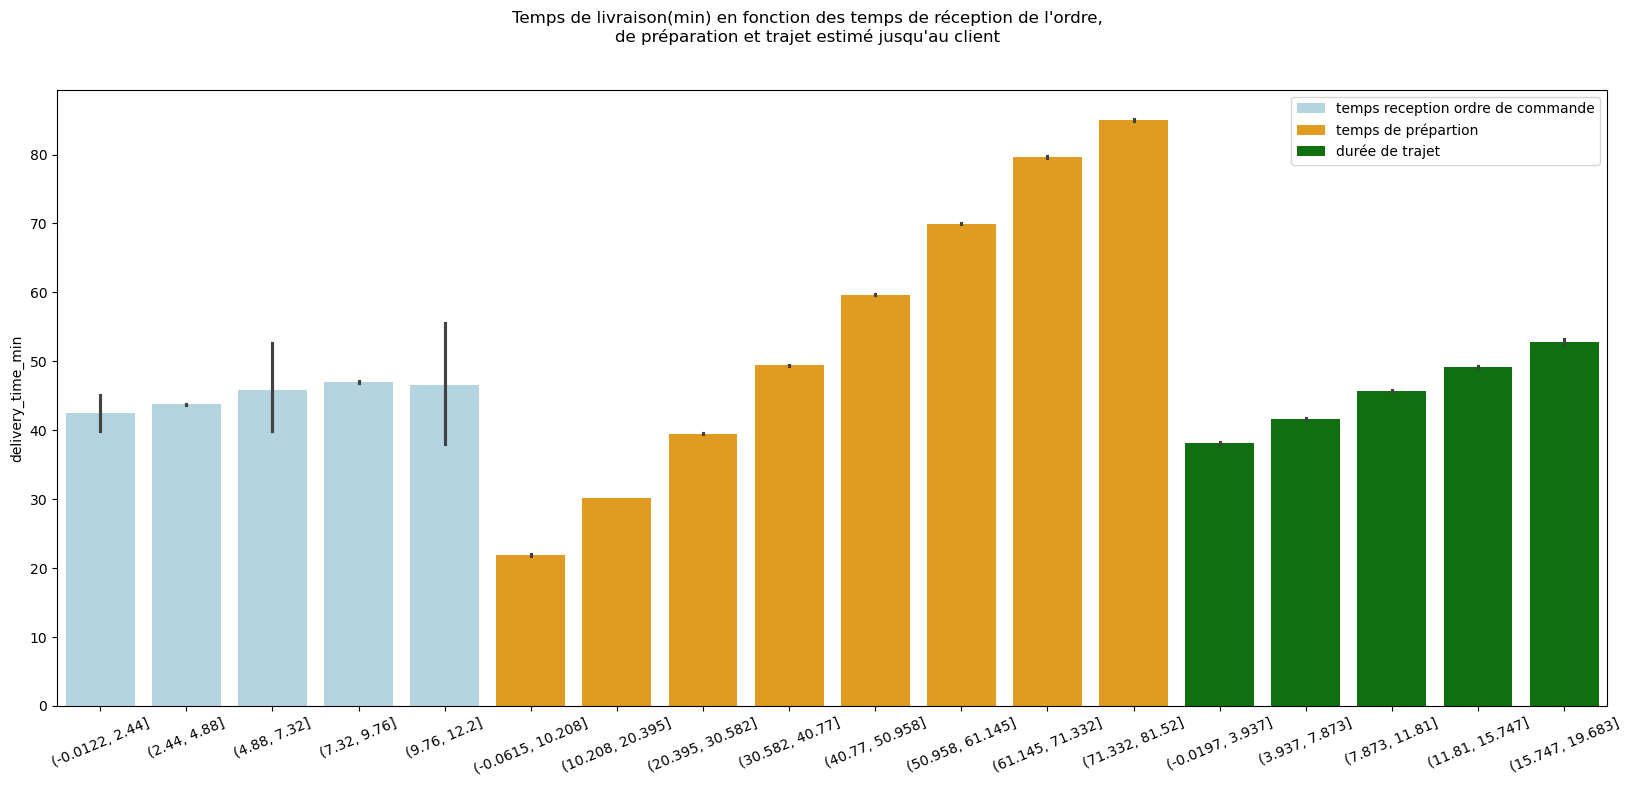

In [136]:
plt.figure(figsize=(20,8))
plt.suptitle("Temps de livraison(min) en fonction des temps de réception de l'ordre,\nde préparation et trajet estimé jusqu'au client")

sns.barplot(x =pd.cut((df_new.estimated_order_place_duration)/60,bins = 5), y=df_new.delivery_time_min
            , color = "lightblue",label ="temps reception ordre de commande" )
plt.xticks(rotation = 40)

sns.barplot(x =pd.cut(df_new.estimated_prep_time_min,bins = 8), y=df_new.delivery_time_min
            , color = "orange", label = "temps de prépartion")
plt.xticks(rotation = 23)


sns.barplot(x =pd.cut((df_new.estimated_store_to_consumer_driving_duration)/60,bins = 5), y=df_new.delivery_time_min
            ,color = "green", label = "durée de trajet")
plt.xticks(rotation = 23)

plt.xlabel("")
plt.legend();

In [144]:
display(df_new.groupby(pd.qcut(df_new.estimated_order_place_duration,q = 2),observed=True)["delivery_time"].describe())
# groupe le nombre de commandes par 30 environ

display(df_new.groupby(pd.qcut(df_new.estimated_prep_time_min,q = 7),observed=True)["delivery_time"].describe())
# bin de environ 25 pour le nombre de dasher occupé

display(df_new.groupby(pd.qcut((df_new.estimated_store_to_consumer_driving_duration)/60,q = 5),observed=True)["delivery_time"].describe())
# bin de environ 30 pour le nombre de dasher en service


count         mean         std    min  \
estimated_order_place_duration                                             
(-0.001, 251.0]                 108201.0  2625.840085  851.874292  223.0   
(251.0, 732.0]                   45257.0  2820.336081  893.743254  386.0   

                                   25%     50%     75%     max  
estimated_order_place_duration                                  
(-0.001, 251.0]                 2004.0  2507.0  3134.0  5279.0  
(251.0, 732.0]                  2148.0  2705.0  3390.0  5279.0

count         mean         std     min     25%  \
estimated_prep_time_min                                                     
(0.019, 16.33]           21954.0  1578.007835  296.853976   223.0  1377.0   
(16.33, 21.45]           21930.0  1981.798860  247.227587  1278.0  1802.0   
(21.45, 26.08]           21949.0  2270.811153  244.865176  1580.0  2093.0   
(26.08, 30.98]           21907.0  2552.859908  246.722869  1783.0  2376.0   
(30.98, 36.98]           21891.0  2879.962542  256.222872  2125.0  2695.0   
(36.98, 46.07]           21912.0  3326.370619  283.121913  2538.0  3124.0   
(46.07, 81.52]           21915.0  4195.930230  477.092129  3046.0  3832.0   

                            50%     75%     max  
estimated_prep_time_min                          
(0.019, 16.33]           1582.0  1787.0  2505.0  
(16.33, 21.45]           1978.0  2153.0  2849.0  
(21.45, 26.08]           2270.0  2442.0  3125.0  
(26.08, 30.98]           2549.0  2725.0  3421.0  
(30.98, 36.98]           2877.0  3058.0  3806.0  
(36.98, 46.07]           3321.0  3525.0  4288.0  
(46.07, 81.52]           4138.0  4532.0  5279.0

count         mean  \
estimated_store_to_consumer_driving_duration                         
(-0.001, 5.7]                                 30872.0  2362.078064   
(5.7, 7.983]                                  30713.0  2553.330967   
(7.983, 9.983]                                30514.0  2686.922855   
(9.983, 12.25]                                30733.0  2815.014447   
(12.25, 19.683]                               30626.0  3001.153987   

                                                     std    min      25%  \
estimated_store_to_consumer_driving_duration                               
(-0.001, 5.7]                                 854.692409  223.0  1732.00   
(5.7, 7.983]                                  849.225666  297.0  1932.00   
(7.983, 9.983]                                842.958627  516.0  2060.25   
(9.983, 12.25]                                835.394972  352.0  2192.00   
(12.25, 19.683]                               822.432760  325.0  2390.00   

                                                 50%     75%     max  
estimated_store_to_consumer_driving_duration                          
(-0.001, 5.7]                                 2224.5  2842.0  5279.0  
(5.7, 7.983]                                  2416.0  3046.0  5279.0  
(7.983, 9.983]                                2554.0  3188.0  5277.0  
(9.983, 12.25]                                2686.0  3325.0  5279.0  
(12.25, 19.683]                               2889.0  3528.0  5279.0

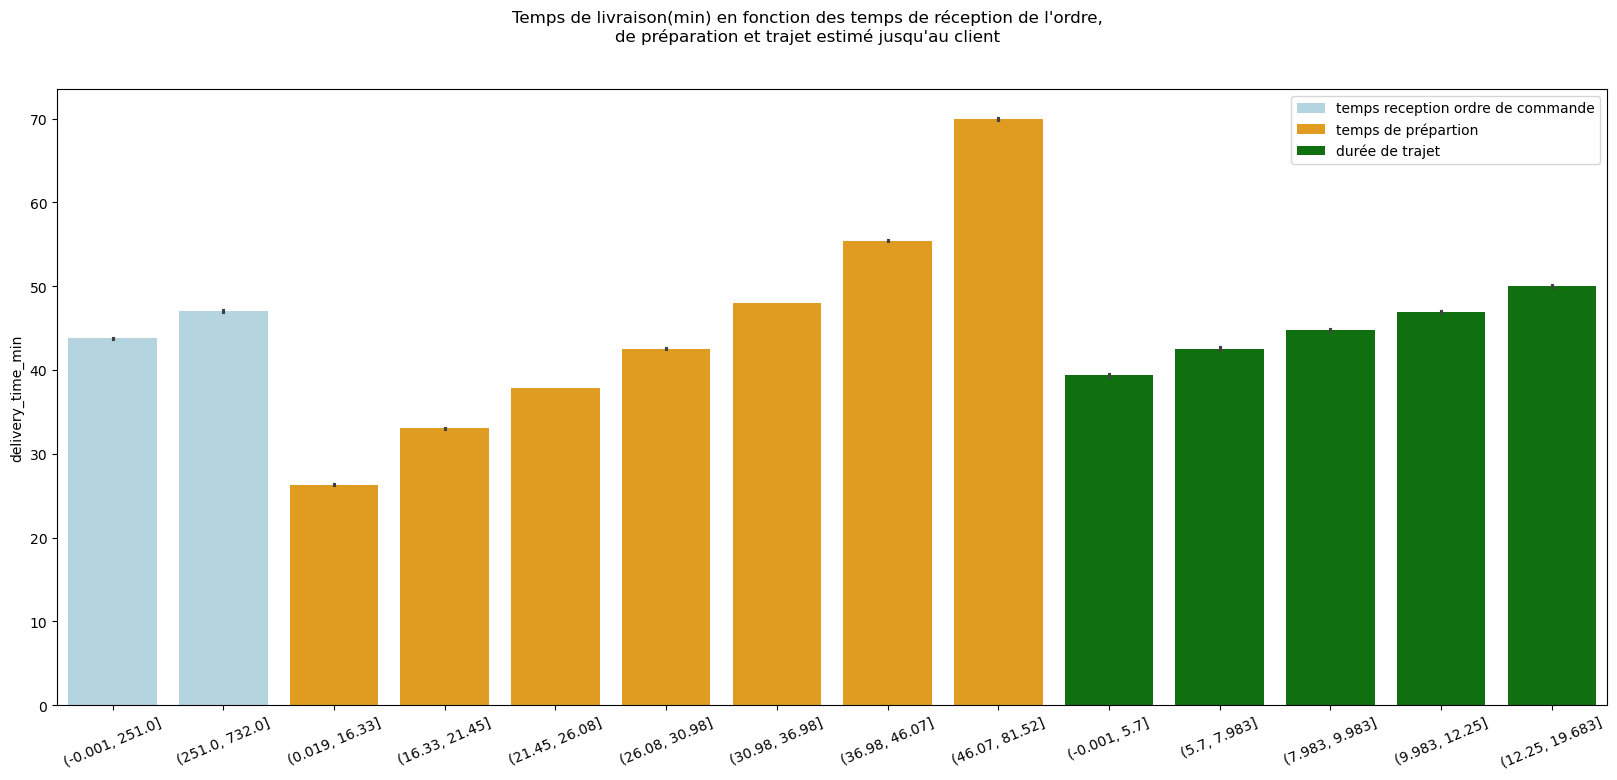

In [145]:
plt.figure(figsize=(20,8))
plt.suptitle("Temps de livraison(min) en fonction des temps de réception de l'ordre,\nde préparation et trajet estimé jusqu'au client")

sns.barplot(x =pd.qcut(df_new.estimated_order_place_duration,q = 2), y=df_new.delivery_time_min
            , color = "lightblue",label ="temps reception ordre de commande" )
plt.xticks(rotation = 40)

sns.barplot(x =pd.qcut((df_new.estimated_prep_time_min),q = 7), y=df_new.delivery_time_min
            , color = "orange", label = "temps de prépartion")
plt.xticks(rotation = 23)


sns.barplot(x =pd.qcut((df_new.estimated_store_to_consumer_driving_duration)/60,q = 5), y=df_new.delivery_time_min
            ,color = "green", label = "durée de trajet")
plt.xticks(rotation = 23)

plt.xlabel("")
plt.legend();

Le temps de préparation de la commande semble avoir la part la plus important dans le temps de livraison (plus grand écarts de temps de livraison entre les bins)

### **data engineering** 


<span style="font-size:15px">
Ajout de l'heure, le jour et mois de la commande
</span>

In [55]:
hour = df_new["created_at"].dt.hour
day = df_new["created_at"].dt.dayofweek
day_month = df_new["created_at"].dt.day
month = df_new["created_at"].dt.month

df_new.insert(loc = df_new.columns.get_loc("created_at")+1,column="order_hour",value= hour)
df_new.insert(loc = df_new.columns.get_loc("order_hour")+1,column="day",value= day)
df_new.insert(loc = df_new.columns.get_loc("day")+1,column="day_month",value= day_month)
df_new.insert(loc = df_new.columns.get_loc("day_month")+1,column="month",value= month)


df_new.head()

market_id          created_at  order_hour  day  day_month  month  \
0       1.0 2015-02-06 22:24:17          22    4          6      2   
1       2.0 2015-02-10 21:49:25          21    1         10      2   
2       3.0 2015-01-22 20:39:28          20    3         22      1   
4       3.0 2015-02-15 02:40:36           2    6         15      2   
5       3.0 2015-01-28 20:30:38          20    2         28      1   

  actual_delivery_time store_id store_primary_category order_protocol  ...  \
0  2015-02-06 23:27:16     1845               american            1.0  ...   
1  2015-02-10 22:56:29     5477                mexican            2.0  ...   
2  2015-01-22 21:09:09     5477                    NaN            1.0  ...   
4  2015-02-15 03:20:26     5477                    NaN            1.0  ...   
5  2015-01-28 21:08:58     5477                    NaN            1.0  ...   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    2.0                 1.0   
2            1900                    1.0                 0.0   
4            1600                    6.0                 6.0   
5            1900                    2.0                 2.0   

   total_outstanding_orders  estimated_order_place_duration  \
0                      21.0                             446   
1                       2.0                             446   
2                       0.0                             446   
4                       9.0                             446   
5                       2.0                             446   

   estimated_store_to_consumer_driving_duration  delivery_time  \
0                                         861.0         3779.0   
1                                         690.0         4024.0   
2                                         690.0         1781.0   
4                                         650.0         2390.0   
5                                         338.0         2300.0   

   delivery_time_min  estimated_prep_time  estimated_prep_time_min  
0              62.98               2472.0                    41.20  
1              67.07               2888.0                    48.13  
2              29.68                645.0                    10.75  
4              39.83               1294.0                    21.57  
5              38.33               1516.0                    25.27  

[5 rows x 24 columns]

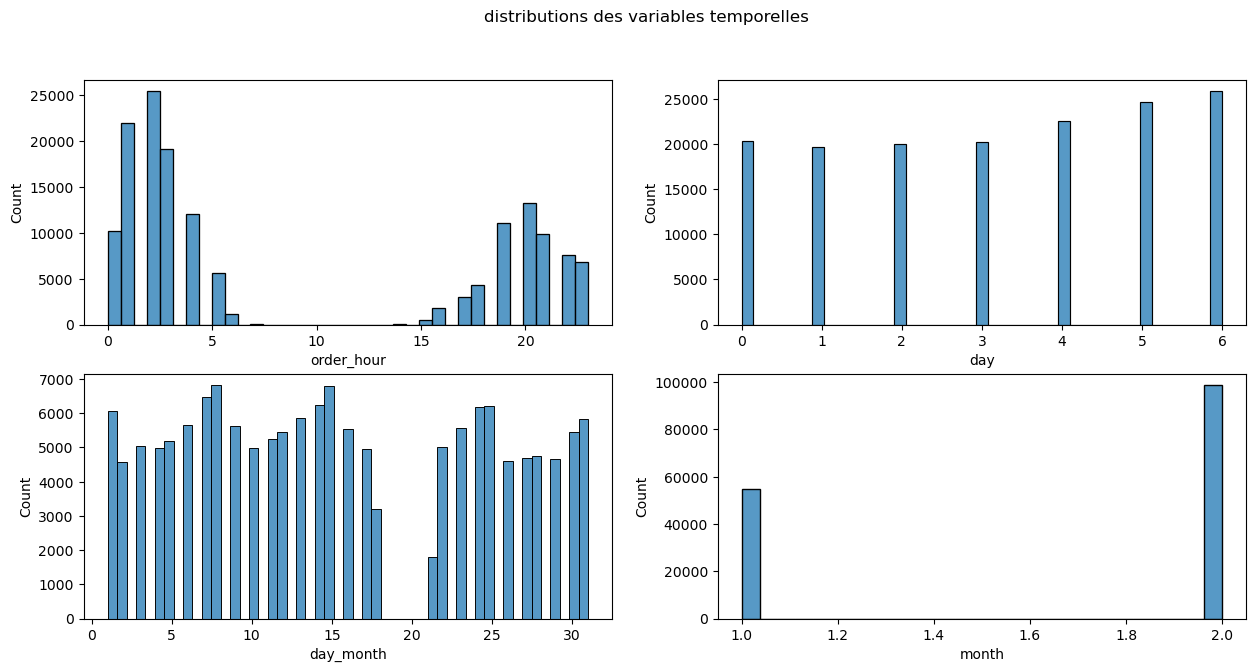

In [56]:
plt.figure(figsize=(15,7))
plt.subplot(221)
sns.histplot(df_new.order_hour)

plt.subplot(222)
sns.histplot(df_new.day)

plt.subplot(223)
sns.histplot(df_new.day_month)

plt.subplot(224)
sns.histplot(df_new.month)
plt.suptitle("distributions des variables temporelles");

<span style="font-size:15px">

Heures : Certaines heures ne sont pas représentées et il y de fortes disparité de distribution  
Jours : Distribution équilibrée  
Jour du mois : Distribution plutôt équilibrée avec quelques jours sous représentés ou absent  
Mois : Seul deux mois avec prévalence pour 2  

</span>

**Jour,mois et temps de livraison**

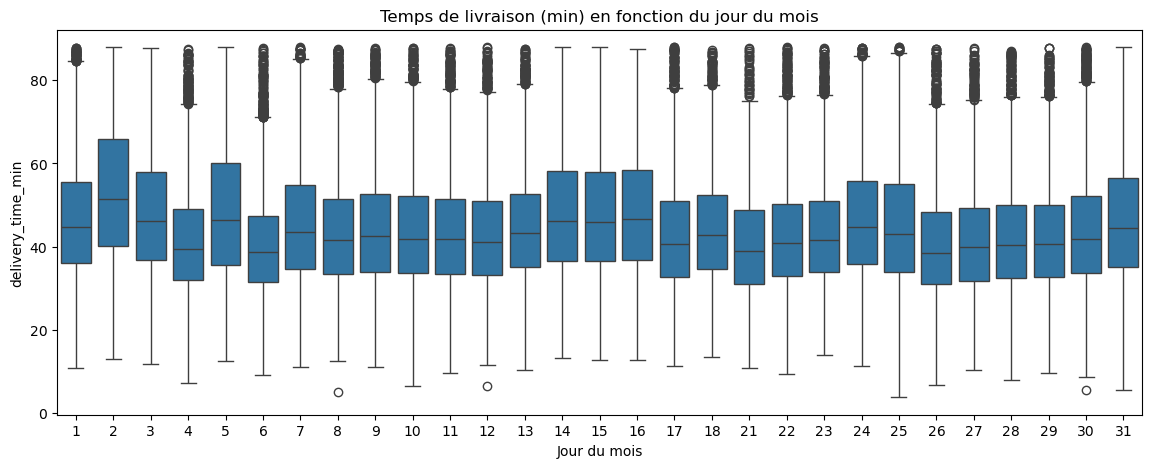

In [57]:
plt.figure(figsize=(14,5))
sns.boxplot(y= df_new.delivery_time_min,x= df_new.day_month);
plt.title("Temps de livraison (min) en fonction du jour du mois")
plt.xlabel("Jour du mois");


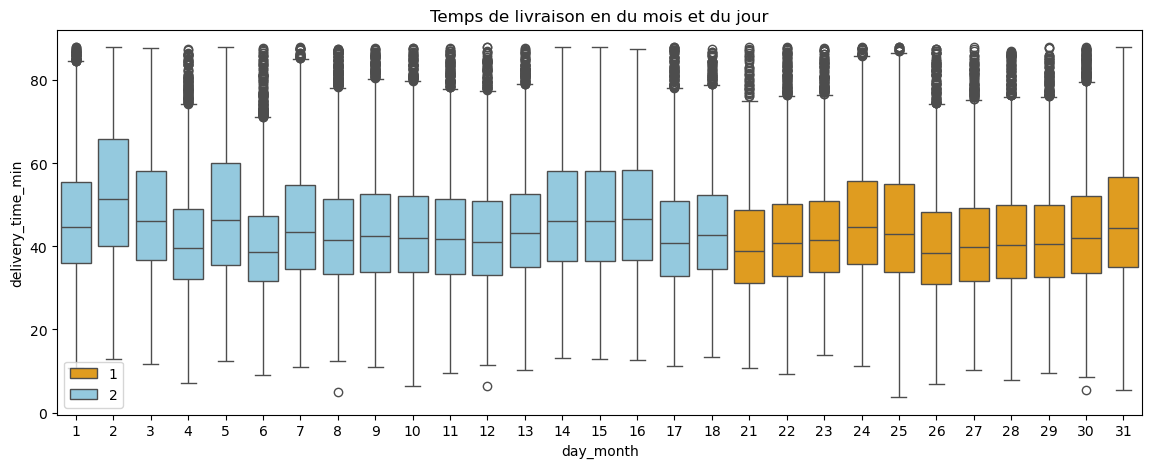

In [59]:
plt.figure(figsize=(14,5))
sns.boxplot(y= df_new.delivery_time_min,x= df_new.day_month, hue=df_new.month, palette = ["orange","skyblue"])
plt.title("Temps de livraison en du mois et du jour")
plt.legend(loc="lower left");

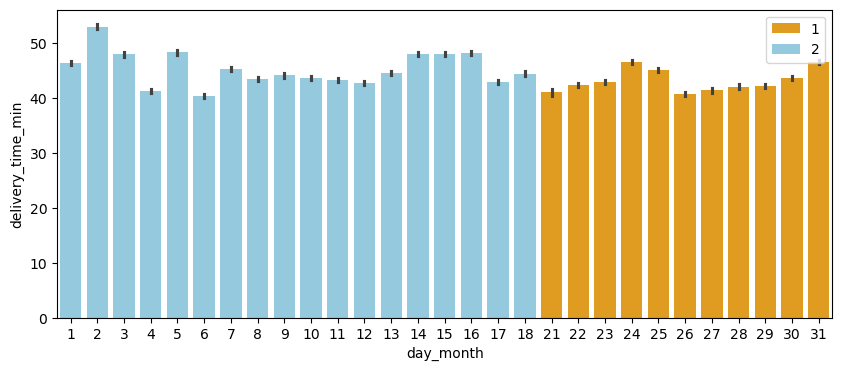

In [60]:
plt.figure(figsize=(10,4))
sns.barplot(y= df_new.delivery_time_min,x= df_new.day_month, hue=df_new.month, palette = ["orange","skyblue"])
plt.legend(loc = "upper right");

<span style="font-size:15px">

Il semble y avoir certaines différences dans les temps de livraison moyen en fonction du jour du mois (jusqu'à 10 pour la plus grande différence)

</span>

**Jours de la semaine et heures**

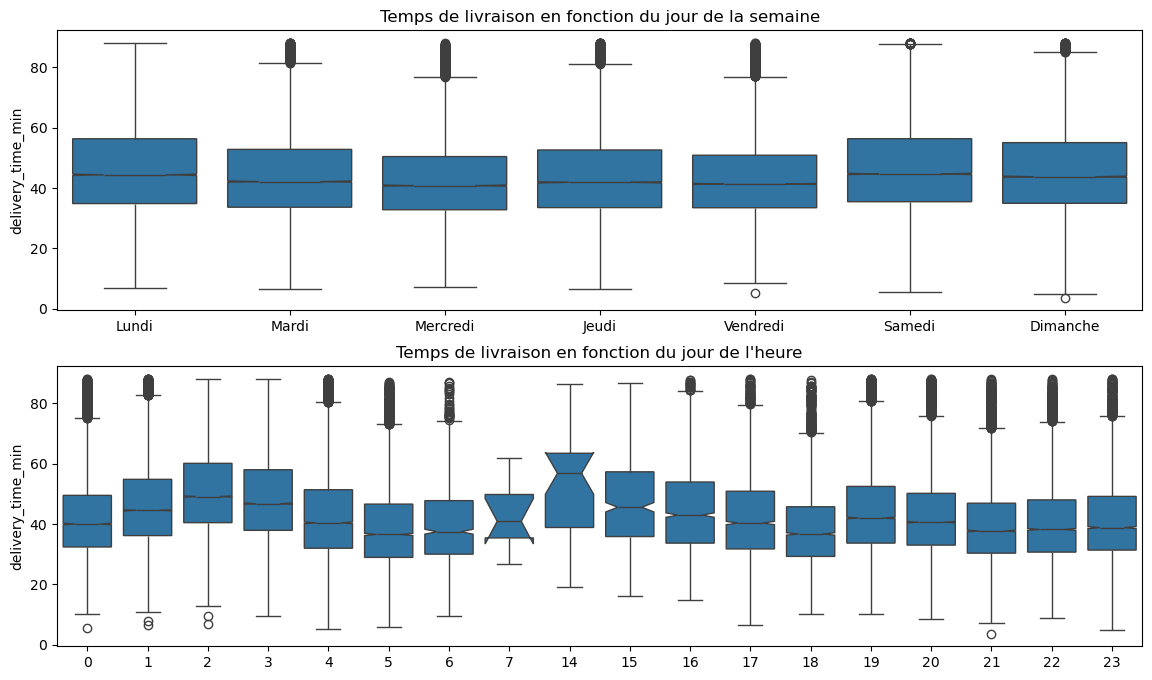

In [61]:

plt.figure(figsize=(14,8))

plt.subplot(211)
sns.boxplot(y= df_new.delivery_time_min,x= df_new.day,notch = True)
plt.xticks(ticks=np.arange(0,7) ,labels=["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"])
plt.title("Temps de livraison en fonction du jour de la semaine")
plt.xlabel("")

plt.subplot(212)
sns.boxplot(y= df_new.delivery_time_min,x= df_new.order_hour,notch = True)
plt.title("Temps de livraison en fonction du jour de l'heure")
plt.xlabel("");



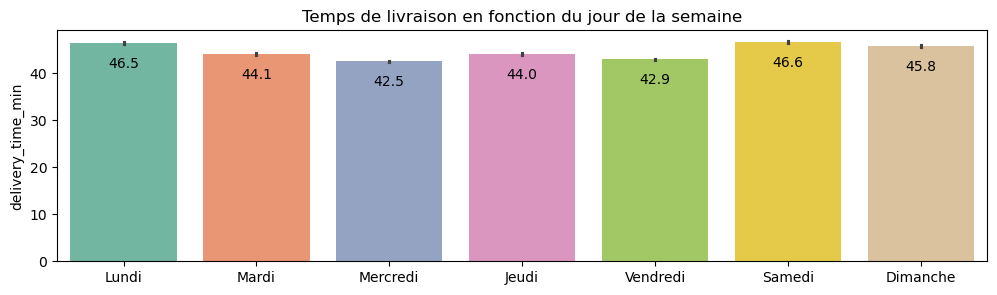

In [62]:

plt.figure(figsize=(12,3))
br1 = sns.barplot(y= df_new.delivery_time_min,x= df_new.day,hue=df_new.day, palette="Set2", legend = False)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",padding=-20)

plt.xticks(ticks=np.arange(0,7) ,labels=["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"])
plt.title("Temps de livraison en fonction du jour de la semaine")
plt.xlabel("");


<span style="font-size:15px">
Le temps de livraison moyen diffère peu (2-4 minutes) en fonction des jours. Samedi et lundi sont les jours avec les temps de livraison les plus long. Mercredi et jeudi ont les plus courts temps

</span>

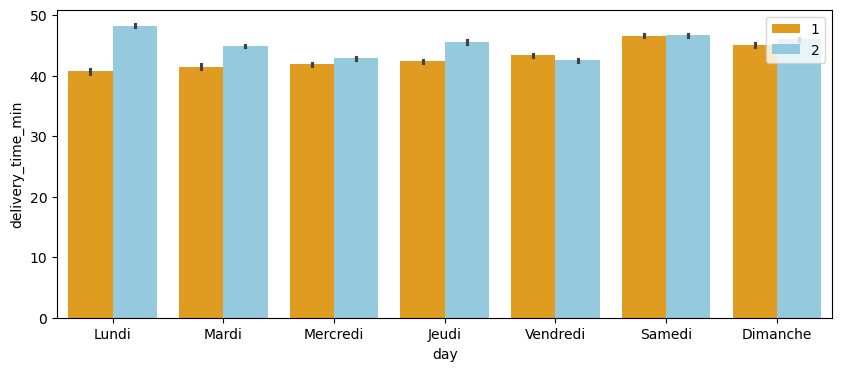

In [63]:
# en fonction du jour de la semaine et du mois

plt.figure(figsize=(10,4))
sns.barplot(y= df_new.delivery_time_min,x= df_new.day, hue=df_new.month, palette = ["orange","skyblue"])
plt.xticks(ticks=np.arange(0,7) ,labels=["Lundi","Mardi","Mercredi","Jeudi","Vendredi","Samedi","Dimanche"])
plt.legend(loc = "upper right");

In [65]:
df_new.groupby(["day_month","day"])["delivery_time"].agg(["count","mean"])

count         mean
day_month day                    
1         6     6057  2790.604260
2         0     4586  3181.936546
3         1     5040  2879.947817
4         2     4991  2479.328792
5         3     5176  2906.993045
6         4     5658  2423.541888
7         5     6468  2718.375696
8         6     6814  2608.000294
9         0     5633  2650.737263
10        1     4992  2621.289062
11        2     5231  2602.280252
12        3     5458  2568.117992
13        4     5854  2676.415442
14        5     6241  2884.168883
15        6     6784  2881.737028
16        0     5548  2897.268025
17        1     4941  2575.959118
18        2     3214  2667.148102
21        2     1810  2464.323204
22        3     5006  2548.023771
23        4     5568  2581.686422
24        5     6166  2792.736296
25        6     6216  2705.522040
26        0     4616  2443.934575
27        1     4677  2487.174257
28        2     4755  2527.900736
29        3     4656  2532.312285
30        4     5462  2623.617356
31        5     5840  2798.126884

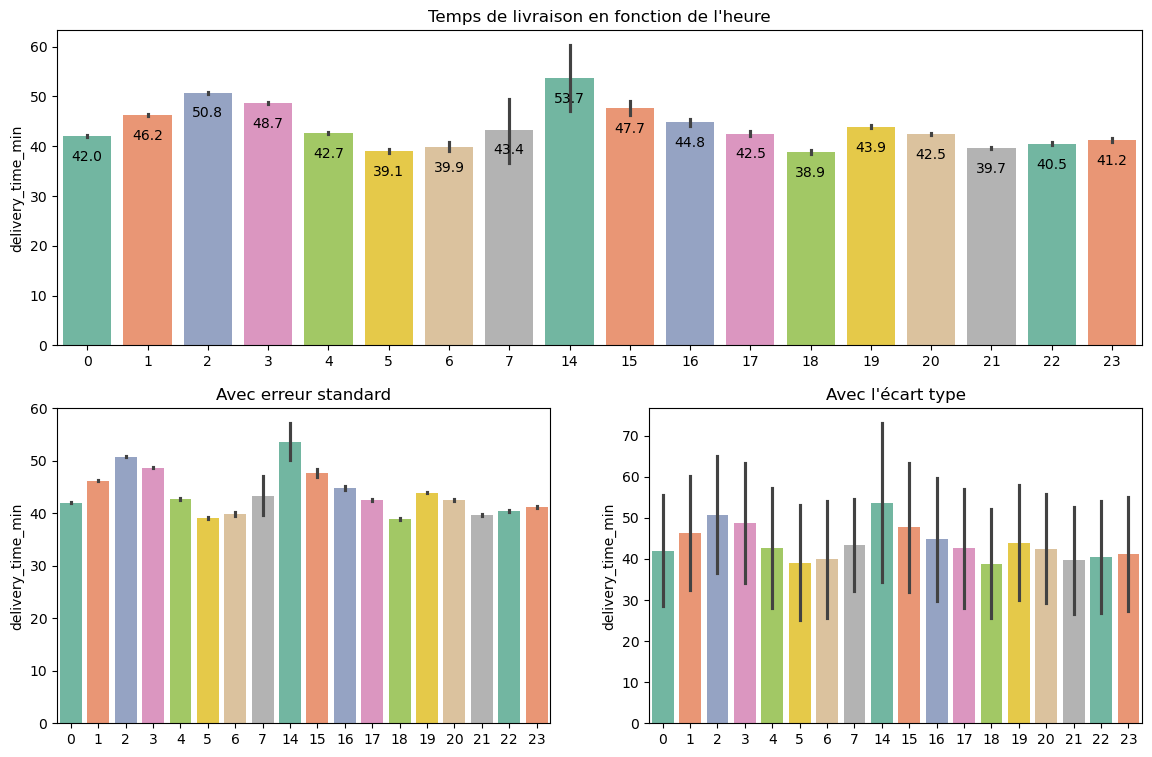

In [64]:
import matplotlib.gridspec as gridspec

fig =plt.figure(figsize=(14,9))

# pour avoir un plot qui prend toute la premiere ligne
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, :])
br1 = sns.barplot(y= df_new.delivery_time_min,x= df_new.order_hour,hue=df_new.order_hour, palette="Set2"
                  , legend = False, ax=ax1)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",padding=-20)

plt.title("Temps de livraison en fonction de l'heure")
plt.xlabel("")

ax2 = fig.add_subplot(gs[1, 0])
br1 = sns.barplot(y= df_new.delivery_time_min,x= df_new.order_hour,hue=df_new.order_hour
                  , palette="Set2", legend = False,errorbar="se", ax=ax2)

plt.title("Avec erreur standard")
plt.xlabel("")


ax3 = fig.add_subplot(gs[1, 1])
br2 = sns.barplot(y= df_new.delivery_time_min,x= df_new.order_hour, hue=df_new.order_hour
                  , palette="Set2", legend = False,errorbar="sd", ax=ax3)

plt.title("Avec l'écart type")
plt.xlabel("")
plt.show()

In [ ]:
# temps de livraison en fcontion de l'heure
df_new.groupby("order_hour")["delivery_time_min"].describe()

count       mean        std    min     25%    50%     75%    max
order_hour                                                                    
0           10202.0  42.026463  13.494298   5.42  32.380  39.98  49.465  87.98
1           21892.0  46.247030  13.856689   6.43  36.150  44.50  54.770  87.95
2           25386.0  50.770950  14.165940   6.77  40.430  49.08  60.065  87.98
3           19074.0  48.664932  14.571331   9.58  37.880  46.70  57.945  87.97
4           12045.0  42.698848  14.574322   5.35  31.970  40.35  51.330  87.98
5            5658.0  39.068526  14.054285   5.87  28.930  36.51  46.570  87.10
6            1147.0  39.892345  14.160858   9.38  30.000  37.43  47.715  87.10
7               9.0  43.353333  11.198634  26.65  35.380  40.88  49.750  61.67
14             31.0  53.678387  19.333301  19.20  38.830  56.77  63.400  86.37
15            459.0  47.670022  15.683498  16.20  35.825  45.53  57.255  86.50
16           1853.0  44.771808  14.911728  14.95  33.650  42.93  53.880  87.75
17           2989.0  42.542633  14.429085   6.43  31.730  40.30  50.830  87.98
18           4311.0  38.862723  13.242942  10.27  29.260  36.68  45.690  87.70
19          11047.0  43.928358  13.996764  10.17  33.660  41.97  52.420  87.92
20          13188.0  42.525600  13.296027   8.58  33.000  40.58  50.130  87.95
21           9806.0  39.682512  13.065578   3.72  30.330  37.67  46.870  87.92
22           7527.0  40.457360  13.525736   9.03  30.680  38.18  47.970  87.83
23           6834.0  41.246588  13.804693   4.95  31.350  38.78  49.120  87.95

<span style="font-size:15px">

Heures : En fonction de l'heure la journée, le temps de livraison varie avec des différence allant jusqu'à 10 minutes.    
Mais certaines heures sont sous représentées (7,14 et 15 en dessous de 1000 comptes...) donc pas forcément fiables (plus grande erreur standard)

</span>

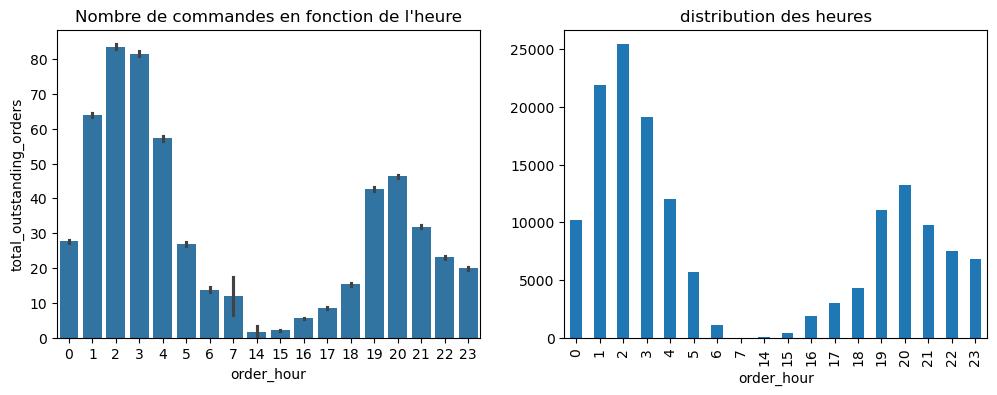

In [72]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sns.barplot(y="total_outstanding_orders", x="order_hour", data =df_new)
plt.title("Nombre de commandes en fonction de l'heure")

plt.subplot(122)
df_new["order_hour"].value_counts().sort_index().plot(kind = "bar",title =  "distribution des heures");

<span style="font-size:15px">

Ajout de :  
- nombre livreurs disponibles dans les 10 miles (~16km) autour de la commande
- proportion de livreurs disponibles
- temps de non préparation de la commande (temps de livraison + temps pour que le restaurant reçoive la commande) en secondes
</span>

In [65]:
# nombre de dashers disponibles dans les 10 miles de la commande
available_dashers = df_new["total_onshift_dashers"]-df_new["total_busy_dashers"]
df_new.insert(loc = df_new.columns.get_loc("total_busy_dashers")+1,column="available_dashers",value= available_dashers)

#prop de dasher disponibles
prop_available_dashers= df_new["available_dashers"]/df_new["total_onshift_dashers"]
df_new.insert(loc = df_new.columns.get_loc("available_dashers")+1,column="prop_available_dashers",value= prop_available_dashers)

# temps de non préparation (temps pour recevoir l'ordre livraion + temps de trajet)
df_new["non_prep_time"] = df_new["estimated_order_place_duration"] + df_new["estimated_store_to_consumer_driving_duration"]

In [66]:
df_new["prop_available_dashers"].describe()

count    150473.000000
mean          0.154405
std           0.171367
min           0.000000
25%           0.024390
50%           0.095238
75%           0.234568
max           1.000000
Name: prop_available_dashers, dtype: float64

**Proportion de livreurs disponibles aux alentours**

count         mean         std    min     25%  \
prop_available_dashers                                                     
(-0.001, 0.2]           106674.0  2764.717710  877.005053  223.0  2116.0   
(0.2, 0.4]               29462.0  2506.454620  807.376494  321.0  1928.0   
(0.4, 0.6]               10835.0  2376.521458  766.233455  470.0  1831.0   
(0.6, 0.8]                2559.0  2297.277843  784.515700  406.0  1737.0   
(0.8, 1.0]                 943.0  2448.552492  818.348964  718.0  1856.0   

                           50%     75%     max  
prop_available_dashers                          
(-0.001, 0.2]           2648.0  3312.0  5279.0  
(0.2, 0.4]              2396.0  2967.0  5278.0  
(0.4, 0.6]              2263.0  2815.0  5274.0  
(0.6, 0.8]              2185.0  2697.0  5270.0  
(0.8, 1.0]              2314.0  2948.0  5224.0

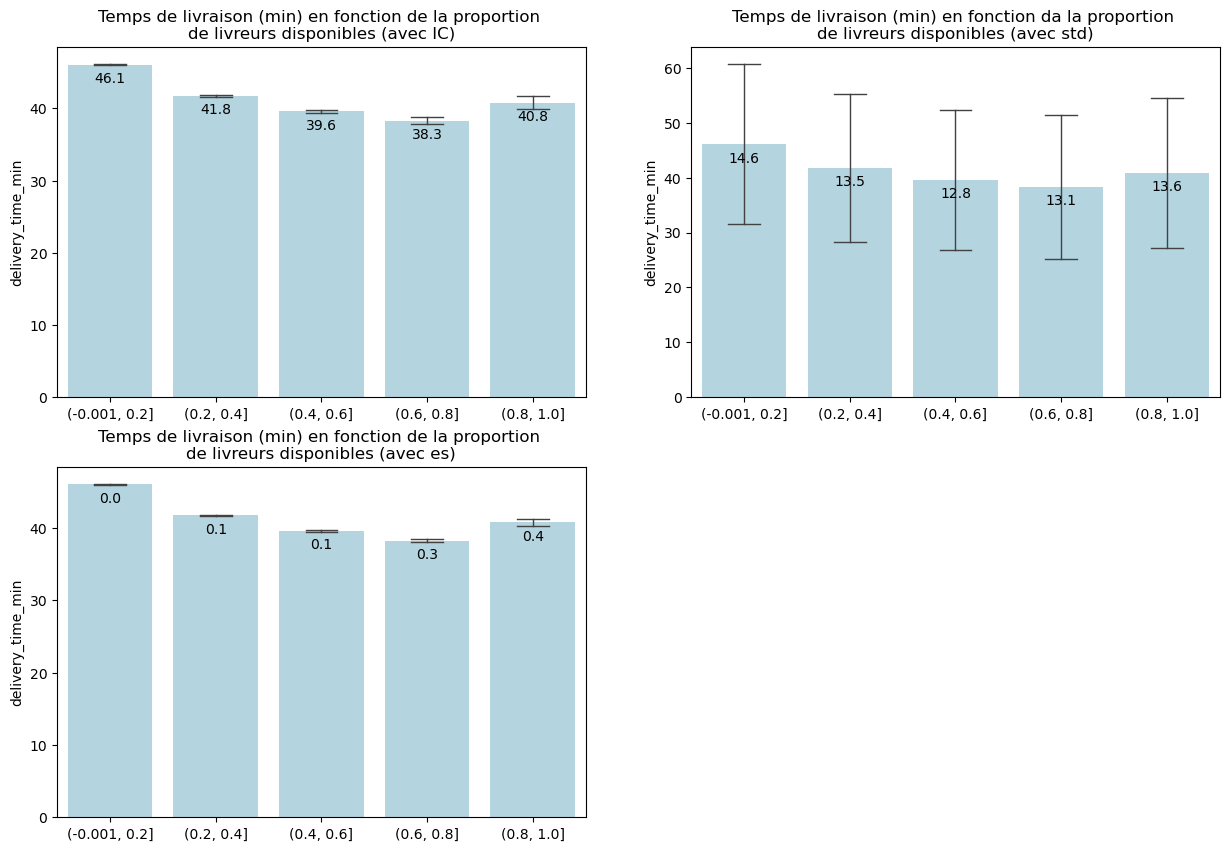

In [68]:
# groupe les proportionde livreurs dispo groupé par 20%

display(df_new.groupby(pd.cut(df_new.prop_available_dashers,bins = 5),observed=True)["delivery_time"].describe())

plt.figure(figsize=(15,10))

plt.subplot(221)
br = sns.barplot(x =pd.cut(df_new.prop_available_dashers,bins = 5), y=df_new.delivery_time_min
            , color = "lightblue",capsize=0.3,err_kws={'linewidth': 1})
plt.title("Temps de livraison (min) en fonction de la proportion \nde livreurs disponibles (avec IC)")
br.bar_label(br.containers[0], fmt="%.1f",padding=-15 )
plt.xlabel("")

plt.subplot(222)
br2 = sns.barplot(x =pd.cut(df_new.prop_available_dashers,bins = 5), y=df_new.delivery_time_min
            , color = "lightblue", errorbar="sd", capsize=0.3,err_kws={'linewidth': 1}
            )

br2.bar_label(br2.containers[0], fmt="%.1f",padding=-15
              ,labels=(df_new.groupby(pd.cut(df_new.prop_available_dashers,bins = 5),observed=True)["delivery_time"].std()/60).round(1))
plt.title("Temps de livraison (min) en fonction da la proportion \nde livreurs disponibles (avec std)");
plt.xlabel("")


plt.subplot(223)
br3 = sns.barplot(x =pd.cut(df_new.prop_available_dashers,bins = 5), y=df_new.delivery_time_min
            , color = "lightblue", errorbar="se", capsize=0.3,err_kws={'linewidth': 1}
            )
br3.bar_label(br3.containers[0], fmt="%.1f",padding=-15
              ,labels=(df_new.groupby(pd.cut(df_new.prop_available_dashers,bins = 5),observed=True)["delivery_time"].sem()/60).round(1))


plt.title("Temps de livraison (min) en fonction de la proportion \nde livreurs disponibles (avec es)")
plt.xlabel("");


<span style="font-size:15px">

Le temps de livraison moyen diminue avec avec l'augmentation de la proportion de livreurs disponible dans le secteur du restaurant. Légerement plus haut entre [0.8-1] (peut être dû à la faible taille du groupe)   
L'erreur standard va de 12 à 15 en fonction de la proportion (grande différence entre taille d'échantillon mais erreur standard assez similaires et IC de moyennes faibles, on peut que considérer que les résultats sont assez fiables sur les plus petits échantillons...)

</span>

count         mean         std    min      25%  \
prop_available_dashers                                                     
(0.0, 0.05]             26752.0  2842.955144  874.489734  325.0  2195.00   
(0.05, 0.15]            38435.0  2674.236295  850.261601  297.0  2056.00   
(0.15, 0.25]            24250.0  2580.244866  830.961096  223.0  1976.25   
(0.25, 0.35]            13867.0  2495.949665  800.487748  559.0  1920.00   
(0.35, 0.45]             8709.0  2424.158457  776.447095  583.0  1872.00   
(0.45, 0.55]             5516.0  2374.908811  771.933689  470.0  1824.75   
(0.55, 0.65]             2363.0  2288.671604  763.592040  406.0  1759.50   
(0.65, 0.75]             1500.0  2302.105333  788.200437  575.0  1742.50   
(0.75, 0.85]              486.0  2311.185185  810.549587  756.0  1750.00   
(0.85, 1.0]               766.0  2479.426893  818.550531  718.0  1888.25   

                           50%      75%     max  
prop_available_dashers                           
(0.0, 0.05]             2745.0  3404.00  5278.0  
(0.05, 0.15]            2560.0  3182.00  5279.0  
(0.15, 0.25]            2463.0  3063.00  5279.0  
(0.25, 0.35]            2389.0  2954.50  5278.0  
(0.35, 0.45]            2307.0  2879.00  5229.0  
(0.45, 0.55]            2265.0  2809.00  5274.0  
(0.55, 0.65]            2178.0  2679.00  5263.0  
(0.65, 0.75]            2176.5  2673.00  5270.0  
(0.75, 0.85]            2158.5  2762.25  5224.0  
(0.85, 1.0]             2380.5  2983.50  5222.0

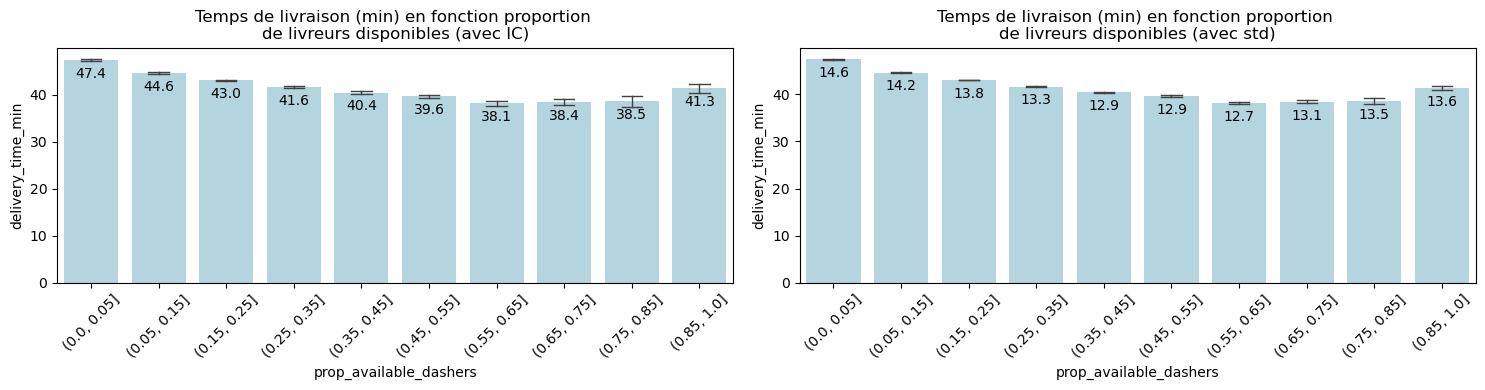

In [ ]:
# met à part les 0% car grande prévalence voir ce que ça donne
bi =[0,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,1]
display(df_new.groupby(pd.cut(df_new.prop_available_dashers,bins = bi),observed=True)["delivery_time"].describe())

plt.figure(figsize=(15,4))

plt.subplot(121)
br = sns.barplot(x =pd.cut(df_new.prop_available_dashers,bins = bi), y=df_new.delivery_time_min
            , color = "lightblue",capsize=0.3,err_kws={'linewidth': 1})
plt.title("Temps de livraison (min) en fonction proportion \nde livreurs disponibles (avec IC)")
plt.xticks(rotation=45)
br.bar_label(br.containers[0], fmt="%.1f",padding=-15 )

plt.subplot(122)
br2 = sns.barplot(x =pd.cut(df_new.prop_available_dashers,bins = bi), y=df_new.delivery_time_min
            , color = "lightblue", errorbar="se", capsize=0.3,err_kws={'linewidth': 1}
            )

br2.bar_label(br2.containers[0], fmt="%.1f",padding=-15
              ,labels=(df_new.groupby(pd.cut(df_new.prop_available_dashers,bins = bi),observed=True)["delivery_time"].std()/60).round(1))

plt.title("Temps de livraison (min) en fonction proportion \nde livreurs disponibles (avec std)")
plt.xticks(rotation=45)
plt.tight_layout();


**Nombre de commandes reçues par le restaurant**


<span style="font_size:10px">
Ajout du nombre de commande traité par le restaurant dans un laps de temps de 30,45 et 60 minutes précédant la commande n
</span>

In [90]:
# nombre de commande traité par le restaurant dans un laps de 30min/60min
# subset par restaurant, pour chaque ligne, compte le nb de lignes dans un laps de 30 min/60min avant
#compte le nombre de commandes traiter dans,30min,45min, 1hr, par un restaurant avec DD

count_30 = []
count_45 = []
count_60 = []

for ids, row in df_new.sort_values(by = ["store_id","created_at"]).iterrows() : 
    current_time = row["created_at"]
    store = row["store_id"]
    
    
    #30min
    time_window_start_30 = current_time - pd.Timedelta(minutes=30)
    count_in_window_30 = df_new[(df_new['store_id'] == store) & (df_new['created_at'] <= current_time) & (df_new['created_at'] > time_window_start_30)].shape[0]
    count_30.append(count_in_window_30)
    
    #45min
    time_window_start_45 = current_time - pd.Timedelta(minutes=45)
    count_in_window_45 = df_new[(df_new['store_id'] == store) & (df_new['created_at'] <= current_time) & (df_new['created_at'] > time_window_start_45)].shape[0]
    count_45.append(count_in_window_45)
    
    #60min
    time_window_start_60 = current_time - pd.Timedelta(minutes=60)
    count_in_window_60 = df_new[(df_new['store_id'] == store) & (df_new['created_at'] <= current_time) & (df_new['created_at'] > time_window_start_60)].shape[0]
    count_60.append(count_in_window_60)


In [91]:
df_new["orders_bystore_30min"] = count_30
df_new["orders_bystore_45min"] = count_45
df_new["orders_bystore_60min"] = count_60

In [ ]:
# save des data apres calcul car prends temps
# df_new.to_csv("Data/DataPostWindow.csv")

In [ ]:
# df_new = pd.read_csv("Data/DataPostWindow.csv")

# df_new = df_new.drop(["Unnamed: 0"],axis=1)
# df_new[["market_id","store_id","order_protocol"]] = df_new[["market_id","store_id","order_protocol"]].astype("object")

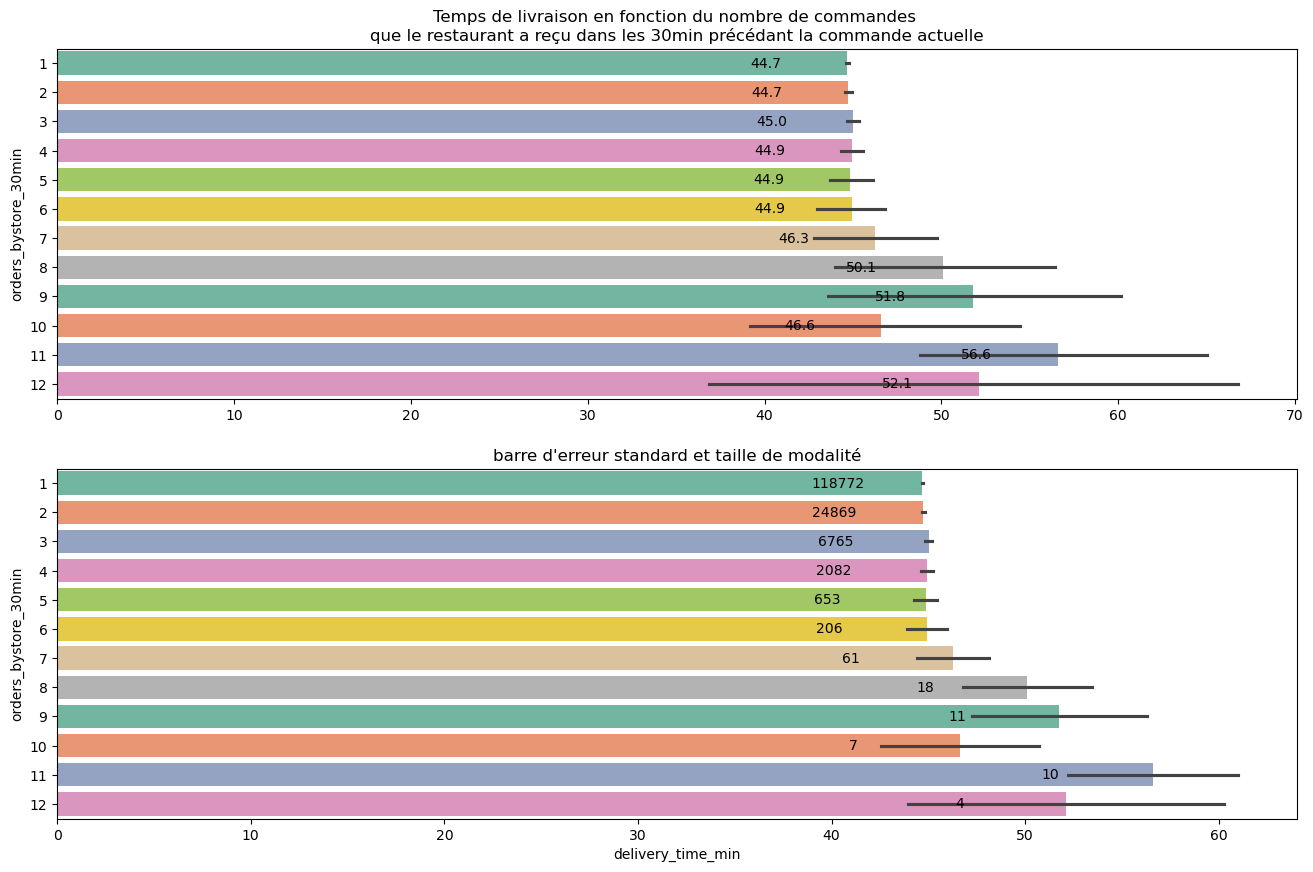

In [73]:
plt.figure(figsize=(16,10))

plt.subplot(211)
br1 = sns.barplot(x= df_new.delivery_time_min,y= df_new.orders_bystore_30min,hue=df_new.orders_bystore_30min
                  , palette="Set2", legend = False,orient = "y")
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",padding=-70)
plt.title("Temps de livraison en fonction du nombre de commandes \nque le restaurant a reçu dans les 30min précédant la commande actuelle")
plt.xlabel("")

plt.subplot(212)
br2 = sns.barplot(x= df_new.delivery_time_min,y= df_new.orders_bystore_30min, hue=df_new.orders_bystore_30min
                  , palette="Set2", legend = False, errorbar="se", orient="y")

counts = df_new['orders_bystore_30min'].value_counts().sort_index()
for container, count in zip(br2.containers, counts):
    br2.bar_label(container, labels=[count], padding=-80)
plt.title("barre d'erreur standard et taille de modalité");


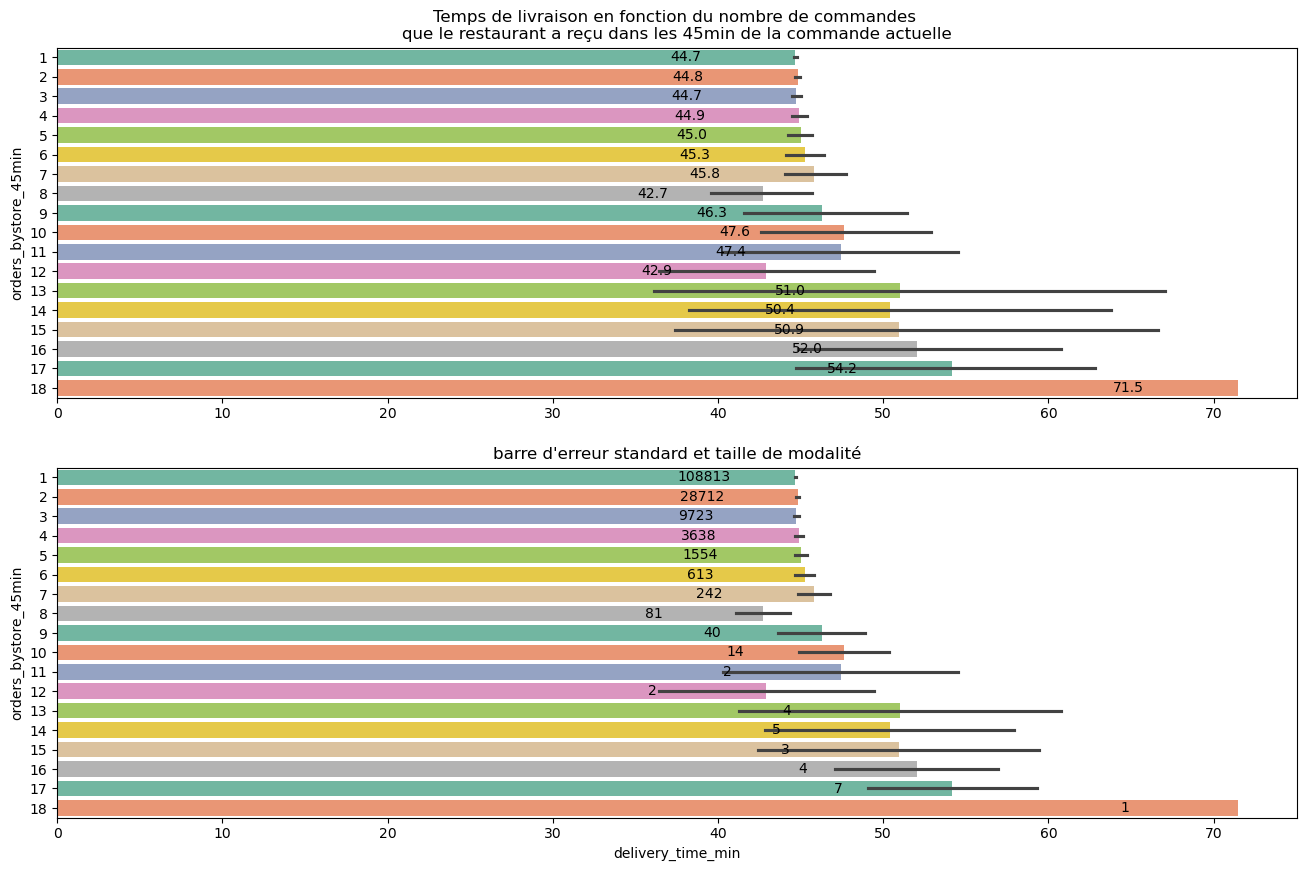

In [74]:
plt.figure(figsize=(16,10))

plt.subplot(211)
br1 = sns.barplot(x= df_new.delivery_time_min,y= df_new.orders_bystore_45min,hue=df_new.orders_bystore_45min
                  , palette="Set2", legend = False, orient='y')
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",padding=-90)
plt.title("Temps de livraison en fonction du nombre de commandes \nque le restaurant a reçu dans les 45min de la commande actuelle")
plt.xlabel("")

plt.subplot(212)
br2 = sns.barplot(x= df_new.delivery_time_min,y= df_new.orders_bystore_45min, hue=df_new.orders_bystore_45min
                  , palette="Set2", legend = False, errorbar="se", orient="y")

counts = df_new['orders_bystore_45min'].value_counts().sort_index()
for container, count in zip(br2.containers, counts):
    br2.bar_label(container, labels=[count], padding=-85)
plt.title("barre d'erreur standard et taille de modalité");


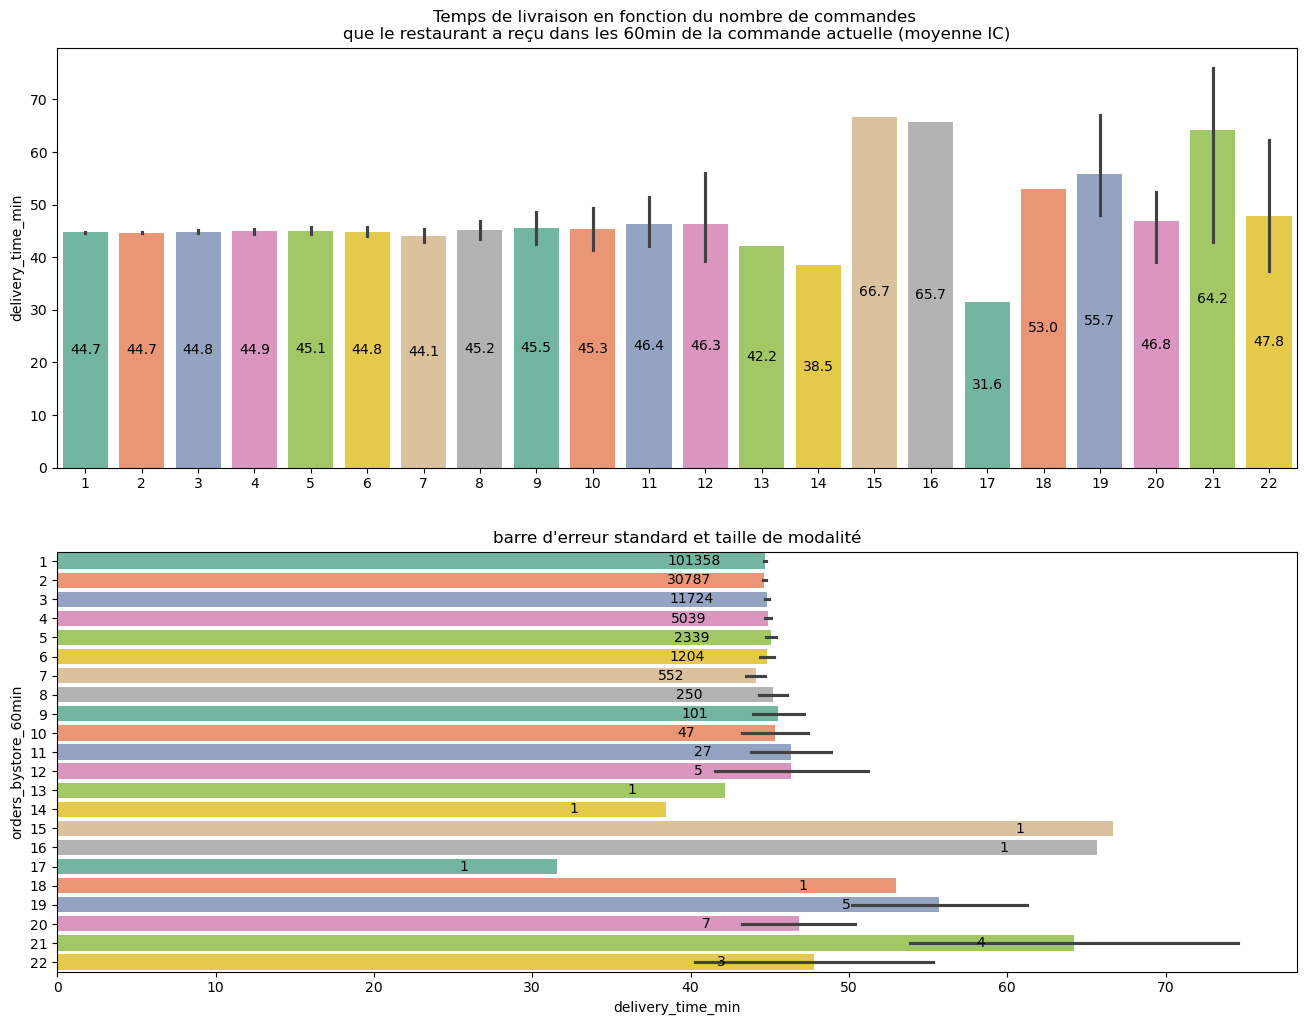

In [75]:
plt.figure(figsize=(16,12))

plt.subplot(211)
br1 = sns.barplot(y= df_new.delivery_time_min,x= df_new.orders_bystore_60min,hue=df_new.orders_bystore_60min
                  , palette="Set2", legend = False)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",label_type="center")
plt.title("Temps de livraison en fonction du nombre de commandes \nque le restaurant a reçu dans les 60min de la commande actuelle (moyenne IC)")
plt.xlabel("")

plt.subplot(212)
br2 = sns.barplot(x= df_new.delivery_time_min,y= df_new.orders_bystore_60min, hue=df_new.orders_bystore_60min
                  , palette="Set2", legend = False, errorbar="se", orient="y")

counts = df_new['orders_bystore_60min'].value_counts().sort_index()
for container, count in zip(br2.containers, counts):
    br2.bar_label(container, labels=[count], padding=-70)
plt.title("barre d'erreur standard et taille de modalité");

<span style="font-size:15px">

Beaucoup de modalités qui sont très peu représentées.  
Si on ne les considère pas, le temps de livraison moyen est similaire pour tout les intervalles de temps considérés

</span>

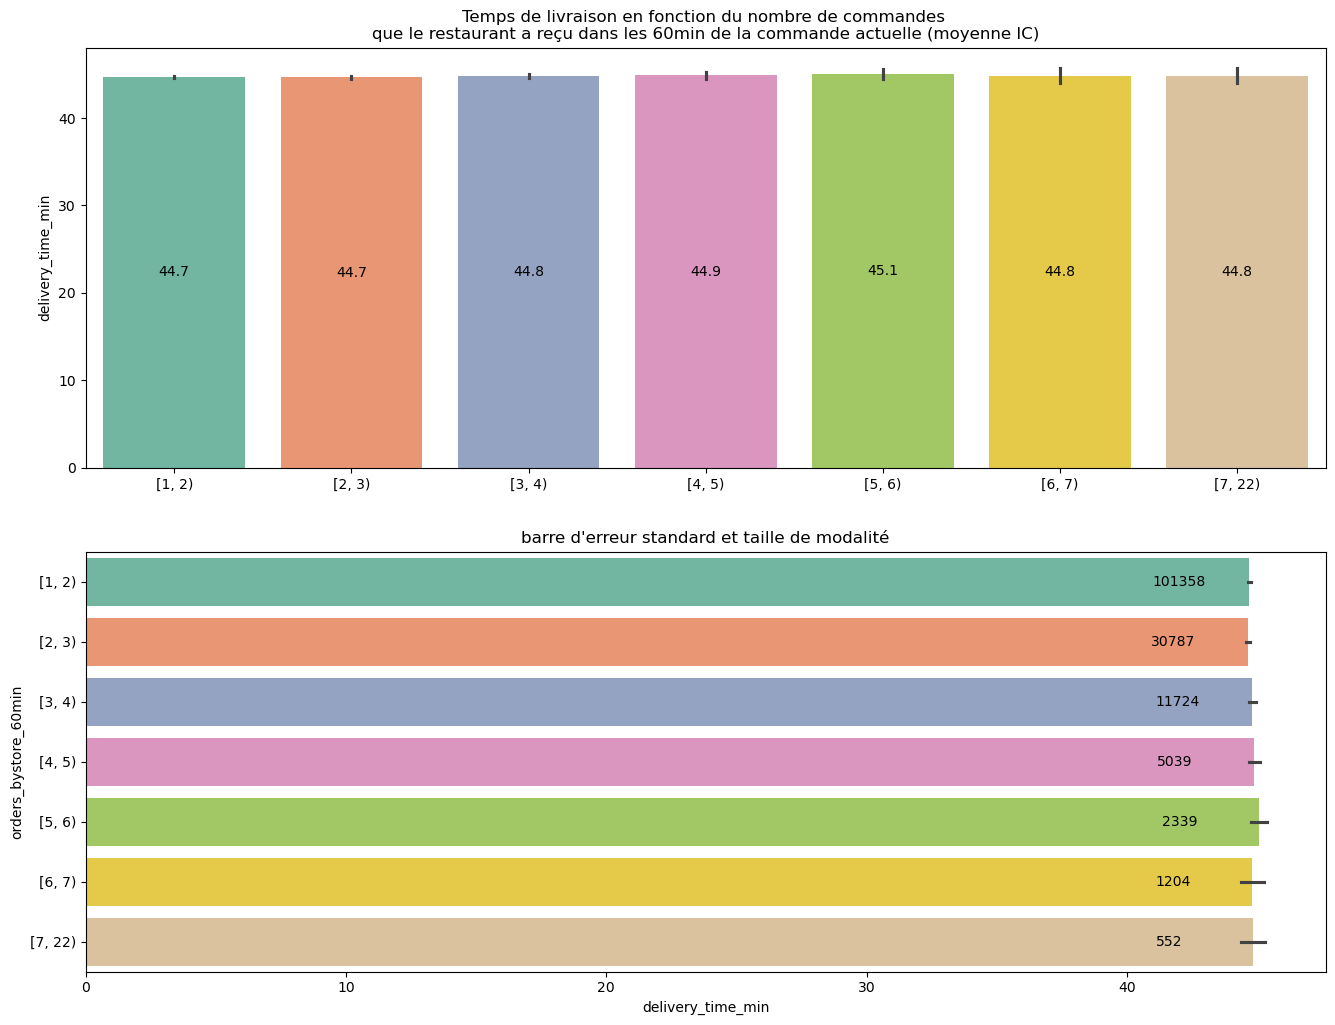

In [76]:
# en regroupant les valeurs avec le moins de modalité. 60min

plt.figure(figsize=(16,12))

plt.subplot(211)
br1 = sns.barplot(y= df_new.delivery_time_min,x= pd.cut(df_new.orders_bystore_60min,bins=[1,2,3,4,5,6,7,22],include_lowest=True,right=False)
,hue=pd.cut(df_new.orders_bystore_60min,bins=[1,2,3,4,5,6,7,22],include_lowest=True,right=False)

                  , palette="Set2", legend = False)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",label_type="center")
plt.title("Temps de livraison en fonction du nombre de commandes \nque le restaurant a reçu dans les 60min de la commande actuelle (moyenne IC)")
plt.xlabel("")

plt.subplot(212)
br2 = sns.barplot(x= df_new.delivery_time_min,y= pd.cut(df_new.orders_bystore_60min,bins=[1,2,3,4,5,6,7,22],include_lowest=True,right=False)
, hue=pd.cut(df_new.orders_bystore_60min,bins=[1,2,3,4,5,6,7,22],include_lowest=True,right=False)

                  , palette="Set2", legend = False, errorbar="se", orient="y")

counts = df_new['orders_bystore_60min'].value_counts().sort_index()
for container, count in zip(br2.containers, counts):
    br2.bar_label(container, labels=[count], padding=-70)
plt.title("barre d'erreur standard et taille de modalité");

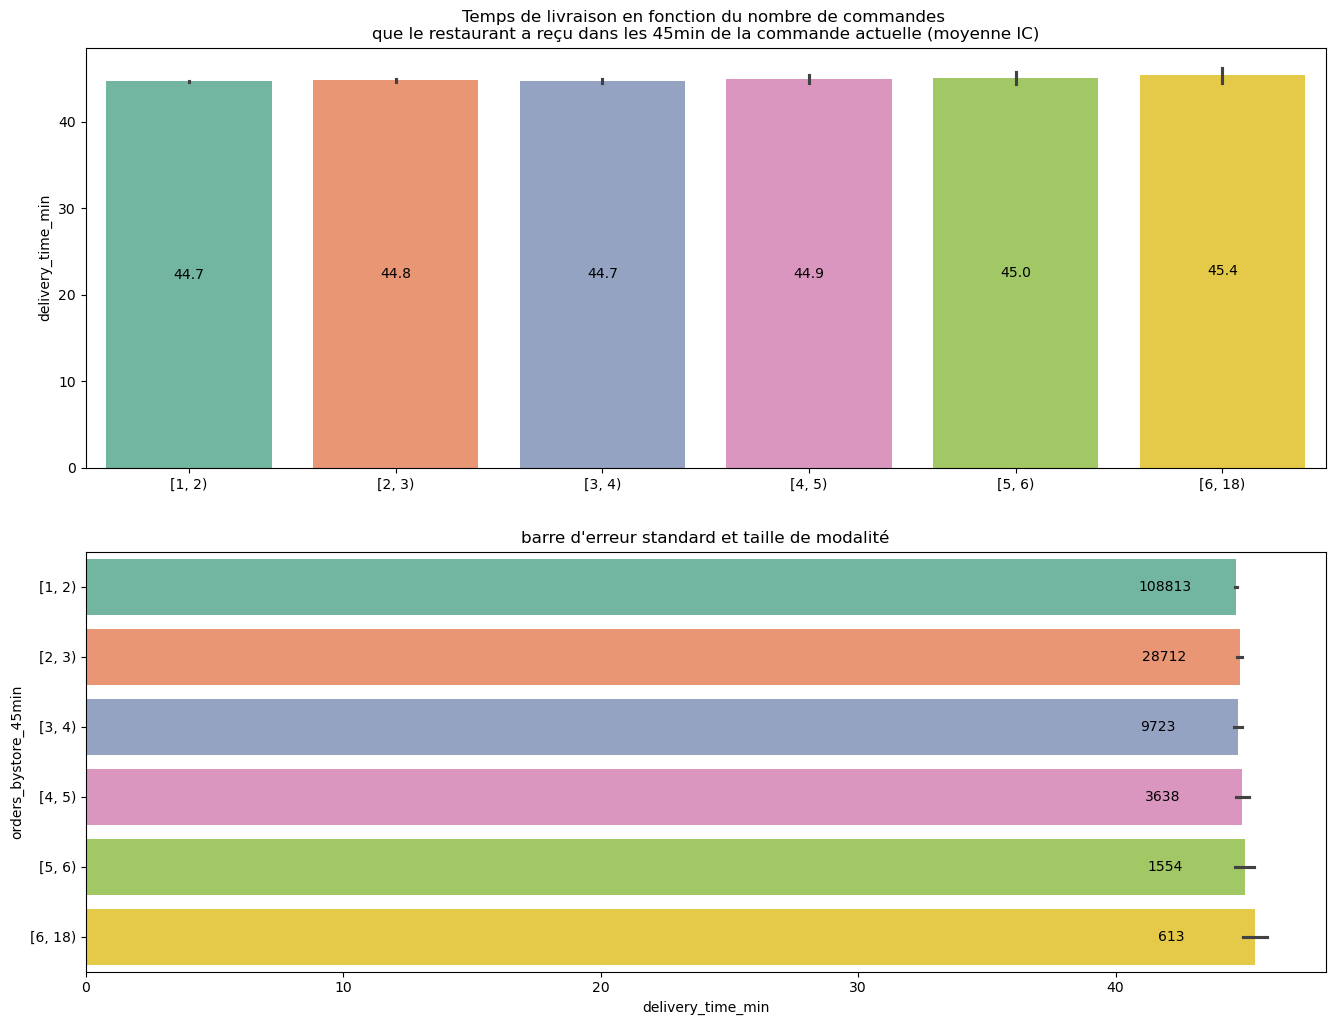

In [23]:
# en regroupant les valeurs avec le moins de modalité (45min)

plt.figure(figsize=(16,12))

plt.subplot(211)
br1 = sns.barplot(y= df_new.delivery_time_min,x= pd.cut(df_new.orders_bystore_45min,bins=[1,2,3,4,5,6,18],include_lowest=True,right=False)
,hue=pd.cut(df_new.orders_bystore_45min,bins=[1,2,3,4,5,6,18],include_lowest=True,right=False)

                  , palette="Set2", legend = False)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",label_type="center")
plt.title("Temps de livraison en fonction du nombre de commandes \nque le restaurant a reçu dans les 45min de la commande actuelle (moyenne IC)")
plt.xlabel("")

plt.subplot(212)
br2 = sns.barplot(x= df_new.delivery_time_min,y= pd.cut(df_new.orders_bystore_45min,bins=[1,2,3,4,5,6,18],include_lowest=True,right=False)
, hue=pd.cut(df_new.orders_bystore_45min,bins=[1,2,3,4,5,6,18],include_lowest=True,right=False)

                  , palette="Set2", legend = False, errorbar="se", orient="y")

counts = df_new['orders_bystore_45min'].value_counts().sort_index()
for container, count in zip(br2.containers, counts):
    br2.bar_label(container, labels=[count], padding=-70)
plt.title("barre d'erreur standard et taille de modalité");

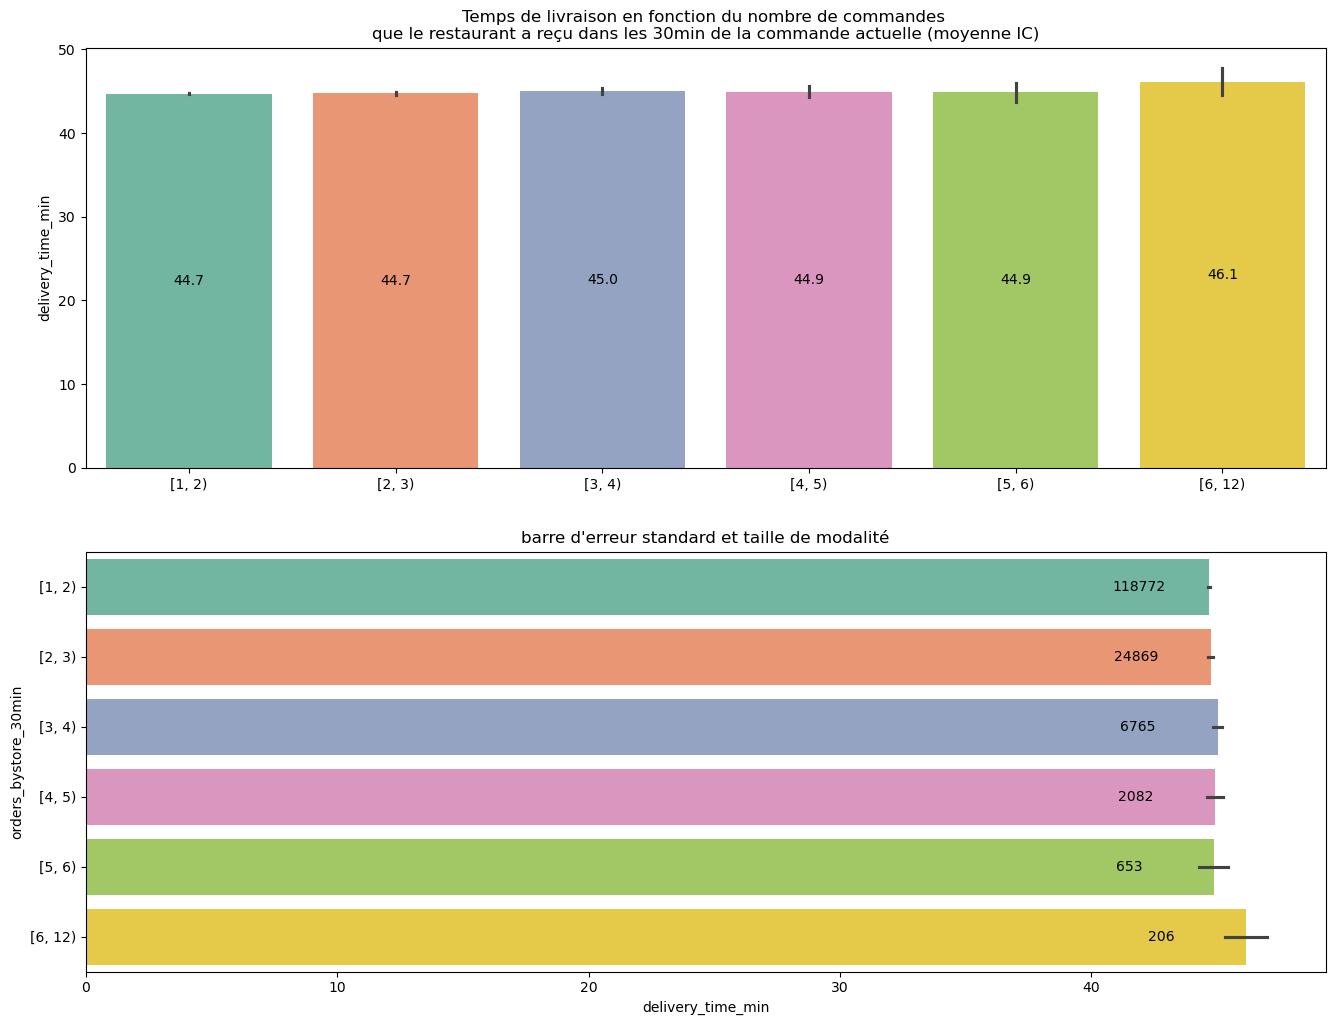

In [22]:
# en regroupant les valeurs avec le moins de modalité (45min)

plt.figure(figsize=(16,12))

plt.subplot(211)
br1 = sns.barplot(y= df_new.delivery_time_min,x= pd.cut(df_new.orders_bystore_30min,bins=[1,2,3,4,5,6,12],include_lowest=True,right=False)
,hue=pd.cut(df_new.orders_bystore_30min,bins=[1,2,3,4,5,6,12],include_lowest=True,right=False)

                  , palette="Set2", legend = False)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",label_type="center")
plt.title("Temps de livraison en fonction du nombre de commandes \nque le restaurant a reçu dans les 30min de la commande actuelle (moyenne IC)")
plt.xlabel("")

plt.subplot(212)
br2 = sns.barplot(x= df_new.delivery_time_min,y= pd.cut(df_new.orders_bystore_30min,bins=[1,2,3,4,5,6,12],include_lowest=True,right=False)
, hue=pd.cut(df_new.orders_bystore_30min,bins=[1,2,3,4,5,6,12],include_lowest=True,right=False)

                  , palette="Set2", legend = False, errorbar="se", orient="y")

counts = df_new['orders_bystore_30min'].value_counts().sort_index()
for container, count in zip(br2.containers, counts):
    br2.bar_label(container, labels=[count], padding=-70)
plt.title("barre d'erreur standard et taille de modalité");

<span style="font-size:15px">
Pour des distributions plus correctes, on regroupe les modalités qui ont le moins d'occurence
</span>

In [77]:
df_new["orders_bystore_30min"] = np.where(df_new["orders_bystore_30min"]>=6,6,df_new["orders_bystore_30min"])

df_new["orders_bystore_45min"] = np.where(df_new["orders_bystore_45min"]>=6,6,df_new["orders_bystore_45min"])

df_new["orders_bystore_60min"] = np.where(df_new["orders_bystore_60min"]>=7,7,df_new["orders_bystore_60min"])

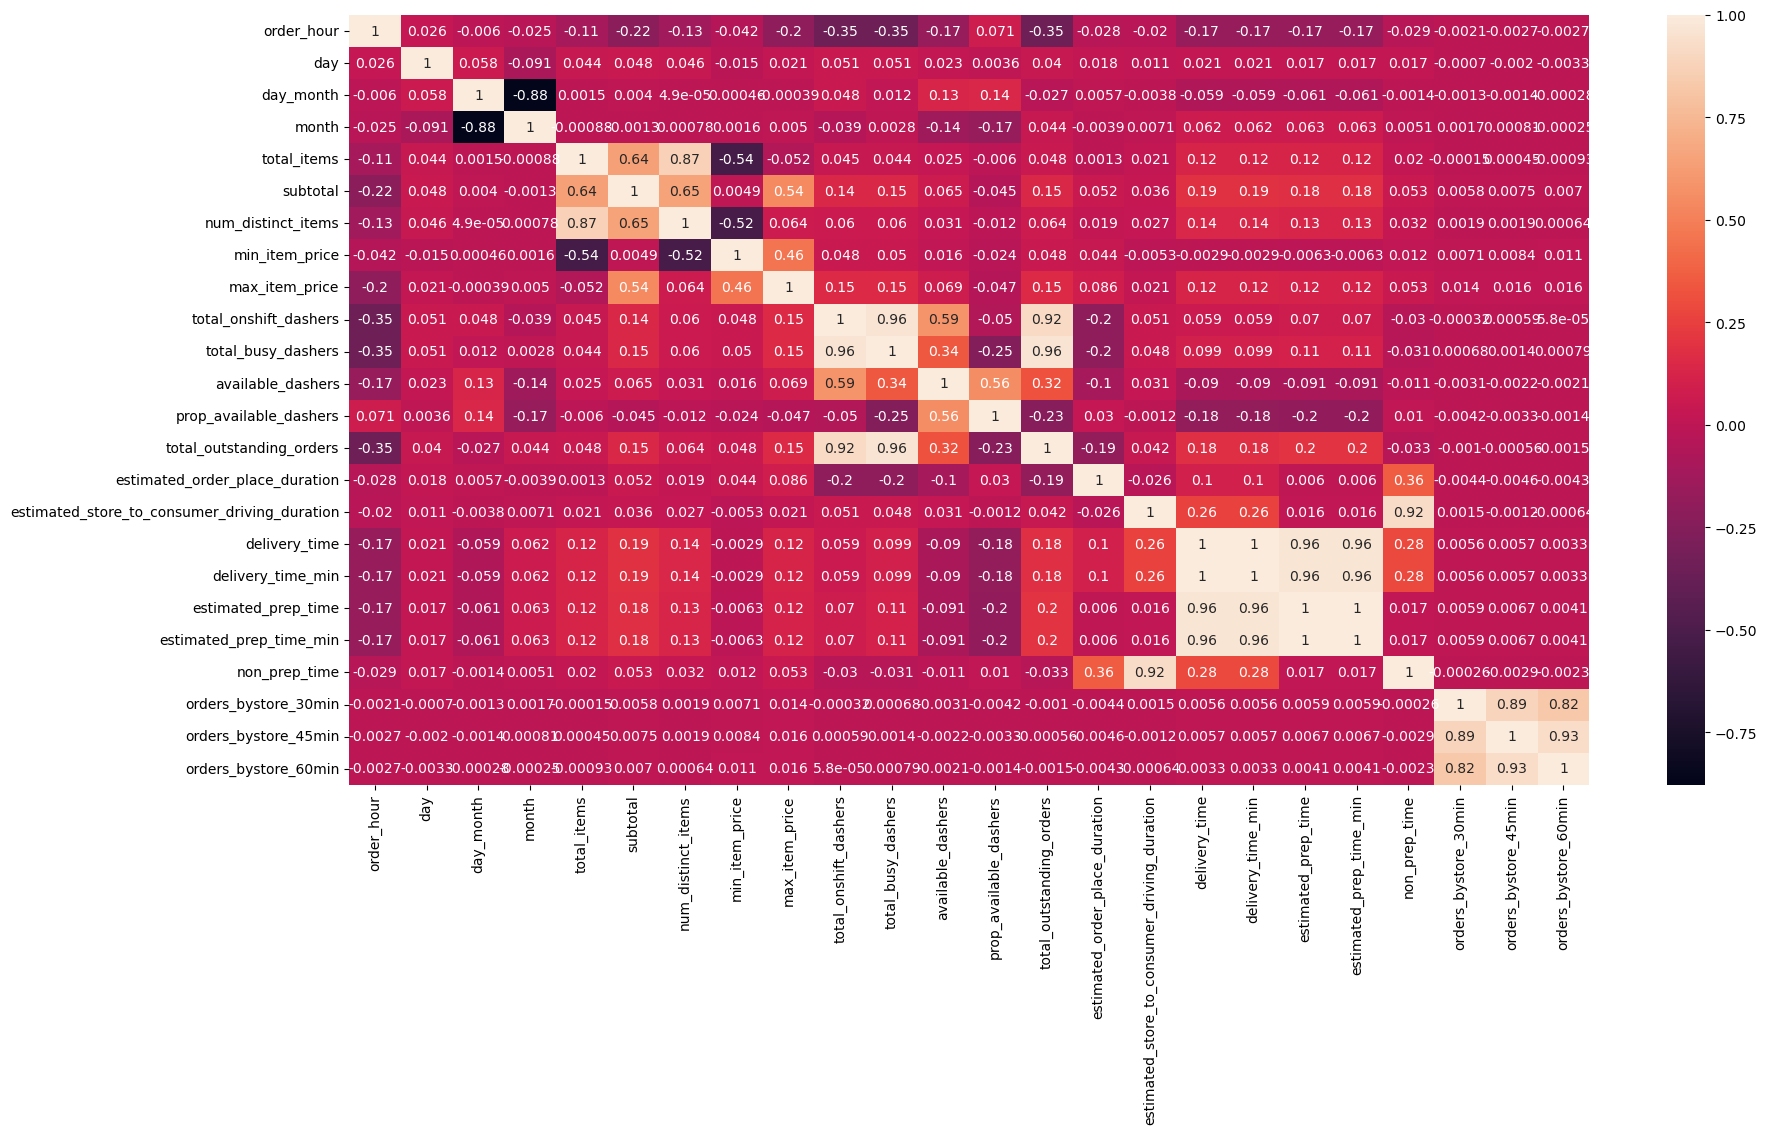

In [78]:
plt.figure(figsize=(20,10))
sns.heatmap(df_new.select_dtypes("number").corr(), annot=True);

## data preprocessing

Pour les variables catégorielles, inspecte les modalités et leurs occurences

**Catégories de restaurant**

In [229]:
df["store_primary_category"].value_counts(normalize=True)
# haute cardinality

store_primary_category
american             0.104609
pizza                0.090907
mexican              0.088832
burger               0.056890
sandwich             0.051293
                       ...   
african              0.000058
lebanese             0.000052
belgian              0.000012
chocolate            0.000006
alcohol-plus-food    0.000006
Name: proportion, Length: 73, dtype: float64

In [230]:
df_new.groupby("store_id")["store_primary_category"].describe()

count unique             top freq
store_id                                  
1            8      1         mexican    8
2            5      1        japanese    5
3            1      1           salad    1
4          128      3            fast  125
7           16      1        sandwich   16
...        ...    ...             ...  ...
6982        15      1        barbecue   15
6983        20      1      vietnamese   20
6985         2      1  latin-american    2
6986        35      5            fast   31
6987         1      1        american    1

[5656 rows x 4 columns]

<span style="font-size:15px">
Certains restaurants possèdent différentes catégories de restaurant en fonction de la commande.  
On garde le type qui apparait le plus pour un restaurant
</span>

In [79]:
# donne la categorie la plus frequente de type de restaurant
df_new["store_primary_category"] = df_new["store_id"].map(pd.crosstab(df_new["store_id"],df_new["store_primary_category"]).idxmax(axis = 1).to_dict())

In [80]:
df_new["store_primary_category"].value_counts(ascending=True)[0:60]
# certaines catégories très peu représentés

store_primary_category
alcohol-plus-food       1
belgian                 2
african                 6
lebanese                8
russian                 8
cheese                 11
european               17
gluten-free            19
moroccan               20
singaporean            20
spanish                21
comfort-food           25
southern               30
argentine              32
kosher                 40
irish                  43
german                 45
soup                   55
afghan                 80
malaysian              84
british                93
ethiopian              98
tapas                 103
pakistani             125
gastropub             173
caribbean             185
turkish               198
peruvian              207
vegan                 221
filipino              239
brazilian             249
cajun                 269
nepalese              272
convenience-store     297
bubble-tea            402
latin-american        403
french                414
persian        

In [235]:
df_new["store_primary_category"].unique()

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'mediterranean', 'japanese', 'catering', 'filipino',
       'convenience-store', 'greek', 'other', 'vegan', 'asian',
       'barbecue', 'breakfast', 'fast', 'dessert', 'smoothie', 'seafood',
       'vietnamese', 'cajun', 'steak', 'persian', 'korean', 'sushi',
       'latin-american', 'chocolate', 'burmese', 'hawaiian', 'british',
       'nepalese', 'pasta', 'alcohol', 'vegetarian', 'dim-sum',
       'peruvian', 'turkish', 'ethiopian', 'middle-eastern', 'bubble-tea',
       'german', 'french', 'caribbean', 'gluten-free', 'comfort-food',
       'gastropub', 'afghan', 'pakistani', 'moroccan', 'tapas',
       'malaysian', 'soup', 'brazilian', 'european', 'cheese', 'african',
       'argentine', 'kosher', 'irish', 'spanish', 'russian', 'southern',
       'lebanese', 'belgian', 'alcohol-plus-food'], dtype=object)

<span style = "font-size=15px">
Il y a beaucoup de catégories de restaurant. On les regroupe en fonction du type de cuisine
</sapn>

In [81]:
# regroupement des en fcontion des types de cuisines
asian = ["chinese","singaporean","japanese","asian","vietnamese","thai","sushi","nepalese","dim-sum","korean","malaysian","indian","filipino","burmese","russian","hawaiian"]
european = ["italian","mediterranean","greek","british","pasta","german","seafood","french","irish","spanish","belgian","cheese","gastropub"]
afro_MdEast = ["persian","middle-eastern","afghan","moroccan","pakistani","turkish","kosher","lebanese","ethiopian","african","caribbean","cajun"]
South_america = ["mexican","latin-american","tapas","argentine","brazilian","peruvian"]
store = ["chocolate","bubble-tea","smoothie","cafe","dessert"]
not_food = ["alcohol","convenience-store","alcohol-plus-food"]
barbecue = ["barbecue","steak","southern","comfort-food"]
healthy = ["vegetarian","vegan","soup","gluten-free","salad"]


for lst,cat in zip([asian,european,afro_MdEast,South_america,store,not_food,barbecue,healthy],["asian","european","afro_MdEast","South_america","store","not_food","barbecue","healthy"]) :
    df_new["store_primary_category"] = df_new["store_primary_category"].replace(lst,cat)

df_new["store_primary_category"].value_counts()

store_primary_category
asian            38695
american         15879
european         15701
South_america    15056
pizza            12730
store            10834
burger            9364
sandwich          8541
fast              5220
breakfast         4516
healthy           4097
other             3443
barbecue          2781
afro_MdEast       2667
not_food          1841
catering          1313
Name: count, dtype: int64

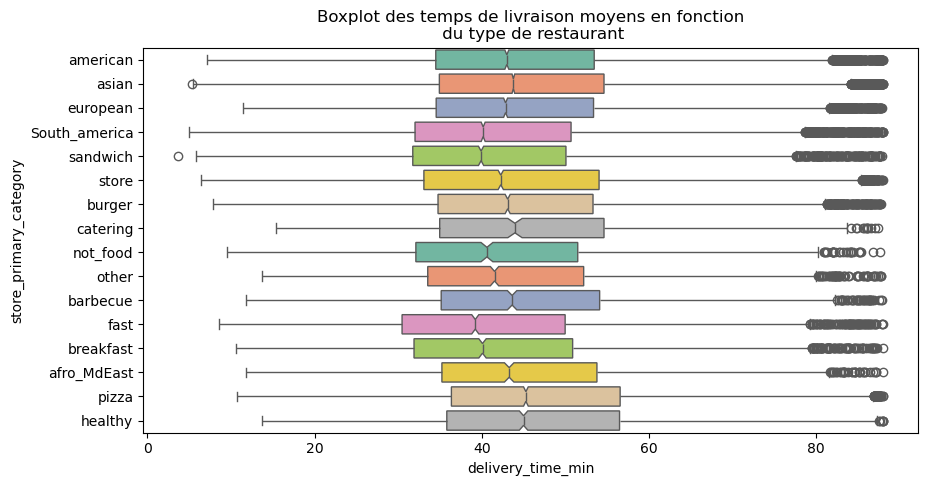

In [82]:
plt.figure(figsize=(10,5))
sns.boxplot(y=df_new["store_primary_category"],x=df_new["delivery_time_min"],hue=df_new["store_primary_category"],notch=True
            ,orient="h",palette="Set2", legend=False);
plt.title("Boxplot des temps de livraison moyens en fonction\n du type de restaurant");


<span style="font-size:15px">
Bien que relativement faibles,il semble y avoir des différences significatives dans les temps de livraison moyen en fonction du type de restaurant allant de 2 à 6 min.  
Le type fast food est celui avec le meilleur temps de livraison moyen.  
Intéressant de regarder le temps de préparation moyen en fonction du type de restaurant
</span>

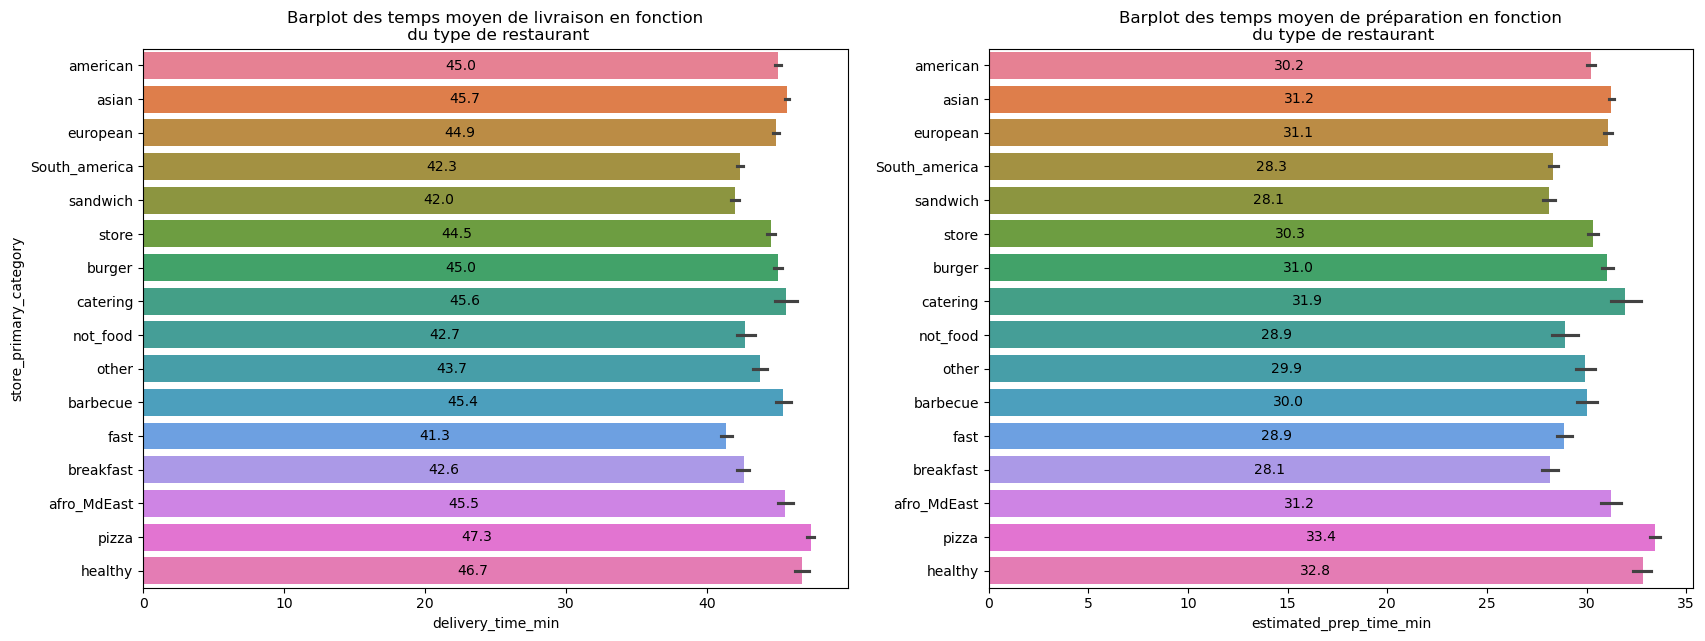

In [84]:
plt.figure(figsize=(20,7))
plt.subplot(121)
br1 = sns.barplot(x= df_new.delivery_time_min,y= df_new.store_primary_category, hue=df_new.store_primary_category
            ,orient='y', legend = False)
for container in br1.containers :
    br1.bar_label(container, fmt="%.1f",label_type="center")
    
plt.title("Barplot des temps moyen de livraison en fonction\n du type de restaurant");


plt.subplot(122)
br2 = sns.barplot(x= df_new.estimated_prep_time_min,y= df_new.store_primary_category, hue=df_new.store_primary_category
            ,orient='y', legend = False)
for container in br2.containers :
    br2.bar_label(container, fmt="%.1f",label_type="center")
plt.ylabel("")    
plt.title("Barplot des temps moyen de préparation en fonction\n du type de restaurant");



<span style="font-size:15px">
Temps de livraison : Bien que relativement faibles,il semble y avoir des différences significatives dans les temps de livraison moyen en fonction du type de restaurant allant de 2 à 6 min. Le type fast food est celui avec le meilleur temps de livraison moyen.     

Temps de préparation : On retrouve à peu près les mêmes tendances pour les temps de préparation, avec le type fast qui prend le moins de temps  
</span>

**Ville/Région**

In [85]:
df_new["market_id"].value_counts()

market_id
2.0    45535
4.0    39488
1.0    31913
3.0    19101
5.0    16068
6.0      562
Name: count, dtype: int64

In [86]:
# determine le market_id d'un store en fonction de la majorité
pd.crosstab(df_new["market_id"],df_new["store_id"]).idxmax(axis = 0)

df_new["market_id"] = df_new["store_id"].map(pd.crosstab(df_new["market_id"],df_new["store_id"]).idxmax(axis = 0).to_dict())

In [87]:
df_new["market_id"].value_counts()
# apres la transormation le nombre de market 6 est très réduit ==> supprime

market_id
2.0    45936
4.0    39937
1.0    32119
3.0    19221
5.0    16239
6.0        3
Name: count, dtype: int64

In [88]:
# met des na pour les location 6
df_new["market_id"] = np.where(df_new["market_id"]==6.0,np.nan,df_new["market_id"])
# met 0 ou na dans prop_available dashers
df_new["prop_available_dashers"] = df_new["prop_available_dashers"].fillna(0)

# drop le reste des NAs
df_new = df_new.dropna()

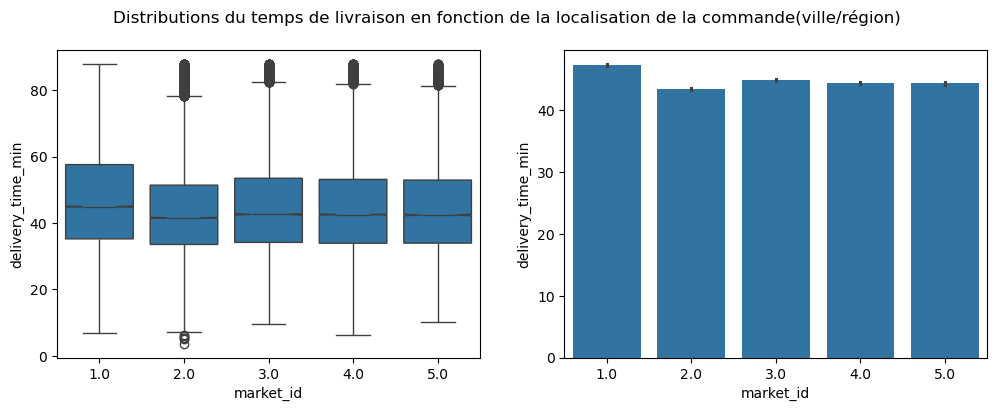

In [91]:
plt.figure(figsize=(12,4))
plt.suptitle("Distributions du temps de livraison en fonction de la localisation de la commande(ville/région)")
plt.subplot(121)
sns.boxplot(x="market_id",y = "delivery_time_min", data=df_new,notch=True)
plt.subplot(122)
sns.barplot(x="market_id",y = "delivery_time_min", data=df_new);

<span style="font-size:15px">
Il y de légères différences de temps de livraison de quelques minutes en fonction de la localisation
</span>

**Type de commande**

In [92]:
df_new["order_protocol"].value_counts()
# supprime 6 et 7

order_protocol
1.0    43120
3.0    40113
5.0    36052
2.0    18143
4.0    14675
6.0      554
7.0       16
Name: count, dtype: int64

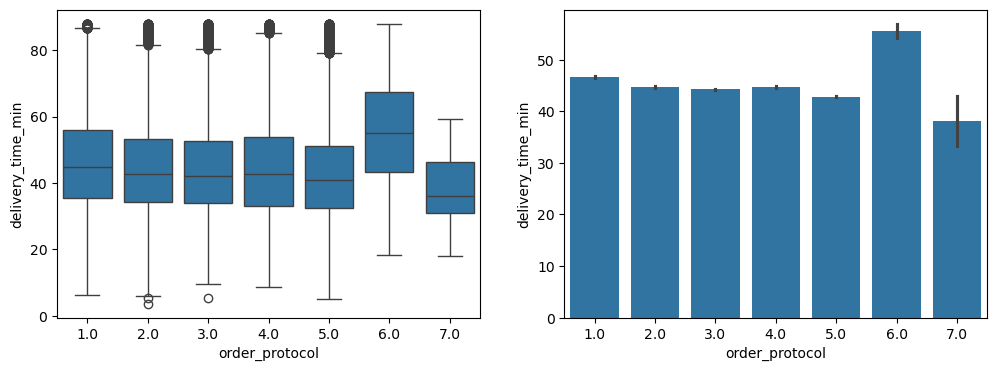

In [93]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.boxplot(x="order_protocol",y = "delivery_time_min", data=df_new)
plt.subplot(122)
sns.barplot(x="order_protocol",y = "delivery_time_min", data=df_new);

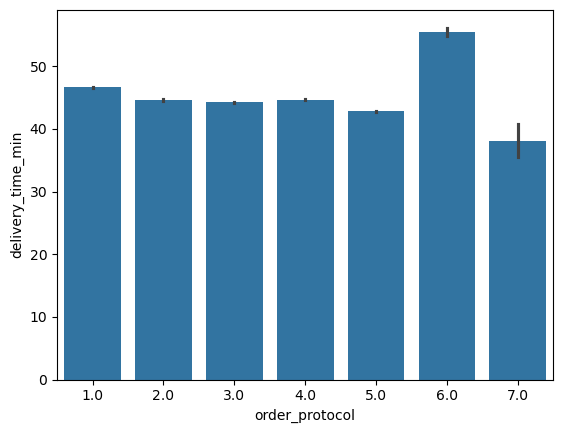

In [94]:
sns.barplot(x="order_protocol",y = "delivery_time_min", data=df_new,errorbar="se");

In [95]:
df_new["order_protocol"] = np.where(df_new["order_protocol"].astype("float")>= 6.0,np.nan,df_new["order_protocol"])
df_new = df_new.dropna()


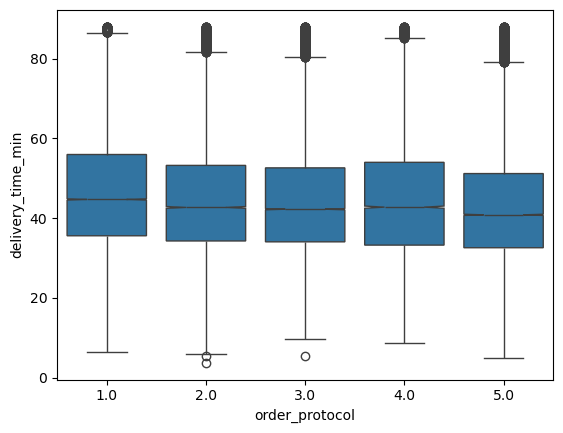

In [96]:
sns.boxplot(x = df_new["order_protocol"],y=df_new["delivery_time_min"],notch=True);


In [ ]:
# df_new.to_csv("Data/DF_preprocessed.csv")

In [ ]:
# df_new = pd.read_csv("Data/DF_preprocessed.csv")

# df_new = df_new.drop(["Unnamed: 0"],axis=1)
# df_new[["market_id","store_id","order_protocol"]] = df_new[["market_id","store_id","order_protocol"]].astype("object")

#### Encoding

In [92]:

from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder
from feature_engine.encoding import MeanEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

from skopt import BayesSearchCV
from skopt.space import Categorical,Real,Integer


In [62]:
# séparation de target et variables explicatives et supprime les variables issues de la target
X = df_new.drop(["delivery_time","delivery_time_min","created_at","actual_delivery_time"
                 ,"estimated_prep_time","estimated_prep_time_min","month"],axis= 1)
y = df_new["delivery_time"]


Encodage cyclique pour les variables temporelles

In [63]:
# cyclic enco
def cycle_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

X = cycle_encode(X,"day",6)
X = cycle_encode(X,"day_month", 31)
X = cycle_encode(X,"order_hour",24)
X = X.drop(["day","day_month","order_hour"], axis=1)
X.head()

market_id store_id store_primary_category order_protocol  total_items  \
0        1.0     1845               american            1.0            4   
1        3.0     5477                  asian            2.0            1   
2        3.0     5477                  asian            1.0            1   
3        3.0     5477                  asian            1.0            3   
4        3.0     5477                  asian            1.0            3   

   subtotal  num_distinct_items  min_item_price  max_item_price  \
0      3441                   4             557            1239   
1      1900                   1            1400            1400   
2      1900                   1            1900            1900   
3      3900                   3            1100            1600   
4      5000                   3            1500            1900   

   total_onshift_dashers  ...  non_prep_time  orders_bystore_30min  \
0                   33.0  ...         1307.0                     1   
1                    2.0  ...         1136.0                     1   
2                    1.0  ...         1136.0                     1   
3                    6.0  ...         1096.0                     1   
4                    2.0  ...          784.0                     1   

   orders_bystore_45min  orders_bystore_60min       day_sin  day_cos  \
0                     1                     1 -8.660254e-01     -0.5   
1                     1                     1  8.660254e-01      0.5   
2                     1                     1  1.224647e-16     -1.0   
3                     1                     1 -2.449294e-16      1.0   
4                     1                     1  8.660254e-01     -0.5   

   day_month_sin  day_month_cos  order_hour_sin  order_hour_cos  
0       0.937752       0.347305       -0.500000        0.866025  
1       0.897805      -0.440394       -0.707107        0.707107  
2      -0.968077      -0.250653       -0.866025        0.500000  
3       0.101168      -0.994869        0.500000        0.866025  
4      -0.571268       0.820763       -0.866025        0.500000  

[5 rows x 26 columns]

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=12)

<span style="font-size:15px">

Encoding  :  
- OneHot encoding : market_id,store_primary_category,order_protocol
- Mean encoding : market_id
- robuscaler pour les numériques

</span>

In [94]:
cat_col = ["market_id","store_primary_category","order_protocol"]

num = ["total_items","subtotal","num_distinct_items","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","available_dashers","prop_available_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","non_prep_time",
       "orders_bystore_30min","orders_bystore_45min","orders_bystore_60min"]

autres =["store_id",'day_sin', 'day_cos', 'day_month_sin', 'day_month_cos',
       'order_hour_sin', 'order_hour_cos']

# mean encoding sur store_id
pipe_meanEnco = Pipeline([('meanEncoding', MeanEncoder(variables=["store_id"],smoothing="auto",unseen="encode"))])

# transformation des autres col, oneHot et RobustScaler
preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(drop='first',sparse_output=False,dtype='int'), cat_col),
    ('standardiz', RobustScaler(), num),
    ("autres", "passthrough",autres)])

final_pipe = Pipeline(steps=[('ME',pipe_meanEnco),
                ("OH_ST",preprocessor)])

# transformation et mise sous dataFrame
X_train_pipe = final_pipe.fit_transform(X_train,y_train)
X_test_pipe = final_pipe.transform(X_test)

cols= list(final_pipe.named_steps['OH_ST'].named_transformers_['onehot'].get_feature_names_out())\
    +list(final_pipe.named_steps['OH_ST'].named_transformers_['standardiz'].get_feature_names_out())\
    +list(final_pipe.named_steps['OH_ST'].named_transformers_['autres'].get_feature_names_out())
    
X_train_pipe = pd.DataFrame(X_train_pipe, columns=cols)
X_train_pipe = X_train_pipe.reset_index(drop=True)

X_test_pipe = pd.DataFrame(X_test_pipe, columns=cols)
X_test_pipe = X_test_pipe.reset_index(drop=True)



### analyse corélation

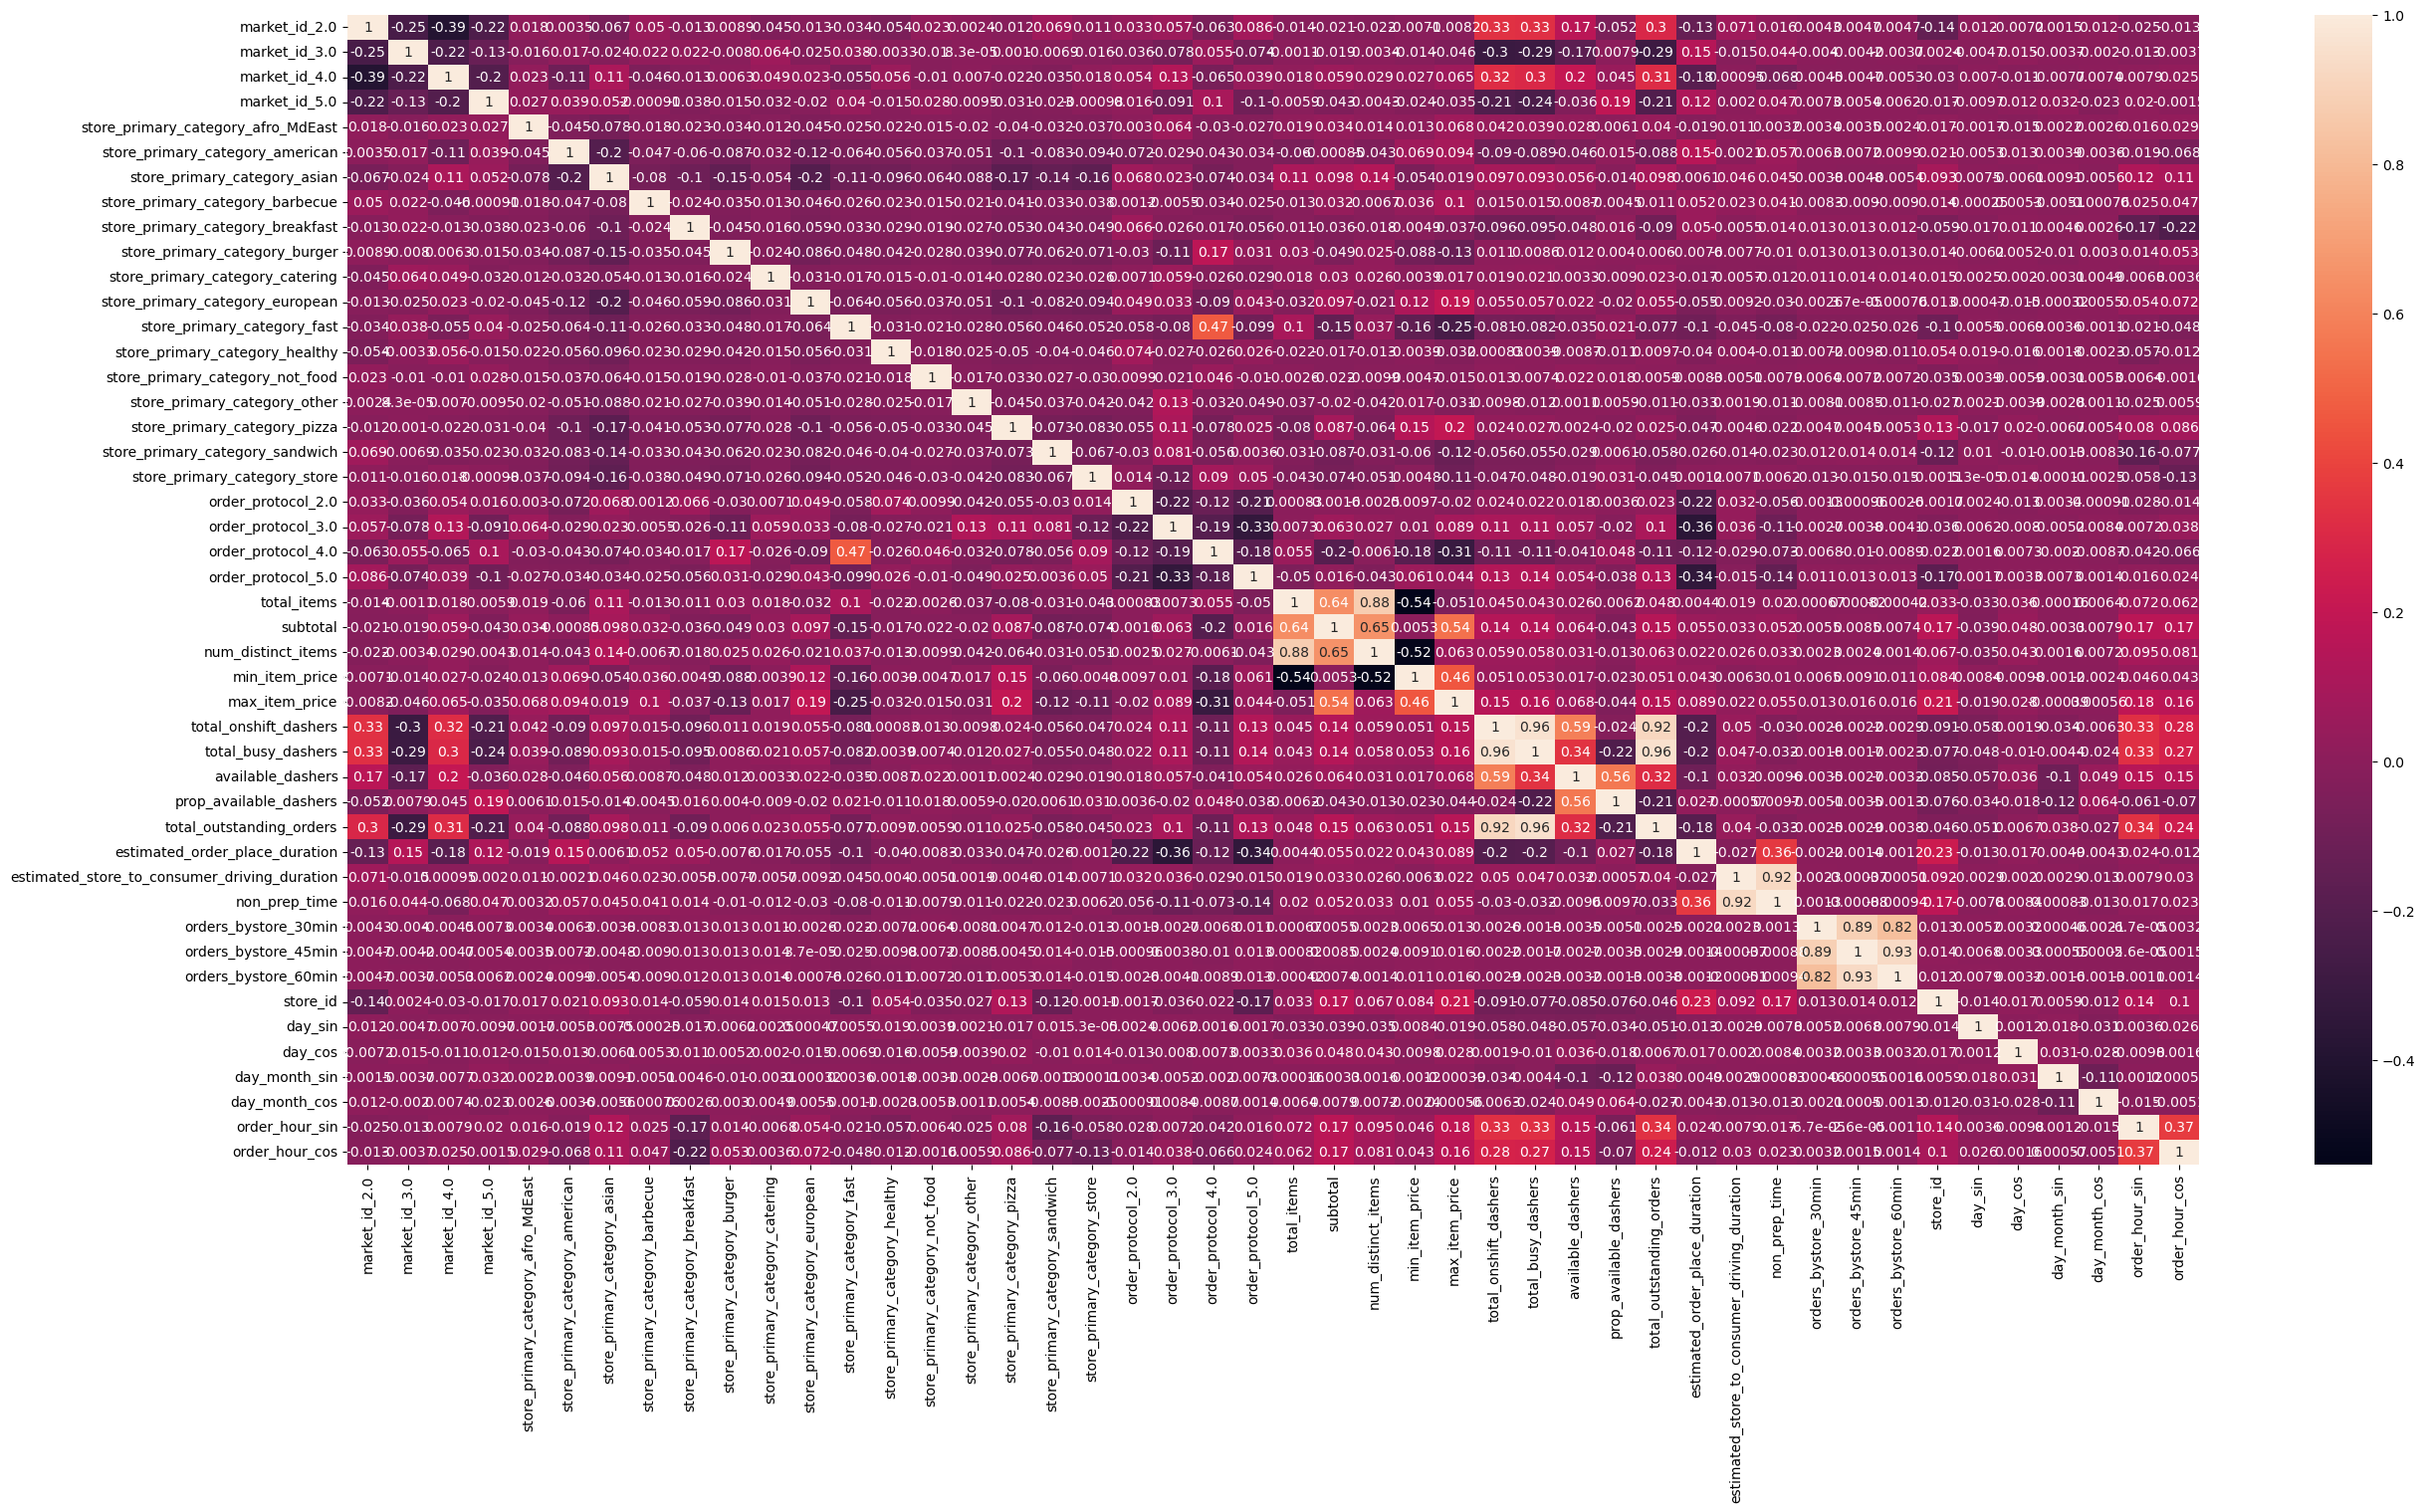

In [67]:
plt.figure(figsize=(30,15))
sns.heatmap(X_train_pipe.corr(), annot=True);

<span style="font-size:15px">

Il existe de fortes corrélations entre variables explicatives lorsqu'elles qu'elle donne le même type d'informations :    
Sur le prix de la commande (prix de l'item le moins/plus chère de la commande, le nombre d'item, le prix de la commande)  
Les infos sur les livreurs et le nombre de commandes en cours  

</span>

In [ ]:
# corrélation entre les variables explicatives et la cible
X_train_pipe.corrwith(y_train).abs().sort_values()

store_primary_category_catering                 0.000249
market_id_4.0                                   0.000277
store_primary_category_other                    0.000344
prop_available_dashers                          0.000346
total_outstanding_orders                        0.000409
store_id                                        0.000471
order_protocol_2.0                              0.000496
subtotal                                        0.000544
order_hour_cos                                  0.000670
day_month_sin                                   0.000813
order_protocol_4.0                              0.000900
total_busy_dashers                              0.000928
market_id_2.0                                   0.000941
store_primary_category_fast                     0.001052
market_id_3.0                                   0.001097
total_items                                     0.001134
store_primary_category_asian                    0.001207
total_onshift_dashers          

In [69]:
X_train.select_dtypes("number").corrwith(y_train).abs().sort_values()

min_item_price                                  0.003462
orders_bystore_60min                            0.005763
day_month_cos                                   0.006876
orders_bystore_45min                            0.007208
orders_bystore_30min                            0.008405
day_month_sin                                   0.029466
day_sin                                         0.037393
market_id                                       0.041029
total_onshift_dashers                           0.058232
day_cos                                         0.084197
available_dashers                               0.089667
order_hour_cos                                  0.095946
total_busy_dashers                              0.098184
estimated_order_place_duration                  0.099073
total_items                                     0.125766
max_item_price                                  0.127092
order_hour_sin                                  0.135928
num_distinct_items             

In [96]:
# drop des features à fortes corrélation
X_train_corr = X_train_pipe.drop(["available_dashers","orders_bystore_30min","total_items","total_onshift_dashers"
                              ,"total_busy_dashers","non_prep_time","orders_bystore_45min"],axis=1)

X_test_corr = X_test_pipe.drop(["available_dashers","orders_bystore_30min","total_items","total_onshift_dashers"
                            ,"total_busy_dashers","non_prep_time","orders_bystore_45min"],axis=1)


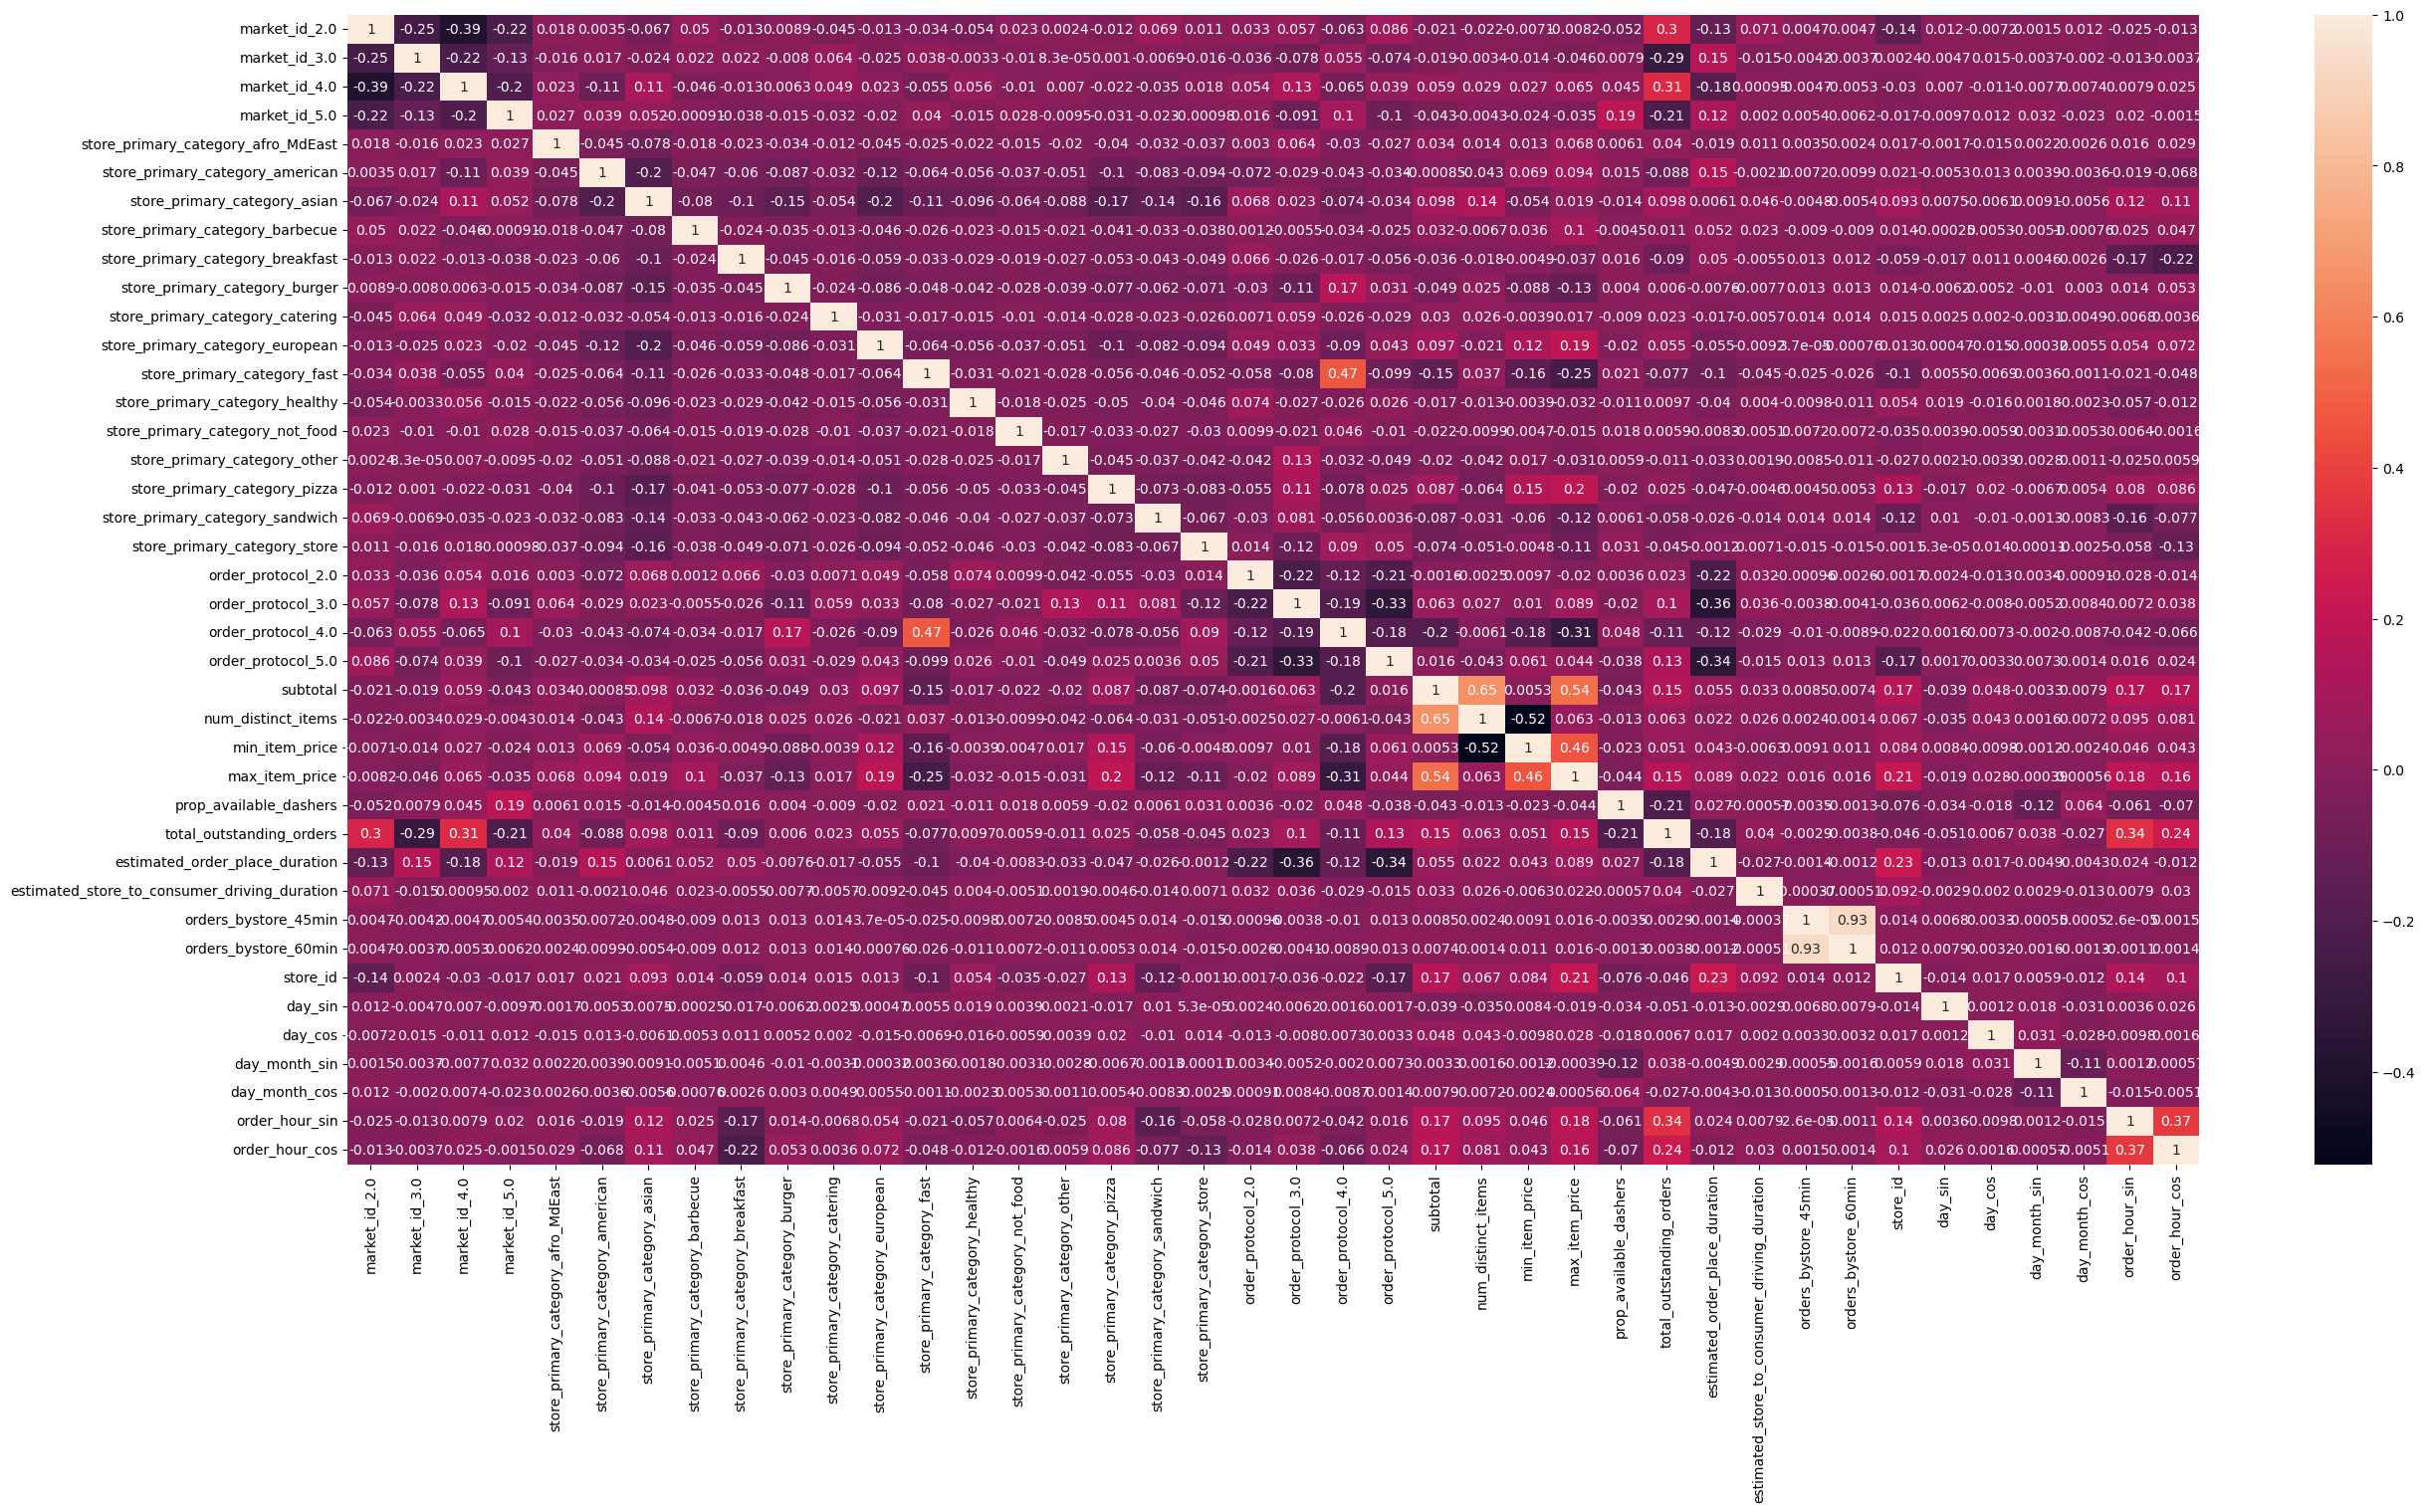

In [74]:
plt.figure(figsize=(30,15))
sns.heatmap(X_train_pipe.corr(), annot=True);

#### VIF : mesure de colinéarité

<span style="font-size:15px">

Le facteur d'inflation de variance (VIF) permet de mesurer la multicolinéarité (corrélation entre variables). Permet de mieux isoler les effets des variables explicatives en supprimmant les corrélations trop importantes

</span>

In [70]:
## calcul de VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_corr.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_corr.values,i) for i in range(len(X_train_corr.columns))]
vif_data.sort_values(by="VIF",ascending=False)

# drop de store_id

feature        VIF
32                                      store_id  31.326411
29                estimated_order_place_duration   7.345340
20                            order_protocol_3.0   6.985415
38                                order_hour_cos   6.137288
22                            order_protocol_5.0   5.972306
24                            num_distinct_items   3.985012
19                            order_protocol_2.0   3.751650
6                   store_primary_category_asian   3.670676
23                                      subtotal   3.499790
21                            order_protocol_4.0   3.108111
0                                  market_id_2.0   3.013489
2                                  market_id_4.0   2.937470
26                                max_item_price   2.287806
25                                min_item_price   2.244760
28                      total_outstanding_orders   2.138182
11               store_primary_category_european   2.104496
5                store_primary_category_american   2.063869
16                  store_primary_category_pizza   1.990287
18                  store_primary_category_store   1.758006
9                  store_primary_category_burger   1.688550
12                   store_primary_category_fast   1.678053
1                                  market_id_3.0   1.590110
3                                  market_id_5.0   1.583257
17               store_primary_category_sandwich   1.553186
37                                order_hour_sin   1.388959
8               store_primary_category_breakfast   1.340451
31                          orders_bystore_60min   1.312565
13                store_primary_category_healthy   1.307443
27                        prop_available_dashers   1.292086
15                  store_primary_category_other   1.242598
7                store_primary_category_barbecue   1.208298
4             store_primary_category_afro_MdEast   1.201560
14               store_primary_category_not_food   1.119263
10               store_primary_category_catering   1.106780
34                                       day_cos   1.065887
35                                 day_month_sin   1.051896
36                                 day_month_cos   1.023416
33                                       day_sin   1.020522
30  estimated_store_to_consumer_driving_duration   1.016235

In [85]:
def cal_vif(df):
    """""
    calcul du vif et renvoie df
    """""
    # X = X_train_se[variables]
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns

    vif_data["VIF"] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))]
    return vif_data.sort_values(by="VIF",ascending=False)



In [ ]:
# Une vif idéal est plutôt limité à 5 mais pour cette analyse on décide de mettre la limite à 10
cal_vif(X_train_corr.drop(["store_id"],axis=1))


feature       VIF
37                                order_hour_cos  5.676547
20                            order_protocol_3.0  4.289530
24                            num_distinct_items  3.972672
29                estimated_order_place_duration  3.905841
22                            order_protocol_5.0  3.645355
23                                      subtotal  3.498325
6                   store_primary_category_asian  3.145375
0                                  market_id_2.0  2.970667
2                                  market_id_4.0  2.895167
19                            order_protocol_2.0  2.488735
21                            order_protocol_4.0  2.335197
26                                max_item_price  2.287072
25                                min_item_price  2.241738
28                      total_outstanding_orders  2.119493
11               store_primary_category_european  1.906001
5                store_primary_category_american  1.862859
16                  store_primary_category_pizza  1.758204
12                   store_primary_category_fast  1.597803
1                                  market_id_3.0  1.585197
18                  store_primary_category_store  1.582753
3                                  market_id_5.0  1.580686
9                  store_primary_category_burger  1.557373
17               store_primary_category_sandwich  1.482234
36                                order_hour_sin  1.388840
31                          orders_bystore_60min  1.306267
27                        prop_available_dashers  1.290388
8               store_primary_category_breakfast  1.282869
13                store_primary_category_healthy  1.226022
15                  store_primary_category_other  1.205258
7                store_primary_category_barbecue  1.179667
4             store_primary_category_afro_MdEast  1.168196
14               store_primary_category_not_food  1.101417
10               store_primary_category_catering  1.089122
33                                       day_cos  1.065417
34                                 day_month_sin  1.051427
35                                 day_month_cos  1.023415
32                                       day_sin  1.019784
30  estimated_store_to_consumer_driving_duration  1.014537

In [ ]:
# variables à drop suite à l'analyse du VIF
var_vif = ["store_id"]

X_train_vif = X_train_corr.drop(var_vif,axis=1)
X_test_vif = X_train_corr.drop(var_vif,axis=1)

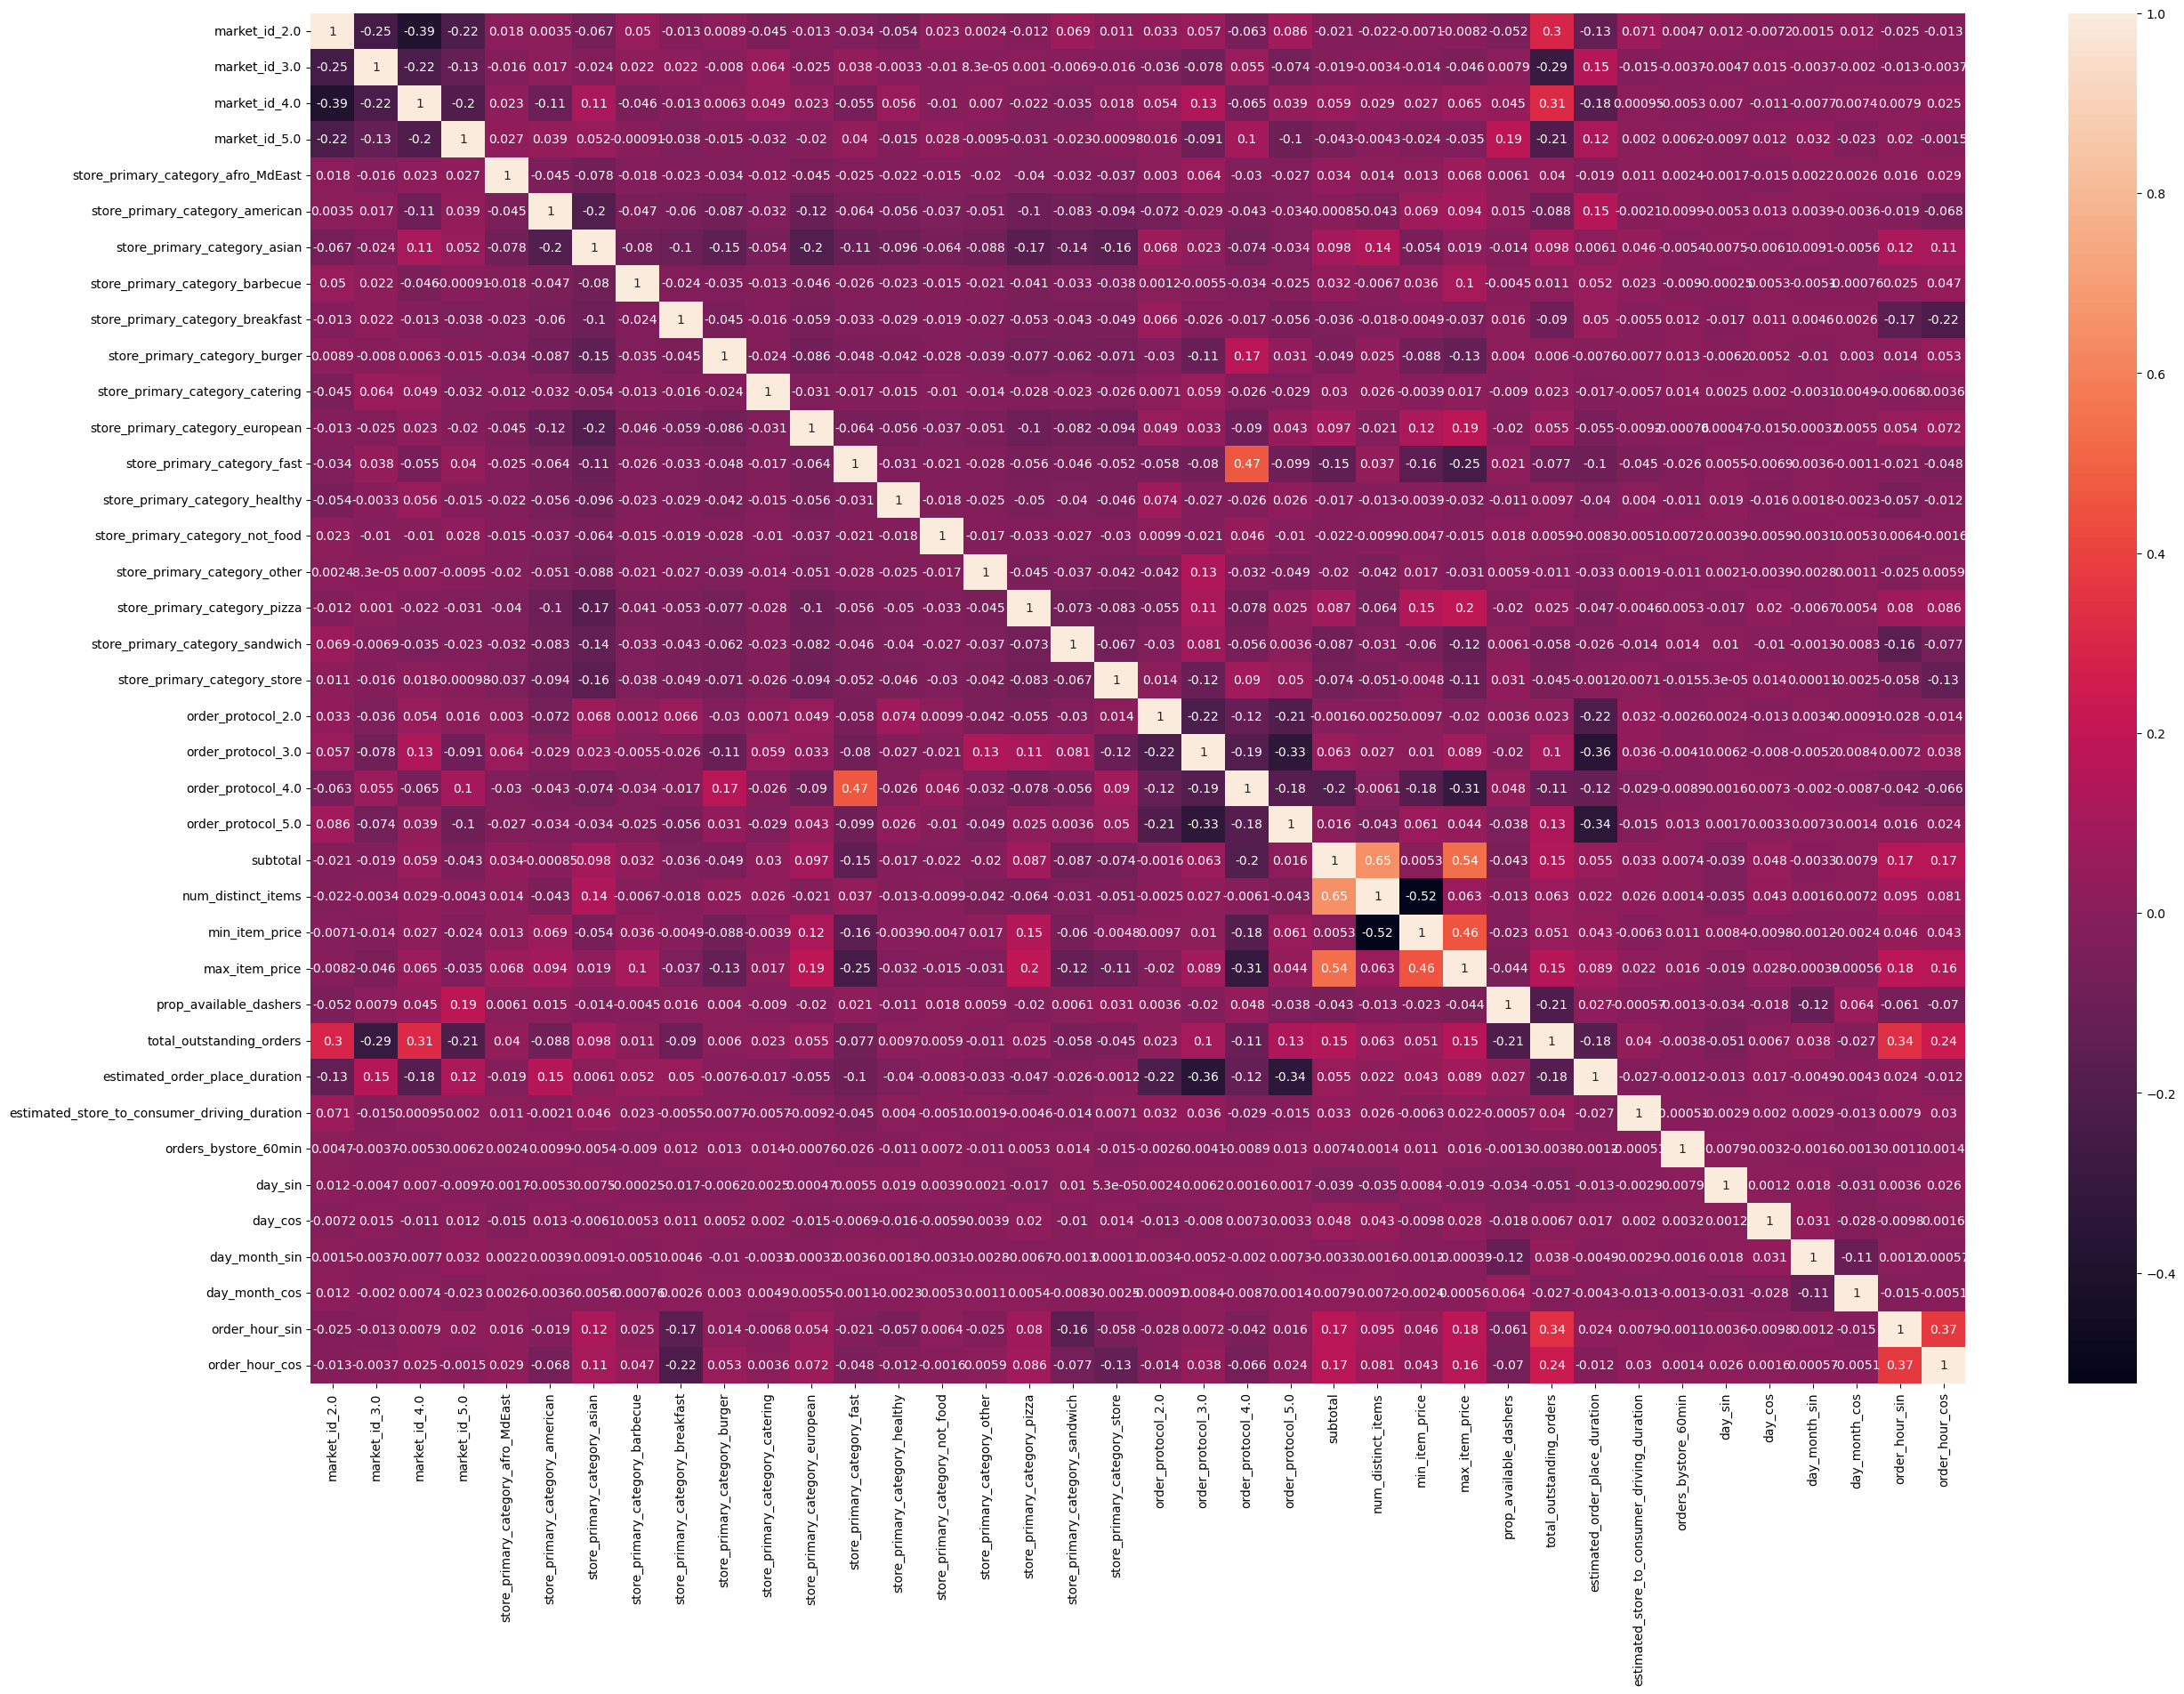

In [ ]:
# corrélation post VIF
plt.figure(figsize=(30,20))
sns.heatmap(X_train_vif.corr(),annot=True);

## **modeles**

Les modèles seront évalués par RMSE. Permet d'interpréter les résulats facilement et c'est une bonne métrique pour pénaliser les larges erreurs

In [91]:
def eval_mod(model,X_train,X_test,y_train,y_test,idx) :
    # calcul des pred de test et train
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    score_train = root_mean_squared_error(y_train,y_pred_train)
    score_test = root_mean_squared_error(y_test,y_pred_test)


    rst = {
            "rmse_train" : [score_train],
            "rmse_test" : [score_test],
            "diff" : [score_train-score_test],
            "overfit ratio" : [score_test/score_train]
            }

    rst = pd.DataFrame(rst,index=[idx])

    return rst

In [99]:
tab_rst = pd.DataFrame()

In [ ]:
# modeles benchmark avec fulldataset, sans les variables enleve via vif
lg_full = LinearRegression()
lg_vif = LinearRegression()

lg_full.fit(X_train_pipe,y_train)
lg_vif.fit(X_train_vif,y_train)


rst_benchmark_full = eval_mod(lg_full,X_train_pipe,X_test_pipe,y_train,y_test,idx="LG_full")
rst_benchmark_vif = eval_mod(lg_vif,X_train_vif,X_test_vif,y_train,y_test,idx="LG_vif")

tab_rst = pd.concat([tab_rst,rst_benchmark_full,rst_benchmark_vif])

tab_rst

#les resulats sont moins bon apres le retrait de variables mais moins d'overfitting

rmse_train   rmse_test       diff  overfit ratio
LG_full  694.460565  722.012152 -27.551587       1.039673
LG_vif   773.338797  767.060210   6.278587       0.991881

On teste 4 autres modèles SGVD, RandomForest, XGBoost et LGBM 

#### **modele de base sans selection de variables**

In [ ]:
RF_base = RandomForestRegressor(random_state=42)
sgd_base = SGDRegressor(loss = "squared_error",random_state=42)
xgb_base = XGBRegressor(random_state=42,objective='reg:squarederror')
lgb_base = LGBMRegressor(random_state=42,objective="regression")

RF_base.fit(X_train_pipe,y_train)
sgd_base.fit(X_train_pipe,y_train)
xgb_base.fit(X_train_pipe,y_train)
lgb_base.fit(X_train_pipe,y_train)

bench_RF = eval_mod(RF_base,X_train_pipe,X_test_pipe,y_train,y_test,idx = "RF_full")
bench_SGD = eval_mod(sgd_base,X_train_pipe,X_test_pipe,y_train,y_test,idx = "SGD_full")
bench_XGB = eval_mod(xgb_base,X_train_pipe,X_test_pipe,y_train,y_test,idx = "XGB_full")
bench_LGB = eval_mod(lgb_base,X_train_pipe,X_test_pipe,y_train,y_test,idx = "LGB_full")

# avec toute les variable lgb obtient meiileur score , SGD a du mal(regularizetion)
tab_rst = pd.concat([tab_rst,bench_RF,bench_SGD,bench_XGB,bench_LGB])

#### **modeles de base avec selection VIF**

In [ ]:
RF_vif = RandomForestRegressor(random_state=42)
sgd_vif = SGDRegressor(loss = "squared_error",random_state=42)
xgb_vif = XGBRegressor(random_state=42,objective='reg:squarederror')
lgb_vif = LGBMRegressor(random_state=42,objective="regression")

RF_vif.fit(X_train_vif,y_train)
sgd_vif.fit(X_train_vif,y_train)
xgb_vif.fit(X_train_vif,y_train)
lgb_vif.fit(X_train_vif,y_train)

RF_vif = eval_mod(RF_vif,X_train_vif,X_test_vif,y_train,y_test,idx = "RF_vif")
SGD_vif = eval_mod(sgd_vif,X_train_vif,X_test_vif,y_train,y_test,idx = "SGD_vif")
XGB_vif = eval_mod(xgb_vif,X_train_vif,X_test_vif,y_train,y_test,idx = "XGB_vif")
LGB_vif = eval_mod(lgb_vif,X_train_vif,X_test_vif,y_train,y_test,idx = "LGB_vif")

tab_rst = pd.concat([tab_rst,RF_vif,SGD_vif,XGB_vif,LGB_vif])

In [105]:
tab_rst
# meilleur modele lgbm

rmse_train     rmse_test          diff  overfit ratio
LG_full   6.944606e+02  7.220122e+02 -2.755159e+01       1.039673
LG_vif    7.733388e+02  7.670602e+02  6.278587e+00       0.991881
RF_full   2.567837e+02  7.103325e+02 -4.535488e+02       2.766268
SGD_full  5.036172e+14  5.033611e+14  2.560572e+11       0.999492
XGB_full  6.072669e+02  6.870878e+02 -7.982093e+01       1.131443
LGB_full  6.466975e+02  6.848563e+02 -3.815877e+01       1.059006
RF_vif    2.757668e+02  7.291347e+02 -4.533679e+02       2.644026
SGD_vif   7.740353e+02  7.676029e+02  6.432311e+00       0.991690
XGB_vif   6.591876e+02  7.074115e+02 -4.822383e+01       1.073156
LGB_vif   7.039289e+02  7.097681e+02 -5.839250e+00       1.008295

#### parameters tuning

<span style = "font-size:15px">

Continue les analyses avec finetuning des paramètres des modèles XGB et LGB

</span>

In [108]:
para_LG = {'boosting_type':Categorical(['gbdt', 'dart']), 
              'learning_rate': Real(0.003, 0.3, 'log-uniform'),
              "n_estimators" : Integer(100,800),
              'max_depth' : Integer(3,40),
              'num_leaves' : Integer(6,50),
              'subsample' : Real(0.5,1),
              'colsample_bytree' : Real(0.4,1),
              "skip_drop" : Real(0.3,0.7),
              "drop_rate" : Real(0.1,0.3)
              }


para_XG = { 
              'learning_rate': Real(0.003, 0.3, 'log-uniform'),
              "n_estimators" : Integer(100,800),
              'max_depth' : Integer(3,40),
              'max_leaves' : Integer(6,50),
              'subsample' : Real(0.5,1),
              'colsample_bytree' : Real(0.4,1)
              }



clfs = [XGBRegressor(objective='reg:squarederror'),LGBMRegressor(objective="regression")] 
parametres = [para_XG, para_LG]
cle_models = ["XGB","LGB"]
# Kcv = StratifiedKFold(n_splits = 5)
dico_grille = {}


for clf, para, model in zip(clfs, parametres, cle_models) : 
     dico_grille[model] = BayesSearchCV(clf, 
                    search_spaces = para,
                    n_iter=50,
                    cv = 5, scoring = "neg_root_mean_squared_error",
                    n_jobs=-1, verbose=1)
    

In [ ]:
rst_models = {}

for model,grille in dico_grille.items() :
    rst_models[model] = grille.fit(X_train_vif,y_train)

In [114]:
print("best_para", rst_models["XGB"].best_params_)
print("best_para", rst_models["LGB"].best_params_)


best_para OrderedDict({'colsample_bytree': 0.4, 'learning_rate': 0.062119054634734994, 'max_depth': 40, 'max_leaves': 50, 'n_estimators': 800, 'subsample': 0.9991450779825422})
best_para OrderedDict({'boosting_type': 'gbdt', 'colsample_bytree': 0.6045059268622619, 'drop_rate': 0.27068887291900723, 'learning_rate': 0.0557757322658917, 'max_depth': 27, 'n_estimators': 698, 'num_leaves': 50, 'skip_drop': 0.519173084096097, 'subsample': 1.0})


In [112]:
xgb,lgb = eval_mod(rst_models["XGB"],X_train_vif,X_test_vif,y_train,y_test,idx="XGB_tuned"),\
    eval_mod(rst_models["LGB"],X_train_vif,X_test_vif,y_train,y_test,idx="LGB_tuned")

tab_rst=pd.concat([tab_rst,xgb,lgb])


In [118]:
tab_rst

rmse_train   rmse_test        diff  overfit ratio
LG_full    694.460565  722.012152  -27.551587       1.039673
LG_vif     773.338797  767.060210    6.278587       0.991881
RF_full    256.783674  710.332456 -453.548782       2.766268
XGB_full   607.266869  687.087796  -79.820927       1.131443
LGB_full   646.697546  684.856314  -38.158768       1.059006
RF_vif     275.766799  729.134663 -453.367864       2.644026
SGD_vif    774.035251  767.602941    6.432311       0.991690
XGB_vif    659.187646  707.411480  -48.223835       1.073156
LGB_vif    703.928884  709.768134   -5.839250       1.008295
XGB_tuned  651.760849  699.230129  -47.469280       1.072832
LGB_tuned  642.164556  696.881779  -54.717223       1.085207

In [117]:
tab_rst = tab_rst.drop(["SGD_full"])

<span style = "font-size:15px">

Le modèles LGBM tuned obtient les meilleurs résultats avec une erreur moyenne de 690sec (~11min) suivit par le modèle XGB avec 693.    
Mais le LGBM à overfit plus (à voir si on peut améliorer avec un tuning plus poussé)

</span>

In [138]:
# comparaison des résulats pour LGBM et XGB
lgbm_pred = rst_models["LGB"].best_estimator_.predict(X_test_vif)
xgb_pred = rst_models["XGB"].best_estimator_.predict(X_test_vif)


df_res = pd.DataFrame({'Reels': y_test, 'Prédits_LGB': lgbm_pred , 'Prédits_XGB': xgb_pred,
                        "LGB_diff en min" : (lgbm_pred-y_test)/60, "XGB_diff en min" : (xgb_pred-y_test)/60})
df_res.reset_index(drop=True, inplace=True)
df_res.head(10)



Reels  Prédits_LGB  Prédits_XGB  LGB_diff en min  XGB_diff en min
0  1821.0  2202.489327  2236.427246         6.358155         6.923787
1  2713.0  2256.730763  2269.333496        -7.604487        -7.394442
2  2887.0  2870.544881  2825.786133        -0.274252        -1.020231
3  4191.0  3082.281572  3179.740723       -18.478640       -16.854321
4  2304.0  2611.290970  2524.488281         5.121516         3.674805
5  1733.0  3198.891604  3411.907715        24.431527        27.981795
6  3681.0  3399.959729  3414.445068        -4.684005        -4.442582
7  1711.0  2205.698762  2189.846924         8.244979         7.980782
8  1769.0  2021.001520  2098.114014         4.200025         5.485234
9  4696.0  3866.311354  3655.514160       -13.828144       -17.341431

In [139]:
df_res.describe()
# analyse descriptive des stats, on peut voir de le écart type réels et plus grands 
# que pour les prédictions : plus grande dispersions des données v(ers les extremes donc)
# le minimium pour les réels=223 alors que les prédits=1211-1288  différence également entre les max (5280 vs 4700-4900)
# Probablement difficultés des modeles à prédire les valeurs extremes

Reels   Prédits_LGB   Prédits_XGB  LGB_diff en min  \
count  38026.000000  38026.000000  38026.000000     38026.000000   
mean    2672.056935   2681.064347   2680.422852         0.150124   
std      860.497683    493.647892    496.157288        11.613879   
min      223.000000   1307.754494   1130.363525       -55.973403   
25%     2039.000000   2325.986480   2325.733337        -6.466428   
50%     2548.000000   2645.727885   2650.391235         1.789522   
75%     3193.000000   2998.955119   3004.098145         8.329004   
max     5279.000000   4882.571488   4704.547363        39.449172   

       XGB_diff en min  
count     38026.000000  
mean          0.139429  
std          11.653155  
min         -52.831382  
25%          -6.482722  
50%           1.745850  
75%           8.315865  
max          39.203971

In [ ]:
display(df_res.sort_values(by="LGB_diff en min",ascending=True).head(10))
# sous estime le temps quand y_true est grand


Reels  Prédits_LGB  Prédits_XGB  LGB_diff en min  XGB_diff en min
33844  5202.0  1843.595836  2032.117065       -55.973403       -52.831382
3391   4921.0  1771.266100  1842.296753       -52.495565       -51.311721
11366  5142.0  2051.438715  2147.869873       -51.509355       -49.902169
19301  4944.0  1869.038205  1781.312744       -51.249363       -52.711454
10025  5123.0  2096.813741  2214.619141       -50.436438       -48.473014
27599  5189.0  2189.437170  2107.928223       -49.992714       -51.351196
30683  5071.0  2106.782051  2193.918945       -49.403632       -47.951351
2382   5279.0  2368.032925  2500.997559       -48.516118       -46.300041
31270  4745.0  1851.579018  1981.374146       -48.223683       -46.060431
12164  5278.0  2406.811331  2568.382812       -47.853144       -45.160286

Reels  Prédits_LGB  Prédits_XGB  LGB_diff en min  XGB_diff en min
4047   1691.0  4057.950298  4043.238281        39.449172        39.203971
27620   985.0  3131.632227  3037.169922        35.777204        34.202832
34814   747.0  2845.287303  2845.959961        34.971455        34.982666
30549  1259.0  3323.324378  3345.750732        34.405406        34.779179
36607  2082.0  4032.808872  3960.858643        32.513481        31.314311
20481  1603.0  3522.852812  3593.556152        31.997547        33.175936
23142  2454.0  4370.040911  4132.550781        31.934015        27.975846
6113    713.0  2621.723498  2619.553711        31.812058        31.775895
25807  1591.0  3462.887506  3471.720703        31.198125        31.345345
9880   1780.0  3608.527986  3686.719971        30.475466        31.778666

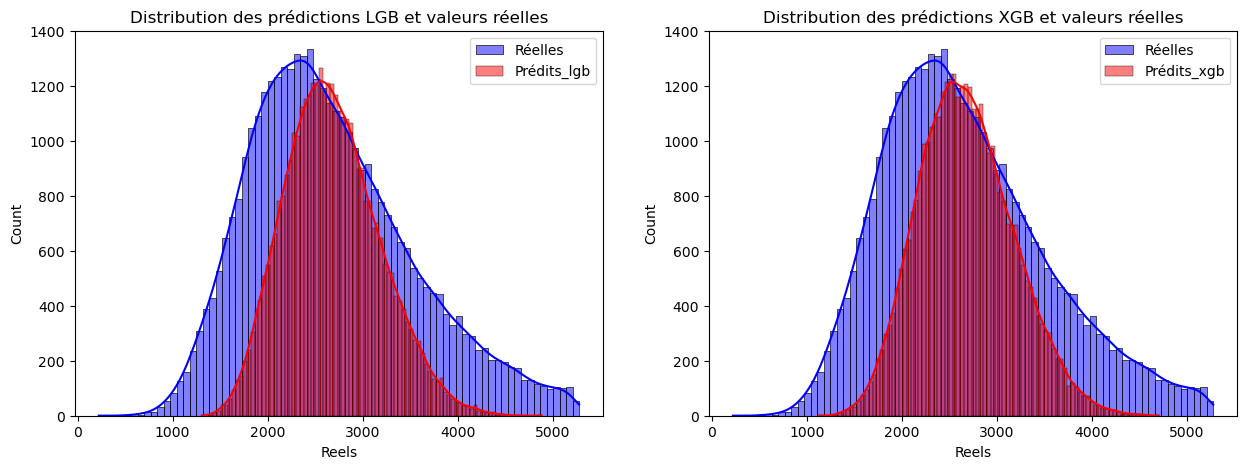

In [141]:
# plot des distibution des prédiction et valeurs réelspl

plt.figure(figsize=(15,5))

plt.subplot(121)
ax = sns.histplot(df_res['Reels'], color = 'blue',  kde = True, label = 'Réelles')
sns.histplot(  df_res['Prédits_LGB'], color = 'red', ax=ax, kde = True, label = 'Prédits_lgb')
plt.title("Distribution des prédictions LGB et valeurs réelles")
plt.legend()


plt.subplot(122)
ax2 = sns.histplot(df_res['Reels'], color = 'blue',  kde = True, label = 'Réelles')
sns.histplot(  df_res['Prédits_XGB'], color = 'red', ax=ax2, kde = True, label = 'Prédits_xgb')
plt.title("Distribution des prédictions XGB et valeurs réelles")
plt.legend();

<span style="font-size:15px">

Décalage entre les prédictions et les valeurs réelles : pour les deux modèles les distributions des prédictions sont normales centrées sur 2500 environ. Les valeurs réelles ont une distribution avec une légère asymétrie positive.  
Le modèles prédit les valeurs qui séloignent de la moyenne
Métrique de performance MAE pour pénaliser plus les grosses erreurs

</span>

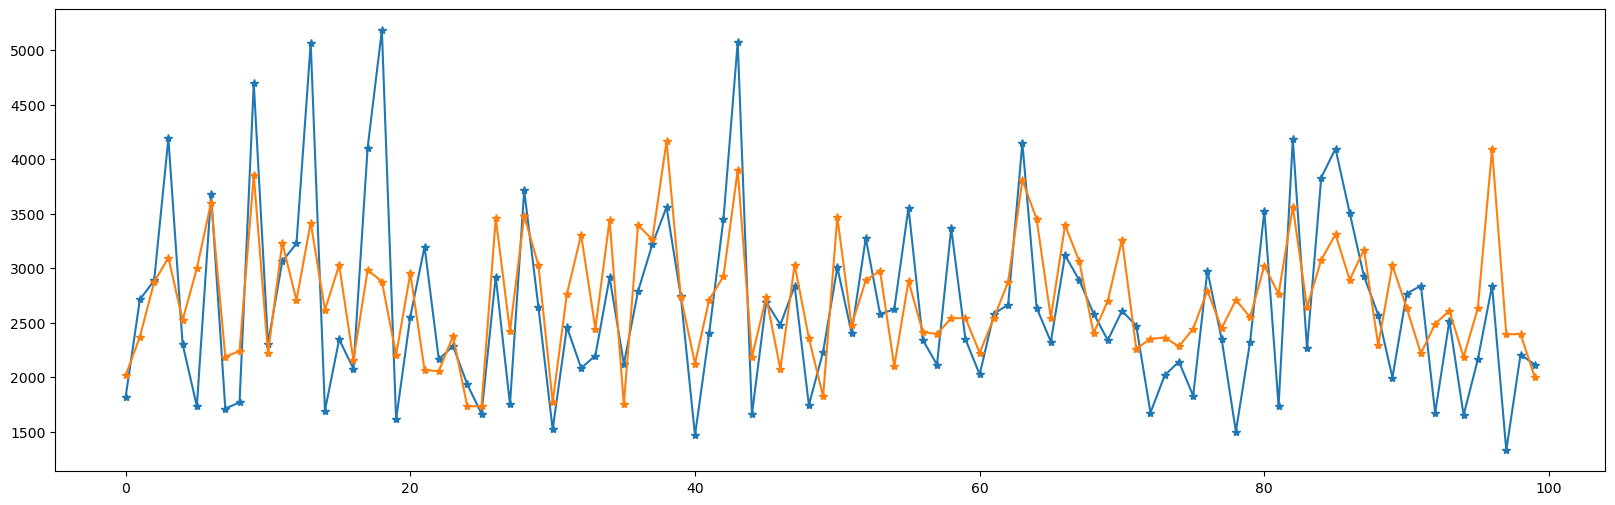

In [201]:
plt.figure(figsize=(20,6))
plt.plot(df_res['Reels'][0:100], "*-")
plt.plot(df_res['Prédits_LGB'][0:100], "*-")

#### fine tuning

In [ ]:
# deuxiemen tunnig pour réduire l'overfitting

# réduction de depth , leaves et sussample
LGB_V2 = LGBMRegressor(boosting_type= 'gbdt', colsample_bytree=0.60, learning_rate=0.05,n_estimators=800)
para_LG_V2 = { 
              'max_depth' : Integer(3,27),
              'num_leaves' : Integer(6,25),
              'subsample' : Real(0.5,0.9),
              'min_child_samples': Integer(90, 700),
              'reg_alpha': Real(0.1, 10),               
            'reg_lambda': Real(0.1, 10),
              }



XGB_V2 = XGBRegressor(objective='reg:squarederror',colsample_bytree=0.83 ,learning_rate= 0.088, n_estimators = 691)

# ajout de régularisation avec gamme,l1,l2
para_XG_V2 = { 
              'max_depth' : Integer(3,20),
              'subsample' : Real(0.5,0.9),
              "gamma" : Real(0,5),
              'min_child_weight': Integer(10, 500),
              'reg_alpha': Real(1e-5, 10.0, prior='log-uniform'),
             'reg_lambda': Real(1e-5, 10.0, prior='log-uniform')
              }

In [167]:
clfs = [LGB_V2,XGB_V2] 
parametres = [para_LG_V2,para_XG_V2]
cle_models = ["LGB_V2","XGB_V2"]
# Kcv = StratifiedKFold(n_splits = 5)
dico_grille_V2 = {}


for clf, para, model in zip(clfs, parametres, cle_models) : 
     dico_grille_V2[model] = BayesSearchCV(clf, 
                    search_spaces = para,
                    n_iter=50,
                    cv = 5, scoring = "neg_root_mean_squared_error",
                    n_jobs=-1, verbose=1)
    

In [ ]:
rst_models_tuned2 = {}

for model,grille in dico_grille_V2.items() :
    rst_models_tuned2[model] = grille.fit(X_train_vif,y_train)

In [184]:
print("best_para", rst_models_tuned2["LGB_V2"].best_params_)
print("best_para", rst_models_tuned2["XGB_V2"].best_params_)


best_para OrderedDict({'max_depth': 22, 'min_child_samples': 90, 'num_leaves': 25, 'reg_alpha': 0.1, 'reg_lambda': 0.8719889763623963, 'subsample': 0.7782726529011893})
best_para OrderedDict({'gamma': 5.0, 'max_depth': 7, 'min_child_weight': 256, 'reg_alpha': 10.0, 'reg_lambda': 7.944914380911199e-05, 'subsample': 0.9})


In [177]:
rst_lgbV2 , rst_xgbV2 =eval_mod(rst_models_tuned2["LGB_V2"].best_estimator_,X_train_vif,X_test_vif,y_train,y_test,idx="LGB_V2"),\
    eval_mod(rst_models_tuned2["XGB_V2"].best_estimator_,X_train_vif,X_test_vif,y_train,y_test,idx="XGB_V2")


In [178]:
tab_rst = pd.concat([tab_rst,rst_lgbV2,rst_xgbV2])

In [179]:
tab_rst

rmse_train   rmse_test        diff  overfit ratio
LG_full    694.460565  722.012152  -27.551587       1.039673
LG_vif     773.338797  767.060210    6.278587       0.991881
RF_full    256.783674  710.332456 -453.548782       2.766268
XGB_full   607.266869  687.087796  -79.820927       1.131443
LGB_full   646.697546  684.856314  -38.158768       1.059006
RF_vif     275.766799  729.134663 -453.367864       2.644026
SGD_vif    774.035251  767.602941    6.432311       0.991690
XGB_vif    659.187646  707.411480  -48.223835       1.073156
LGB_vif    703.928884  709.768134   -5.839250       1.008295
XGB_tuned  651.760849  699.230129  -47.469280       1.072832
LGB_tuned  642.164556  696.881779  -54.717223       1.085207
LGB_V2     677.495285  699.838708  -22.343423       1.032979
XGB_V2     643.304099  699.433271  -56.129172       1.087251

In [ ]:
# La LGBM V2 n'obtient pas les meilleurs résultats mais l'overfit est mieux gérer. On continue les analyse avec

In [180]:
rst_models_tuned2["LGB_V2"].best_estimator_

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.05, max_depth=22,
              min_child_samples=90, n_estimators=800, num_leaves=25,
              reg_alpha=0.1, reg_lambda=0.8719889763623963,
              subsample=0.7782726529011893)

#### lgbm categorical

LGBM est capable de traiter les variables catégorielles automatiquements sans encoding en amont.
On test un modèle ou seul les variables numériques sont encodées

In [260]:
# std
num = ["total_items","subtotal","num_distinct_items","min_item_price","max_item_price"
       ,"total_onshift_dashers","total_busy_dashers","available_dashers","prop_available_dashers","total_outstanding_orders"
       ,"estimated_order_place_duration","estimated_store_to_consumer_driving_duration","non_prep_time",
       "orders_bystore_30min","orders_bystore_45min","orders_bystore_60min"]

re = RobustScaler()
num_se_train =re.fit_transform(X_train[num])
num_se_test =re.transform(X_test[num])

num_se_train = pd.DataFrame(num_se_train,columns=re.get_feature_names_out(),index = X_train.index)
num_se_test = pd.DataFrame(num_se_test,columns=re.get_feature_names_out(),index = X_test.index)

# standard scaler
X_train_cat = pd.concat([X_train.drop(num,axis=1),num_se_train], axis=1)
X_test_cat = pd.concat([X_test.drop(num,axis=1),num_se_test], axis=1)



In [ ]:
cat_lgb = ["store_id","market_id","store_primary_category","order_protocol"]

X_train_cat[cat_lgb] = X_train_cat[cat_lgb].astype("category")
X_test_cat[cat_lgb] = X_test_cat[cat_lgb].astype("category")

#drop les variables colineaires ajout de  "available_dashers","orders_bystore_30min","num_distinct_items"
drop_var = ["available_dashers","orders_bystore_30min","total_items","total_onshift_dashers"
                ,"total_busy_dashers","non_prep_time","orders_bystore_45min","store_id"]

X_train_cat = X_train_cat.drop(drop_var,axis=1)
X_test_cat = X_test_cat.drop(drop_var,axis=1)



In [ ]:
lgb_cat = LGBMRegressor(objective = "regression")

lgb_cat.fit(X_train_cat,y_train,categorical_feature=cat_lgb)

In [225]:
tab_rst = pd.concat([tab_rst,eval_mod(lgb_cat,X_train_cat,X_test_cat,y_train,y_test,"lgbm_cat")])

In [226]:
tab_rst

rmse_train   rmse_test        diff  overfit ratio
LG_full    694.460565  722.012152  -27.551587       1.039673
LG_vif     773.338797  767.060210    6.278587       0.991881
RF_full    256.783674  710.332456 -453.548782       2.766268
XGB_full   607.266869  687.087796  -79.820927       1.131443
LGB_full   646.697546  684.856314  -38.158768       1.059006
RF_vif     275.766799  729.134663 -453.367864       2.644026
SGD_vif    774.035251  767.602941    6.432311       0.991690
XGB_vif    659.187646  707.411480  -48.223835       1.073156
LGB_vif    703.928884  709.768134   -5.839250       1.008295
XGB_tuned  651.760849  699.230129  -47.469280       1.072832
LGB_tuned  642.164556  696.881779  -54.717223       1.085207
LGB_V2     677.495285  699.838708  -22.343423       1.032979
XGB_V2     643.304099  699.433271  -56.129172       1.087251
lgbm_cat   701.360846  708.248792   -6.887946       1.009821

In [ ]:
# tuning des paramertres pour lgmb cat
lgb_cat = LGBMRegressor(objective = "regression")

para_LG_cat = {"boosting_type": Categorical(['gbdt']),
            'learning_rate': Real(0.003, 0.3, 'log-uniform'),
            'n_estimators': Integer(100, 800),
            'max_depth': Integer(3, 20),
            'num_leaves': Integer(6, 25),
            'subsample': Real(0.5, 0.9),
            'colsample_bytree': Real(0.6, 0.9),
            'min_child_samples': Integer(90, 700),
}


bay_lg_cat = BayesSearchCV(lgb_cat, 
            search_spaces = para_LG_cat,
            n_iter=50,
            cv = 5, scoring = "neg_root_mean_squared_error",
            n_jobs=-1, verbose=1)

bay_lg_cat.fit(X_train_cat,y_train,categorical_feature=['market_id',
                'store_primary_category', 'order_protocol'])

In [229]:
print(bay_lg_cat.best_params_)

OrderedDict({'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.10645782204832424, 'max_depth': 18, 'min_child_samples': 90, 'n_estimators': 698, 'num_leaves': 23, 'subsample': 0.9})


In [230]:
tab_rst = pd.concat([tab_rst,eval_mod(bay_lg_cat.best_estimator_,X_train_cat,X_test_cat,y_train,y_test,"lgb_cat_tuned")])
tab_rst

rmse_train   rmse_test        diff  overfit ratio
LG_full        694.460565  722.012152  -27.551587       1.039673
LG_vif         773.338797  767.060210    6.278587       0.991881
RF_full        256.783674  710.332456 -453.548782       2.766268
XGB_full       607.266869  687.087796  -79.820927       1.131443
LGB_full       646.697546  684.856314  -38.158768       1.059006
RF_vif         275.766799  729.134663 -453.367864       2.644026
SGD_vif        774.035251  767.602941    6.432311       0.991690
XGB_vif        659.187646  707.411480  -48.223835       1.073156
LGB_vif        703.928884  709.768134   -5.839250       1.008295
XGB_tuned      651.760849  699.230129  -47.469280       1.072832
LGB_tuned      642.164556  696.881779  -54.717223       1.085207
LGB_V2         677.495285  699.838708  -22.343423       1.032979
XGB_V2         643.304099  699.433271  -56.129172       1.087251
lgbm_cat       701.360846  708.248792   -6.887946       1.009821
lgb_cat_tuned  653.302618  697.490435  -44.187818       1.067638

#### modeles finaux

In [231]:
bay_lg_cat.best_estimator_

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.10645782204832424,
              max_depth=18, min_child_samples=90, n_estimators=698,
              num_leaves=23, objective='regression', subsample=0.9)

In [232]:
rst_models_tuned2["LGB_V2"].best_estimator_

LGBMRegressor(colsample_bytree=0.6, learning_rate=0.05, max_depth=22,
              min_child_samples=90, n_estimators=800, num_leaves=25,
              reg_alpha=0.1, reg_lambda=0.8719889763623963,
              subsample=0.7782726529011893)

In [233]:
final_lgbm_cat = bay_lg_cat.best_estimator_
final_lgbm = rst_models_tuned2["LGB_V2"].best_estimator_


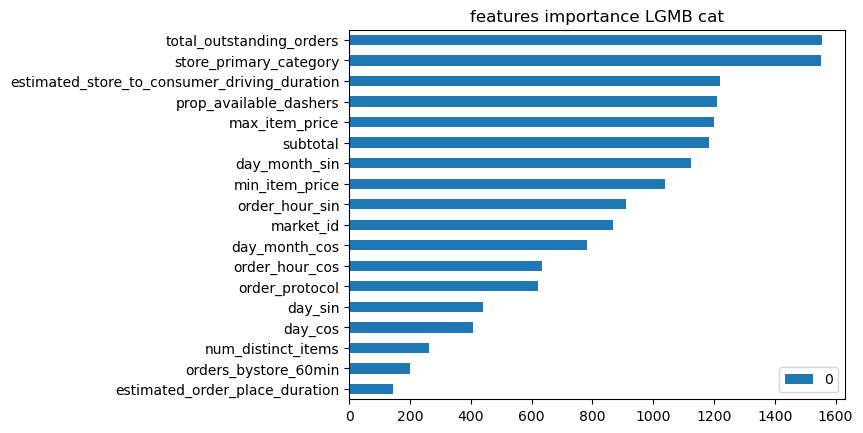

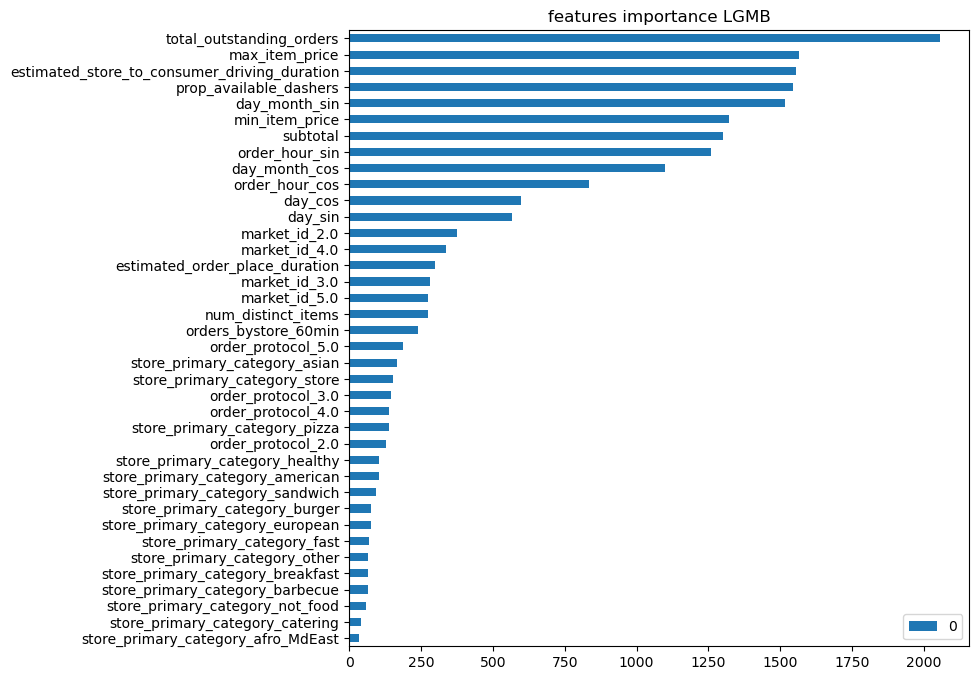

In [235]:

pd.DataFrame(final_lgbm_cat.feature_importances_, index=X_train_cat.columns).sort_values(by=0).plot(kind="barh",title="features importance LGMB cat")

pd.DataFrame(final_lgbm.feature_importances_, index=X_train_vif.columns).sort_values(by=0).plot(kind="barh"
                                                                                                ,title="features importance LGMB",
                                                                                                figsize = (8,8));

### **interpretation SHAP**

In [239]:
# analyse SHAP
import shap
import shap.explainers

In [ ]:
explainer = shap.TreeExplainer(final_lgbm,feature_names=X_train_vif.columns)
shap_values = explainer(X_train_vif)
shap_values.data = X_train_vif.values


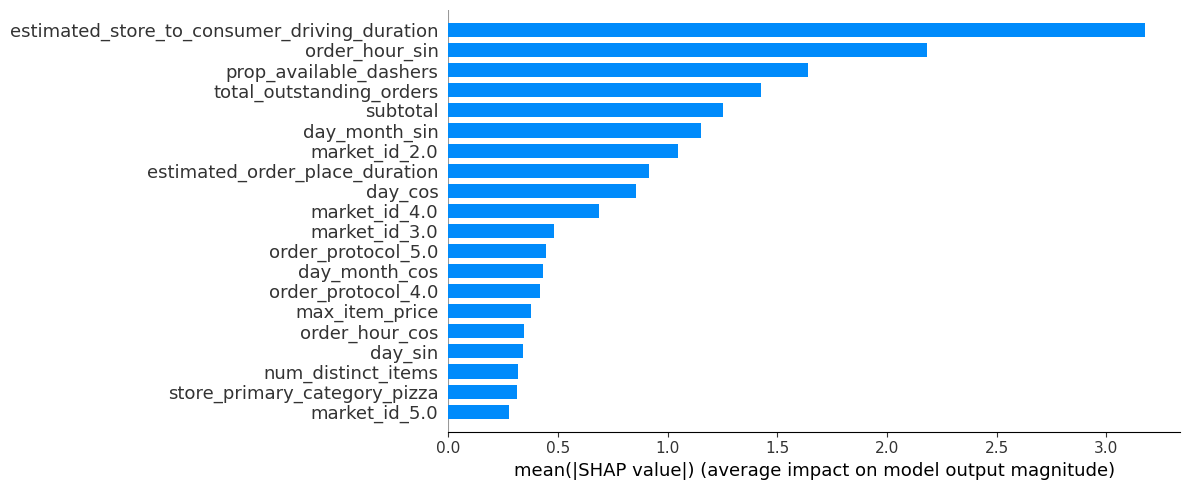

In [410]:
shap.summary_plot((shap_values)/60, X_train_vif, plot_type="bar",plot_size=[12,5])
# met les secondes en minutes 

<span stlye="font-size:15px">

Avec ce plot on peut voir à l'effet moyen des variables sur la prédiction moyenne du modèle
Les variables qui ont le plus d'impact sur les prédictions moyennes du modèles sont  : 
- la durée estimée du trajet restaurant-client (modifie la valeur de la prédiction moyenne de 3 minutes)
- l'heure 
- la proportion de livreurs disponibles 
- le nombre de commande alentour

</span>

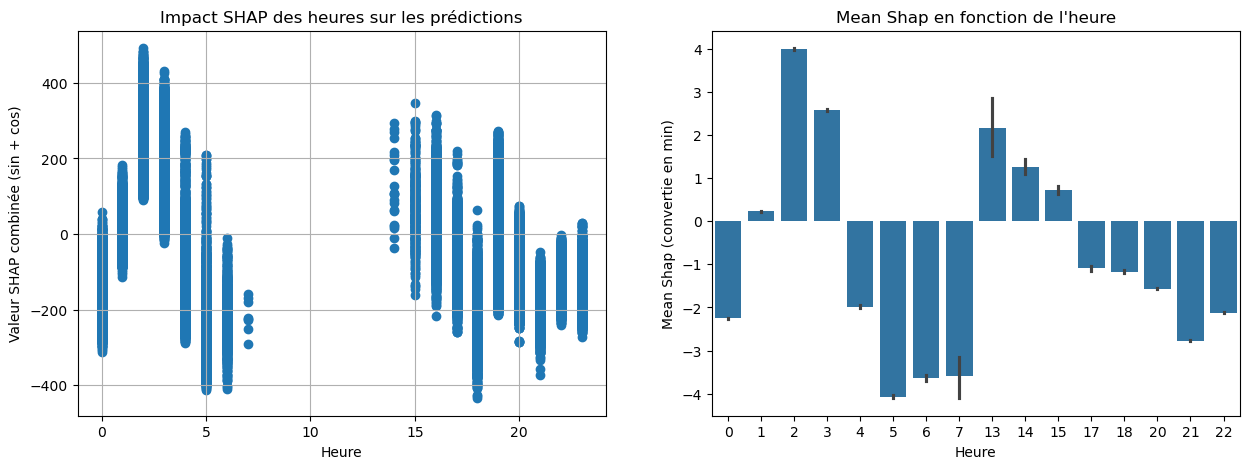

In [470]:
# pour faciliter analyse de l'effet de hour_sin on somme les shap values de hour_sin et hour_cos.
# puis reconstitue l'heure d'origine pour regarder l'effet moyen de l'heure sur les prédictions
shap_df = pd.DataFrame(shap_values.values, columns=X_train_vif.columns)

angles = np.arctan2(X_train_vif["order_hour_sin"], X_train_vif["order_hour_cos"])
hours_remake = (angles * 24 / (2 * np.pi)) % 24

shap_df["hour_total_shap"] = shap_df["order_hour_sin"] + shap_df["order_hour_cos"]
shap_df["hour"] = hours_remake

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(shap_df["hour"], shap_df["hour_total_shap"])
plt.xlabel("Heure")
plt.ylabel("Valeur SHAP combinée (sin + cos)")
plt.title("Impact SHAP des heures sur les prédictions")
plt.grid()

plt.subplot(122)
sns.barplot(x = shap_df["hour"].astype(int), y = (shap_df["hour_total_shap"])/60)
plt.ylabel("Mean Shap (convertie en min)")
plt.xlabel("Heure")
plt.title("Mean Shap en fonction de l'heure")

# rappel que certaines heures sous représentées

plt.show()

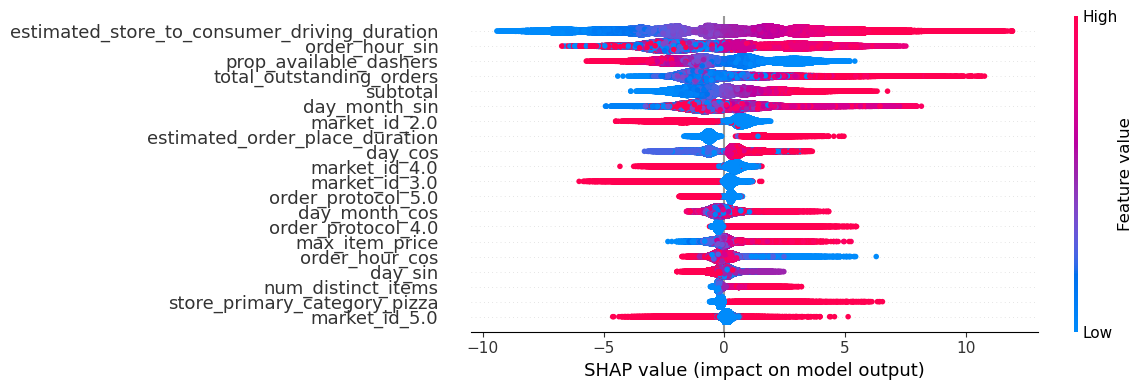

In [337]:
shap.summary_plot((shap_values)/60, X_train_vif, plot_type="dot",plot_size=[12,4],show=False)

# modele lgbm top features availables dashers : + de dispo = moins de temps d'attente corrélation négative
# la durée estimé du trajet restau-client : corrélation positif avec le temps de livraison total
# le nombre de commandes alentours, : corrélation positve
# le prix de la commande(lié au nombre d'item) : corrélation positive

<span style="font-size:15px">

Ce graphique montre comment les features impactes les prédictions en fonction de leurs valeurs et la magnitude de l'effet.  
Par exemple quand available dashers a de fortes valeurs, le temps de livraison diminue et inversement

</span>

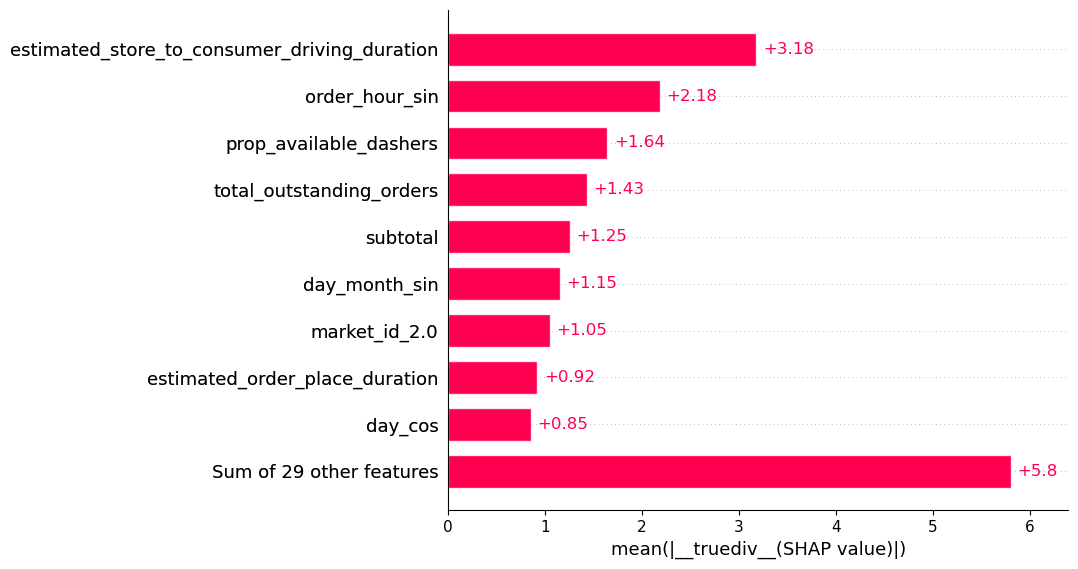

In [318]:
# effet moyen des variables sur les prédictions (en minutes)
shap.plots.bar(shap_values/60)


La somme de l'effet des autres variables représente un effet non négligeable.  
Même si une variable a une faible effet à priori, le cumul des effets peut impacter la prédictions. 

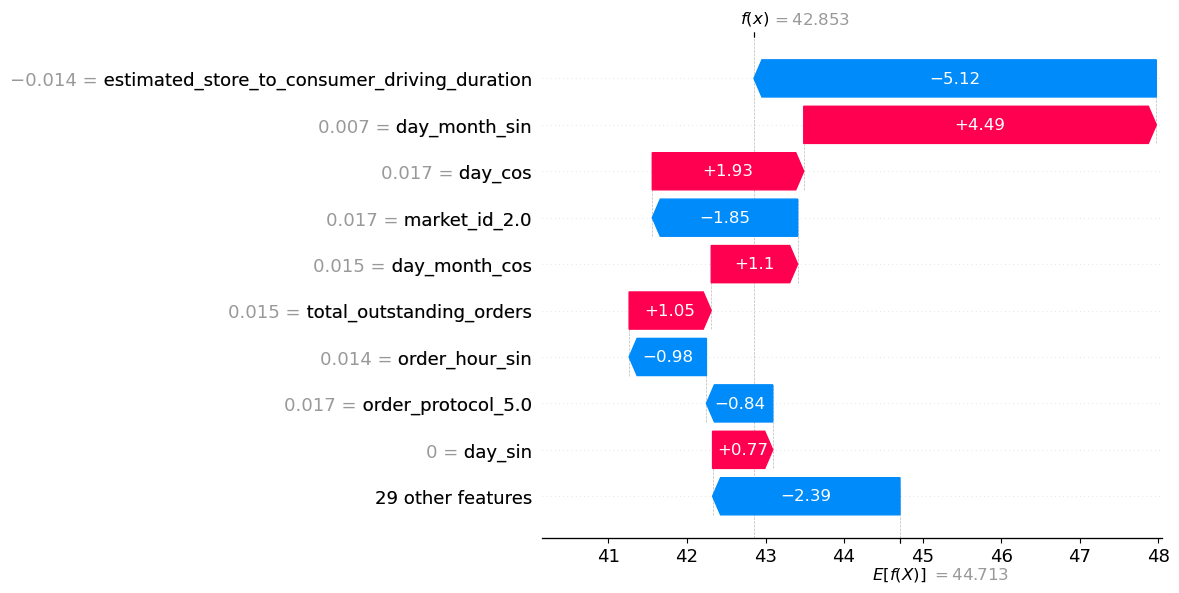

In [ ]:
# exemple de l'effet de la valeur de variable sur une prédiction
shap.plots.waterfall((shap_values[78])/60)


In [484]:
tab_rst.tail()

rmse_train   rmse_test       diff  overfit ratio
LGB_tuned      642.164556  696.881779 -54.717223       1.085207
LGB_V2         677.495285  699.838708 -22.343423       1.032979
XGB_V2         643.304099  699.433271 -56.129172       1.087251
lgbm_cat       701.360846  708.248792  -6.887946       1.009821
lgb_cat_tuned  653.302618  697.490435 -44.187818       1.067638



L'objectif de ce projet était de prédire le temps de livraison de commande passées via l'application DoorDash.  
Seul la régression a été explorée.          

Parmis les modèles testés le gradient boosting LGBM a donnée les meilleur résultats avec une RMSE moyenne de 699 secondes (soit 11min30).    
L'interprétation du modèle a montré que le temps de trajet restaurant-client,l'heure de commande et la proportion de livreurs disponible sont les variables les plus importantes pour les prédictions du modèle.    
Cependant il ne faut pas oublier que la somme de l'effet des autres variables peu également affecter la prédiction.


</span>